# Bachelor Thesis: Predicting flight delays
#### Author: Tygo Francissen, s1049742, Radboud University
This thesis aims to predict flight delays in the United States and Brazil by using a broad scale of machine learning algorithms and transfer learning.

### 1 Gathering the data
The data sets are gathered from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov) and the [VRA](https://sas.anac.gov.br/sas/bav/view/frmConsultaVRA). Firstly, we store the data, which ranges from January 1st 2022 until December 31st 2022 for both data sets.

In [1]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from deep_translator import GoogleTranslator
from pandas.api.types import is_numeric_dtype
from sklearn.feature_selection import chi2, mutual_info_classif
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import ArcGIS
from sklearn.feature_selection import SelectKBest

In [69]:
# Store the data set for 2022 in Brazil
data_brazil = pd.read_excel('../Data/Brazil 2022.xlsx')

# Store each month of 2022 separated for USA
data_usa_jan = pd.read_csv('../Data/USA January 2022.csv')
data_usa_feb = pd.read_csv('../Data/USA February 2022.csv')
data_usa_mar = pd.read_csv('../Data/USA March 2022.csv')
data_usa_apr = pd.read_csv('../Data/USA April 2022.csv')
data_usa_may = pd.read_csv('../Data/USA May 2022.csv')
data_usa_jun = pd.read_csv('../Data/USA June 2022.csv')
data_usa_jul = pd.read_csv('../Data/USA July 2022.csv')
data_usa_aug = pd.read_csv('../Data/USA August 2022.csv')
data_usa_sep = pd.read_csv('../Data/USA September 2022.csv')
data_usa_oct = pd.read_csv('../Data/USA October 2022.csv')
data_usa_nov = pd.read_csv('../Data/USA November 2022.csv')
data_usa_dec = pd.read_csv('../Data/USA December 2022.csv')

# Concatentate all the months together into one USA data set for 2022
data_usa = pd.concat([data_usa_jan, data_usa_feb, data_usa_mar, data_usa_apr, data_usa_may, data_usa_jun, data_usa_jul, data_usa_aug, data_usa_sep, data_usa_oct, data_usa_nov, data_usa_dec], ignore_index=True)

### 2 Preprocessing the Brazilian data

We will preprocess both data sets separately, but trying to keep the information in both data sets match each other where possible. The first data set to be preprocessed is the Brazilian data set.

#### 2.1 Looking at the data

Let's have a look at the data first before modifying it.

In [3]:
display(data_brazil)

Sigla ICAO Empresa Aérea  \
0                           1DE   
1                           1DE   
2                           1ED   
3                           1ED   
4                           AAL   
...                         ...   
879291                      VVC   
879292                      VVC   
879293                      VVC   
879294                      VVC   
879295                      VVC   

                                           Empresa Aérea Número Voo Código DI  \
0       SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S       5330         7   
1       SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S       5330         2   
2       SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S       5330         7   
3       SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S       5330         7   
4                                AMERICAN AIRLINES, INC.        904         0   
...                                                  ...        ...       ...   
879291                          VIVA AIR - FAST COLOMBIA        461         2   
879292                          VIVA AIR - FAST COLOMBIA        460         0   
879293                          VIVA AIR - FAST COLOMBIA        460         2   
879294                          VIVA AIR - FAST COLOMBIA        461         0   
879295                          VIVA AIR - FAST COLOMBIA        461         2   

       Código Tipo Linha Modelo Equipamento  Número de Assentos  \
0                      I               E145                  50   
1                      I               E145                  50   
2                      I               E145                  50   
3                      I               E145                  50   
4                      I               B788                 295   
...                  ...                ...                 ...   
879291                 X               A320                 173   
879292                 I               A320                 188   
879293                 X               A320                 180   
879294                 I               A320                 188   
879295                 X               A320                 173   

       Sigla ICAO Aeroporto Origem  \
0                             SKLT   
1                             SLVR   
2                             SLVR   
3                             SBPA   
4                             SBGL   
...                            ...   
879291                        SBGR   
879292                        SBGR   
879293                        SKRG   
879294                        SKRG   
879295                        SBGR   

                               Descrição Aeroporto Origem    Partida Prevista  \
0       ALFREDO VÁSQUEZ COBO INTERNATIONAL AIRPORT - L... 2022-05-15 14:00:00   
1       VIRU VIRU INTERNATIONAL AIRPORT - SANTA CRUZ -... 2022-05-15 17:35:00   
2       VIRU VIRU INTERNATIONAL AIRPORT - SANTA CRUZ -... 2022-05-18 04:00:00   
3              SALGADO FILHO - PORTO ALEGRE - RS - BRASIL 2022-05-18 00:15:00   
4       AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL... 2022-01-01 00:05:00   
...                                                   ...                 ...   
879291  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...                 NaT   
879292  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ... 2022-12-31 05:20:00   
879293  JOSÉ MARÍA CÓRDOVA INTERNATIONAL AIRPORT - MED...                 NaT   
879294  JOSÉ MARÍA CÓRDOVA INTERNATIONAL AIRPORT - MED... 2022-12-31 22:00:00   
879295  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...                 NaT   

               Partida Real Sigla ICAO Aeroporto Destino  \
0       2022-05-15 17:00:00                         SLVR   
1       2022-05-15 20:25:00                         SBPA   
2       2022-05-18 08:10:00                         SKLT   
3       2022-05-18 04:30:00                         SLVR   
4                       NaN                         KMIA   
...               

The Brazilian data set is written in Brazilian language, while the author is unable to read this language. Therefore, we translate the column names of the Brazilian data set into English text. To increase readability of the data, two lookup dictionaries for the airline and airport ICAO code are created (and translated).

In [4]:
# Translate the column names of the Brazilian data set
translator = GoogleTranslator(source='auto', target='en')
for i, _ in enumerate(data_brazil.columns.values):
    data_brazil.rename(columns={data_brazil.columns.values[i]:translator.translate(data_brazil.columns.values[i])}, inplace=True)
    
# Create dictionary to look up full name of airline ICAO code
values = [translator.translate(name) for name in data_brazil["airline"].unique()]
airline_code_dict = dict(zip(data_brazil["Acronym ICAO Airline"].unique(), values))

# Create dictionary to look up full name of airport ICAO code
keys = pd.unique(np.concatenate((data_brazil["Acronym ICAO Airport Origin"].unique(),data_brazil["Acronym ICAO Destiny Airport"].unique())))
airports = pd.unique(np.concatenate((data_brazil["Description Origin Airport"].unique(),data_brazil["Destination Airport Description"].unique())))
values = [translator.translate(name) for name in airports]
airport_code_dict = dict(zip(keys, values))

Since some columns still contain Brazilian words, the remaining words are translated to English.

In [5]:
# Translate remaining Brazilian words in data set
for word in data_brazil["Flight Status"].unique():
    data_brazil["Flight Status"] = data_brazil["Flight Status"].replace(word, translator.translate(word))

for word in data_brazil["Starting Status"].unique():
    if not type(word)==float:
        data_brazil["Starting Status"] = data_brazil["Starting Status"].replace(word, translator.translate(word))

for word in data_brazil["Arrival Status"].unique():
    if not type(word)==float:
        data_brazil["Arrival Status"] = data_brazil["Arrival Status"].replace(word, translator.translate(word))

Now that all text has been properly translated, we can have a look at the data again.

In [6]:
display(data_brazil)

Acronym ICAO Airline                                           airline  \
0                       1DE  SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S   
1                       1DE  SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S   
2                       1ED  SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S   
3                       1ED  SERVICIOS AÉREOS PANAMERICANOS LTDA. SARPA S.A.S   
4                       AAL                           AMERICAN AIRLINES, INC.   
...                     ...                                               ...   
879291                  VVC                          VIVA AIR - FAST COLOMBIA   
879292                  VVC                          VIVA AIR - FAST COLOMBIA   
879293                  VVC                          VIVA AIR - FAST COLOMBIA   
879294                  VVC                          VIVA AIR - FAST COLOMBIA   
879295                  VVC                          VIVA AIR - FAST COLOMBIA   

       Flight Number Code DI Line Type Code Model Equipment  Number of Seats  \
0               5330       7              I            E145               50   
1               5330       2              I            E145               50   
2               5330       7              I            E145               50   
3               5330       7              I            E145               50   
4                904       0              I            B788              295   
...              ...     ...            ...             ...              ...   
879291           461       2              X            A320              173   
879292           460       0              I            A320              188   
879293           460       2              X            A320              180   
879294           461       0              I            A320              188   
879295           461       2              X            A320              173   

       Acronym ICAO Airport Origin  \
0                             SKLT   
1                             SLVR   
2                             SLVR   
3                             SBPA   
4                             SBGL   
...                            ...   
879291                        SBGR   
879292                        SBGR   
879293                        SKRG   
879294                        SKRG   
879295                        SBGR   

                               Description Origin Airport Scheduled departure  \
0       ALFREDO VÁSQUEZ COBO INTERNATIONAL AIRPORT - L... 2022-05-15 14:00:00   
1       VIRU VIRU INTERNATIONAL AIRPORT - SANTA CRUZ -... 2022-05-15 17:35:00   
2       VIRU VIRU INTERNATIONAL AIRPORT - SANTA CRUZ -... 2022-05-18 04:00:00   
3              SALGADO FILHO - PORTO ALEGRE - RS - BRASIL 2022-05-18 00:15:00   
4       AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL... 2022-01-01 00:05:00   
...                                                   ...                 ...   
879291  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...                 NaT   
879292  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ... 2022-12-31 05:20:00   
879293  JOSÉ MARÍA CÓRDOVA INTERNATIONAL AIRPORT - MED...                 NaT   
879294  JOSÉ MARÍA CÓRDOVA INTERNATIONAL AIRPORT - MED... 2022-12-31 22:00:00   
879295  GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...                 NaT   

               actual match Acronym ICAO Destiny Airport  \
0       2022-05-15 17:00:00                         SLVR   
1       2022-05-15 20:25:00                         SBPA   
2       2022-05-18 08:10:00                         SKLT   
3       2022-05-18 04:30:00                         SLVR   
4                       NaN                         KMIA   
...                     ...                          ...   
879291  2022-12-30 20:00:00                         SKRG   
879292                  NaN                         SKRG   
879293  2022-12-31 07:24:00                         SBGR   
879294                  NaN                

Since we created lookup dictionaries for the airline and airport ICAO code, the columns 'airline', 'Description Origin Airport', and 'Destination Airport Description' can be removed.

In [7]:
# Remove redundant columns
data_brazil2 = data_brazil.drop(columns=['airline', 'Description Origin Airport', 'Destination Airport Description'])
display(data_brazil2)

Acronym ICAO Airline Flight Number Code DI Line Type Code  \
0                       1DE          5330       7              I   
1                       1DE          5330       2              I   
2                       1ED          5330       7              I   
3                       1ED          5330       7              I   
4                       AAL           904       0              I   
...                     ...           ...     ...            ...   
879291                  VVC           461       2              X   
879292                  VVC           460       0              I   
879293                  VVC           460       2              X   
879294                  VVC           461       0              I   
879295                  VVC           461       2              X   

       Model Equipment  Number of Seats Acronym ICAO Airport Origin  \
0                 E145               50                        SKLT   
1                 E145               50                        SLVR   
2                 E145               50                        SLVR   
3                 E145               50                        SBPA   
4                 B788              295                        SBGL   
...                ...              ...                         ...   
879291            A320              173                        SBGR   
879292            A320              188                        SBGR   
879293            A320              180                        SKRG   
879294            A320              188                        SKRG   
879295            A320              173                        SBGR   

       Scheduled departure         actual match Acronym ICAO Destiny Airport  \
0      2022-05-15 14:00:00  2022-05-15 17:00:00                         SLVR   
1      2022-05-15 17:35:00  2022-05-15 20:25:00                         SBPA   
2      2022-05-18 04:00:00  2022-05-18 08:10:00                         SKLT   
3      2022-05-18 00:15:00  2022-05-18 04:30:00                         SLVR   
4      2022-01-01 00:05:00                  NaN                         KMIA   
...                    ...                  ...                          ...   
879291                 NaT  2022-12-30 20:00:00                         SKRG   
879292 2022-12-31 05:20:00                  NaN                         SKRG   
879293                 NaT  2022-12-31 07:24:00                         SBGR   
879294 2022-12-31 22:00:00                  NaN                         SBGR   
879295                 NaT  2022-12-31 20:01:00                         SKRG   

          Expected Arrival      actual arrival Flight Status  Justification  \
0      2022-05-15 16:35:00 2022-05-15 19:25:00  ACCOMPLISHED            NaN   
1      2022-05-15 20:05:00 2022-05-15 23:05:00  ACCOMPLISHED            NaN   
2      2022-05-18 06:35:00 2022-05-18 10:35:00  ACCOMPLISHED            NaN   
3      2022-05-18 03:00:00 2022-05-18 07:10:00  ACCOMPLISHED            NaN   
4      2022-01-01 08:50:00                 NaT      CANCELED            NaN   
...                    ...                 ...           ...            ...   
879291                 NaT 2022-12-31 06:21:00  ACCOMPLISHED            NaN   
879292 2022-12-31 11:38:00                 NaT      CANCELED            NaN   
879293                 NaT 2022-12-31 09:25:00  ACCOMPLISHED            NaN   
879294 2023-01-01 04:30:00                 NaT      CANCELED            NaN   
879295                 NaT 2023-01-01 06:33:00  ACCOMPLISHED            NaN   

        Reference Starting Status Arrival Status  
0      2022-05-15   Delay 120-240  Delay 120-240  
1      2022-05-15   Delay 120-240  Delay 120-240  
2      2022-05-18      Delay >240  Delay 120-240  
3      2022-05-18      Delay >240     Delay >240  
4      2022-01-01             NaN            NaN  
...           ...             ...            ...  
879291 2022-12-30             NaN            NaN  
879292 2022-12-31  

#### 2.2 First steps of data cleaning
Now that the data set has been made more readable, we can start having a look at the values of the columns and its properties.

In [8]:
print(data_brazil2.count())

Acronym ICAO Airline            879296
Flight Number                   879296
Code DI                         879296
Line Type Code                  879292
Model Equipment                 879296
Number of Seats                 879296
Acronym ICAO Airport Origin     879296
Scheduled departure             850891
actual match                    832270
Acronym ICAO Destiny Airport    879296
Expected Arrival                850891
actual arrival                  832251
Flight Status                   879296
Justification                        0
Reference                       879296
Starting Status                 803865
Arrival Status                  803846
dtype: int64


The justification column has no record, thus it will be removed.

In [9]:
# Drop justification column as it has no entries
data_brazil2.drop(columns=['Justification'], inplace=True)

If we look at the flight status column, it can be seen that there are 3 possible options: cancelled, uninformed and accomplished. Since we are only interested in flight delays, we will only look at flights that have been accomplished. That leaves this column with only one possible value, so the column can be removed as well.

In [10]:
# Drop entries of flights that are cancelled or uninformed
data_brazil3 = data_brazil2.drop(data_brazil2[(data_brazil2["Flight Status"] == "CANCELED") | (data_brazil2["Flight Status"] == "UNINFORMED")].index)

# Drop flight status column as it has no use anymore
data_brazil3.drop(columns=['Flight Status'], inplace=True)

Let's have a look at the counts of each column again.

In [11]:
print(data_brazil3.count())

Acronym ICAO Airline            832271
Flight Number                   832271
Code DI                         832271
Line Type Code                  832271
Model Equipment                 832271
Number of Seats                 832271
Acronym ICAO Airport Origin     832271
Scheduled departure             803866
actual match                    832270
Acronym ICAO Destiny Airport    832271
Expected Arrival                803866
actual arrival                  832251
Reference                       832271
Starting Status                 803865
Arrival Status                  803846
dtype: int64


We can see that there are still some missing values in our data set. There are flight records from which the scheduled departure and scheduled arrival are not available. Since this missing data is crucial for the machine learning algorithms and it only entails ~3% of the data, these records will be removed. There are also a few flights from which the actual departure and arrival time are not known. These are removed, because this data is needed in order to know whether a flight was delayed or not.

In [12]:
# Drop records with missing crucial data
data_brazil3.drop(data_brazil3[data_brazil3['Scheduled departure'].isna()].index, inplace=True)
data_brazil3.drop(data_brazil3[data_brazil3['actual match'].isna()].index, inplace=True)
data_brazil3.drop(data_brazil3[data_brazil3['actual arrival'].isna()].index, inplace=True)

By having a look at the counts of each column again, we can confirm that all missing values have been removed.

In [13]:
data_brazil3.count()

Acronym ICAO Airline            803845
Flight Number                   803845
Code DI                         803845
Line Type Code                  803845
Model Equipment                 803845
Number of Seats                 803845
Acronym ICAO Airport Origin     803845
Scheduled departure             803845
actual match                    803845
Acronym ICAO Destiny Airport    803845
Expected Arrival                803845
actual arrival                  803845
Reference                       803845
Starting Status                 803845
Arrival Status                  803845
dtype: int64

Let's have a look at the column datatypes now.

In [14]:
data_brazil3.dtypes

Acronym ICAO Airline                    object
Flight Number                           object
Code DI                                 object
Line Type Code                          object
Model Equipment                         object
Number of Seats                          int64
Acronym ICAO Airport Origin             object
Scheduled departure             datetime64[ns]
actual match                            object
Acronym ICAO Destiny Airport            object
Expected Arrival                datetime64[ns]
actual arrival                  datetime64[ns]
Reference                       datetime64[ns]
Starting Status                         object
Arrival Status                          object
dtype: object

It can be seen that actual match column is incorrectly assigned to an object datatype instead of a datetime object. This is caused due to an incorrectly typed data format in the dataset. It will therefore get removed.

In [15]:
# Drop record with incorrect date format and convert column to correct data type
data_brazil3.drop(index=data_brazil3.iloc[310154].name, inplace=True)
data_brazil3['actual match'] = pd.to_datetime(data_brazil3['actual match'])

To create our response variable, we are calculating the total delay of each flight. The total delay is calculated by adding the arrival delay to the departure delay. If the total delay is more than 15 minutes, the flight is considered delayed. We create 3 response variables here, for eventual use cases later in the research.

In [16]:
# Change starting status column to represent whether the departure delay is more than 15 minutes
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) <= datetime.timedelta(minutes=15), "Starting Status"] = 0
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) > datetime.timedelta(minutes=15), "Starting Status"] = 1

# Change arrival status column to represent whether the arrival delay is more than 15 minutes
data_brazil3.loc[(data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) <= datetime.timedelta(minutes=15), "Arrival Status"] = 0
data_brazil3.loc[(data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) > datetime.timedelta(minutes=15), "Arrival Status"] = 1

# Create new column "Delayed" which represents whether the total delay of the flight is more than 15 minutes
data_brazil3.reset_index(drop=True, inplace=True)
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) + (data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) <= datetime.timedelta(minutes=15), "Delayed"] = 0
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) + (data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) > datetime.timedelta(minutes=15), "Delayed"] = 1
data_brazil3["Delayed"] = data_brazil3["Delayed"].astype(int)

display(data_brazil3)

Acronym ICAO Airline Flight Number Code DI Line Type Code  \
0                       1DE          5330       7              I   
1                       1DE          5330       2              I   
2                       1ED          5330       7              I   
3                       1ED          5330       7              I   
4                       AAL           789       0              I   
...                     ...           ...     ...            ...   
803839                  VVC           461       0              I   
803840                  VVC           460       0              I   
803841                  VVC           461       0              I   
803842                  VVC           460       0              I   
803843                  VVC           461       0              I   

       Model Equipment  Number of Seats Acronym ICAO Airport Origin  \
0                 E145               50                        SKLT   
1                 E145               50                        SLVR   
2                 E145               50                        SLVR   
3                 E145               50                        SBPA   
4                 B788              295                        KMIA   
...                ...              ...                         ...   
803839            A320              188                        SKRG   
803840            A320              188                        SBGR   
803841            A320              188                        SKRG   
803842            A320              188                        SBGR   
803843            A320              188                        SKRG   

       Scheduled departure        actual match Acronym ICAO Destiny Airport  \
0      2022-05-15 14:00:00 2022-05-15 17:00:00                         SLVR   
1      2022-05-15 17:35:00 2022-05-15 20:25:00                         SBPA   
2      2022-05-18 04:00:00 2022-05-18 08:10:00                         SKLT   
3      2022-05-18 00:15:00 2022-05-18 04:30:00                         SLVR   
4      2022-02-01 02:55:00 2022-02-01 02:56:00                         SBGR   
...                    ...                 ...                          ...   
803839 2022-10-28 21:53:00 2022-10-28 21:53:00                         SBGR   
803840 2022-10-29 05:25:00 2022-10-29 05:24:00                         SKRG   
803841 2022-10-29 22:00:00 2022-10-29 21:47:00                         SBGR   
803842 2022-10-30 05:20:00 2022-10-30 05:29:00                         SKRG   
803843 2022-10-31 22:00:00 2022-10-31 21:54:00                         SBGR   

          Expected Arrival      actual arrival  Reference Starting Status  \
0      2022-05-15 16:35:00 2022-05-15 19:25:00 2022-05-15               1   
1      2022-05-15 20:05:00 2022-05-15 23:05:00 2022-05-15               1   
2      2022-05-18 06:35:00 2022-05-18 10:35:00 2022-05-18               1   
3      2022-05-18 03:00:00 2022-05-18 07:10:00 2022-05-18               1   
4      2022-02-01 11:20:00 2022-02-01 10:58:00 2022-02-01               0   
...                    ...                 ...        ...             ...   
803839 2022-10-29 04:25:00 2022-10-29 03:59:00 2022-10-28               0   
803840 2022-10-29 11:41:00 2022-10-29 11:37:00 2022-10-29               0   
803841 2022-10-30 04:30:00 2022-10-30 03:43:00 2022-10-29               0   
803842 2022-10-30 11:38:00 2022-10-30 11:36:00 2022-10-30               0   
803843 2022-11-01 04:30:00 2022-11-01 04:18:00 2022-10-31               0   

       Arrival Status  Delayed  
0                   1        1  
1                   1        1  
2                   1        1  
3                   1        1  
4                   0        0  
...               ...      ...  
803839              0        0  
803840              0        0  
803841              0        0  
803842              0        0  
803843              0        0  

[803844 rows x 16 columns]

It's useful for the machine learning algorithms to split up the departure date and expected arrival. Therefore, we split the departure date into month, week, day, hour, minute and day of the week. The expected arrival is split into hour and minute, to avoid high collinearity since most flights arrive at the same day. Also, the data is ordered on their departure date, and a couple of entries seem to fall outside the month January, which is the reason they got removed.

In [17]:
# Create new columns to split up the departure date
data_brazil3["SchedDeparture_month"] = data_brazil3["Scheduled departure"].dt.month
data_brazil3["SchedDeparture_week"] = data_brazil3["Scheduled departure"].dt.isocalendar().week
data_brazil3["SchedDeparture_day"] = data_brazil3["Scheduled departure"].dt.day
data_brazil3["SchedDeparture_hour"] = data_brazil3["Scheduled departure"].dt.hour
data_brazil3["SchedDeparture_minute"] = data_brazil3["Scheduled departure"].dt.minute
data_brazil3["SchedDeparture_dayofweek"] = data_brazil3["Scheduled departure"].dt.dayofweek

# Create new columns for parts of the expected arrival date
data_brazil3["ExpArrival_hour"] = data_brazil3["Expected Arrival"].dt.hour
data_brazil3["ExpArrival_minute"] = data_brazil3["Expected Arrival"].dt.minute

# Drop redundant columns with dates
data_brazil4 = data_brazil3.drop(columns=['Scheduled departure', 'Expected Arrival'])
display(data_brazil4)

Acronym ICAO Airline Flight Number Code DI Line Type Code  \
0                       1DE          5330       7              I   
1                       1DE          5330       2              I   
2                       1ED          5330       7              I   
3                       1ED          5330       7              I   
4                       AAL           789       0              I   
...                     ...           ...     ...            ...   
803839                  VVC           461       0              I   
803840                  VVC           460       0              I   
803841                  VVC           461       0              I   
803842                  VVC           460       0              I   
803843                  VVC           461       0              I   

       Model Equipment  Number of Seats Acronym ICAO Airport Origin  \
0                 E145               50                        SKLT   
1                 E145               50                        SLVR   
2                 E145               50                        SLVR   
3                 E145               50                        SBPA   
4                 B788              295                        KMIA   
...                ...              ...                         ...   
803839            A320              188                        SKRG   
803840            A320              188                        SBGR   
803841            A320              188                        SKRG   
803842            A320              188                        SBGR   
803843            A320              188                        SKRG   

              actual match Acronym ICAO Destiny Airport      actual arrival  \
0      2022-05-15 17:00:00                         SLVR 2022-05-15 19:25:00   
1      2022-05-15 20:25:00                         SBPA 2022-05-15 23:05:00   
2      2022-05-18 08:10:00                         SKLT 2022-05-18 10:35:00   
3      2022-05-18 04:30:00                         SLVR 2022-05-18 07:10:00   
4      2022-02-01 02:56:00                         SBGR 2022-02-01 10:58:00   
...                    ...                          ...                 ...   
803839 2022-10-28 21:53:00                         SBGR 2022-10-29 03:59:00   
803840 2022-10-29 05:24:00                         SKRG 2022-10-29 11:37:00   
803841 2022-10-29 21:47:00                         SBGR 2022-10-30 03:43:00   
803842 2022-10-30 05:29:00                         SKRG 2022-10-30 11:36:00   
803843 2022-10-31 21:54:00                         SBGR 2022-11-01 04:18:00   

        ... Arrival Status Delayed SchedDeparture_month  SchedDeparture_week  \
0       ...              1       1                    5                   19   
1       ...              1       1                    5                   19   
2       ...              1       1                    5                   20   
3       ...              1       1                    5                   20   
4       ...              0       0                    2                    5   
...     ...            ...     ...                  ...                  ...   
803839  ...              0       0                   10                   43   
803840  ...              0       0                   10                   43   
803841  ...              0       0                   10                   43   
803842  ...              0       0                   10                   43   
803843  ...              0       0                   10                   44   

        SchedDeparture_day  SchedDeparture_hour  SchedDeparture_minute  \
0                       15                   14                      0   
1                       15                   17                     35   
2                       18                    4                      0   
3                       18                    0                     15   
4                        1                    2          

#### 2.3 Data exploration
Now that parts of the data have been preprocessed, the data can be visualized in different ways. First of all, we plot all the airports that are present in this dataset on a world map.

<AxesSubplot: >

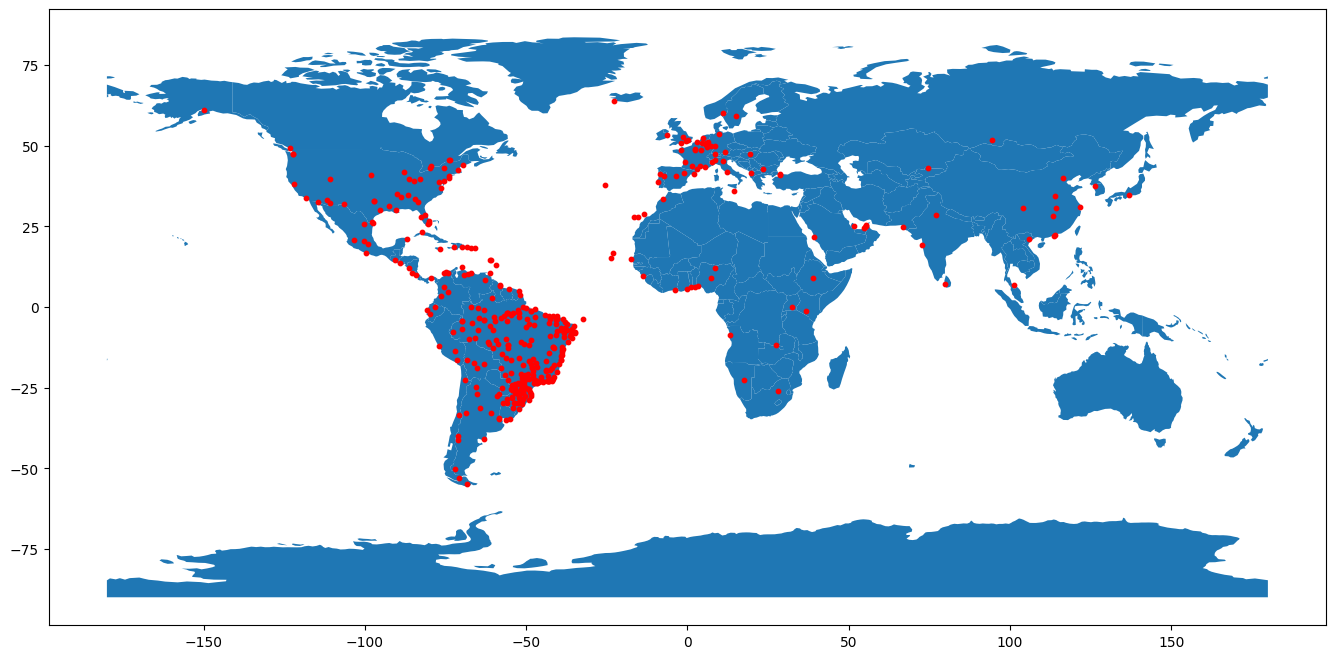

In [18]:
# Create list with coordinates for each airport
geo = ArcGIS()
intermediate = []

for short in airport_code_dict:
    location = geo.geocode(airport_code_dict.get(short))
    intermediate.append([location.longitude, location.latitude])
df = pd.DataFrame(intermediate, columns=["Longitude", "Latitude"])

# Print the coordinates on the world map
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 8)), marker='o', color='red', markersize=10)

It is also important to look at distributions of the variables. This can be done by creating histograms and boxplots.

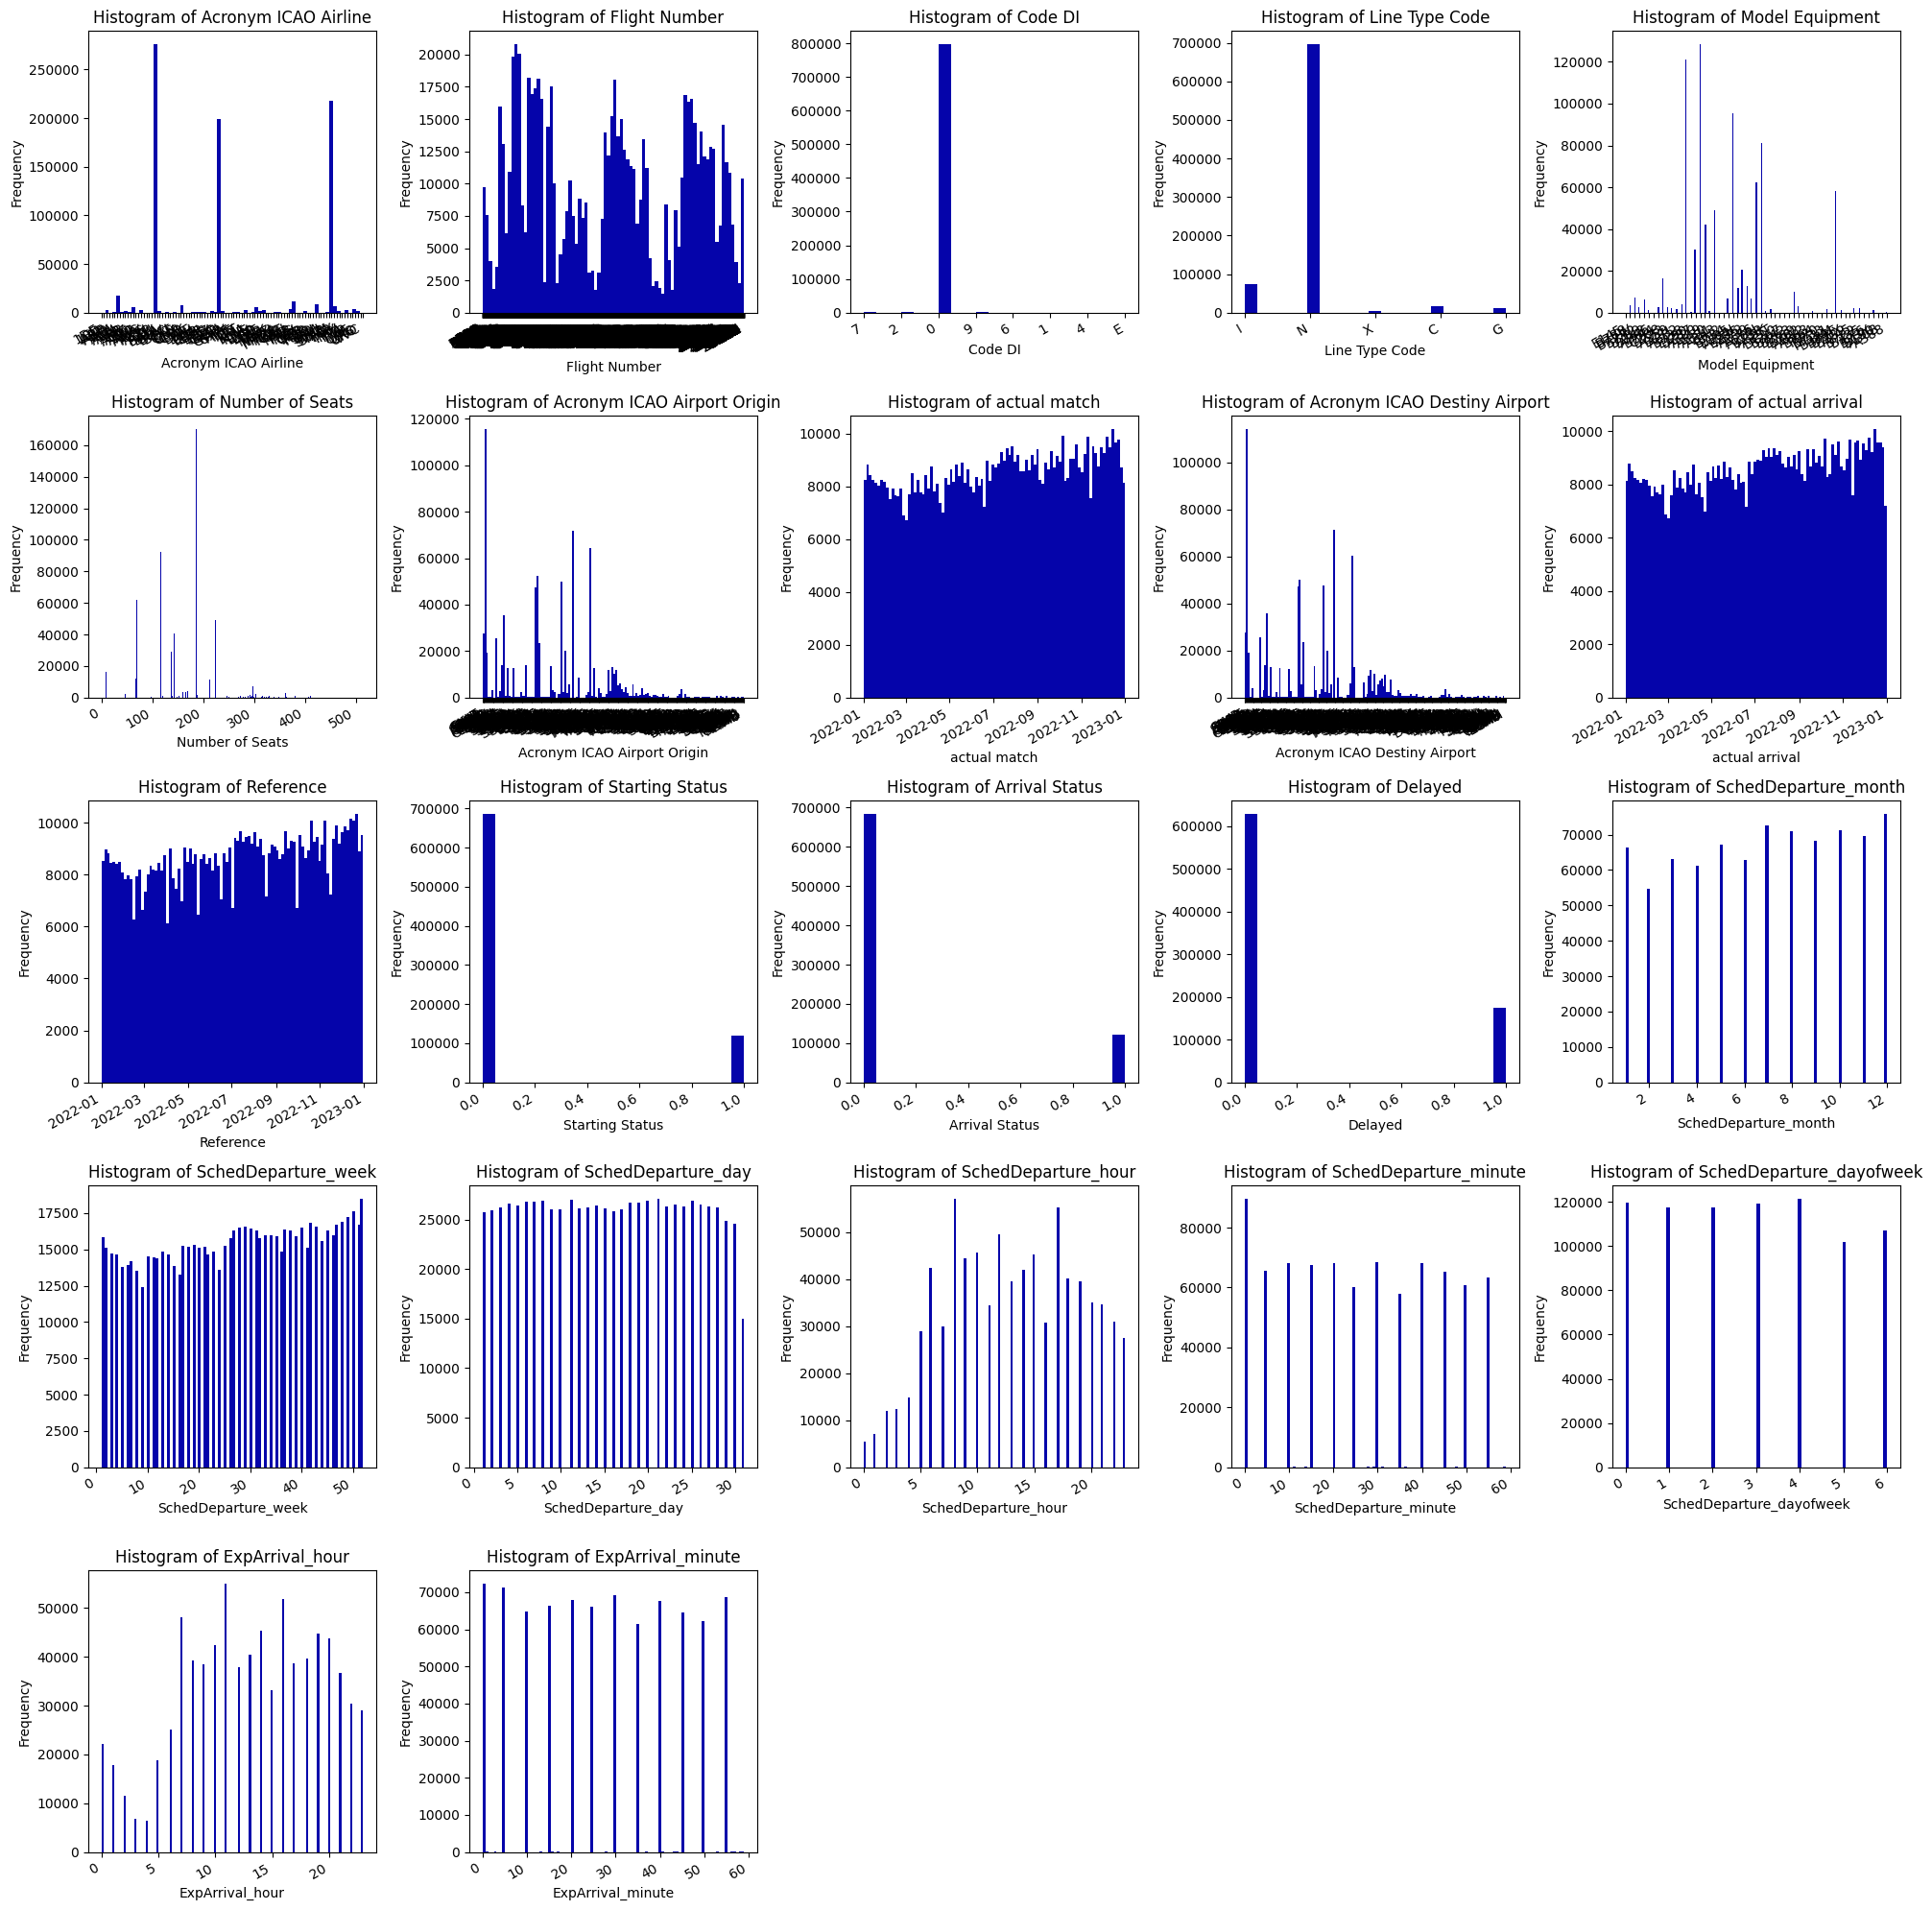

In [19]:
# Reform columns to correct data type
data_brazil4["Flight Number"] = data_brazil4["Flight Number"].astype(str)
data_brazil4["Code DI"] = data_brazil4["Code DI"].astype(str)
data_brazil4["Arrival Status"] = data_brazil4["Arrival Status"].astype(int)
data_brazil4["Starting Status"] = data_brazil4["Starting Status"].astype(int)

# Plot histograms for each column
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist(x=data_brazil4[name], bins='auto', color='#0504aa')
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

Most of the distributions are shown nicely and are really informative. For instance: it can be seen that a certain number of seats occurs a lot of times and that flights departuring in the night are less common. Further, the most frequent line type code is by far N, which represents domestic air passenger or mixed transport operations. Line type code X is not described in the dataset description, but I assume it is either unknown or a mix of multiple codes. Some of the columns like the airline and origin airport are not so clear since they have a broad scale. Therefore, the top 10 values of all columns will also be plotted in a histogram.

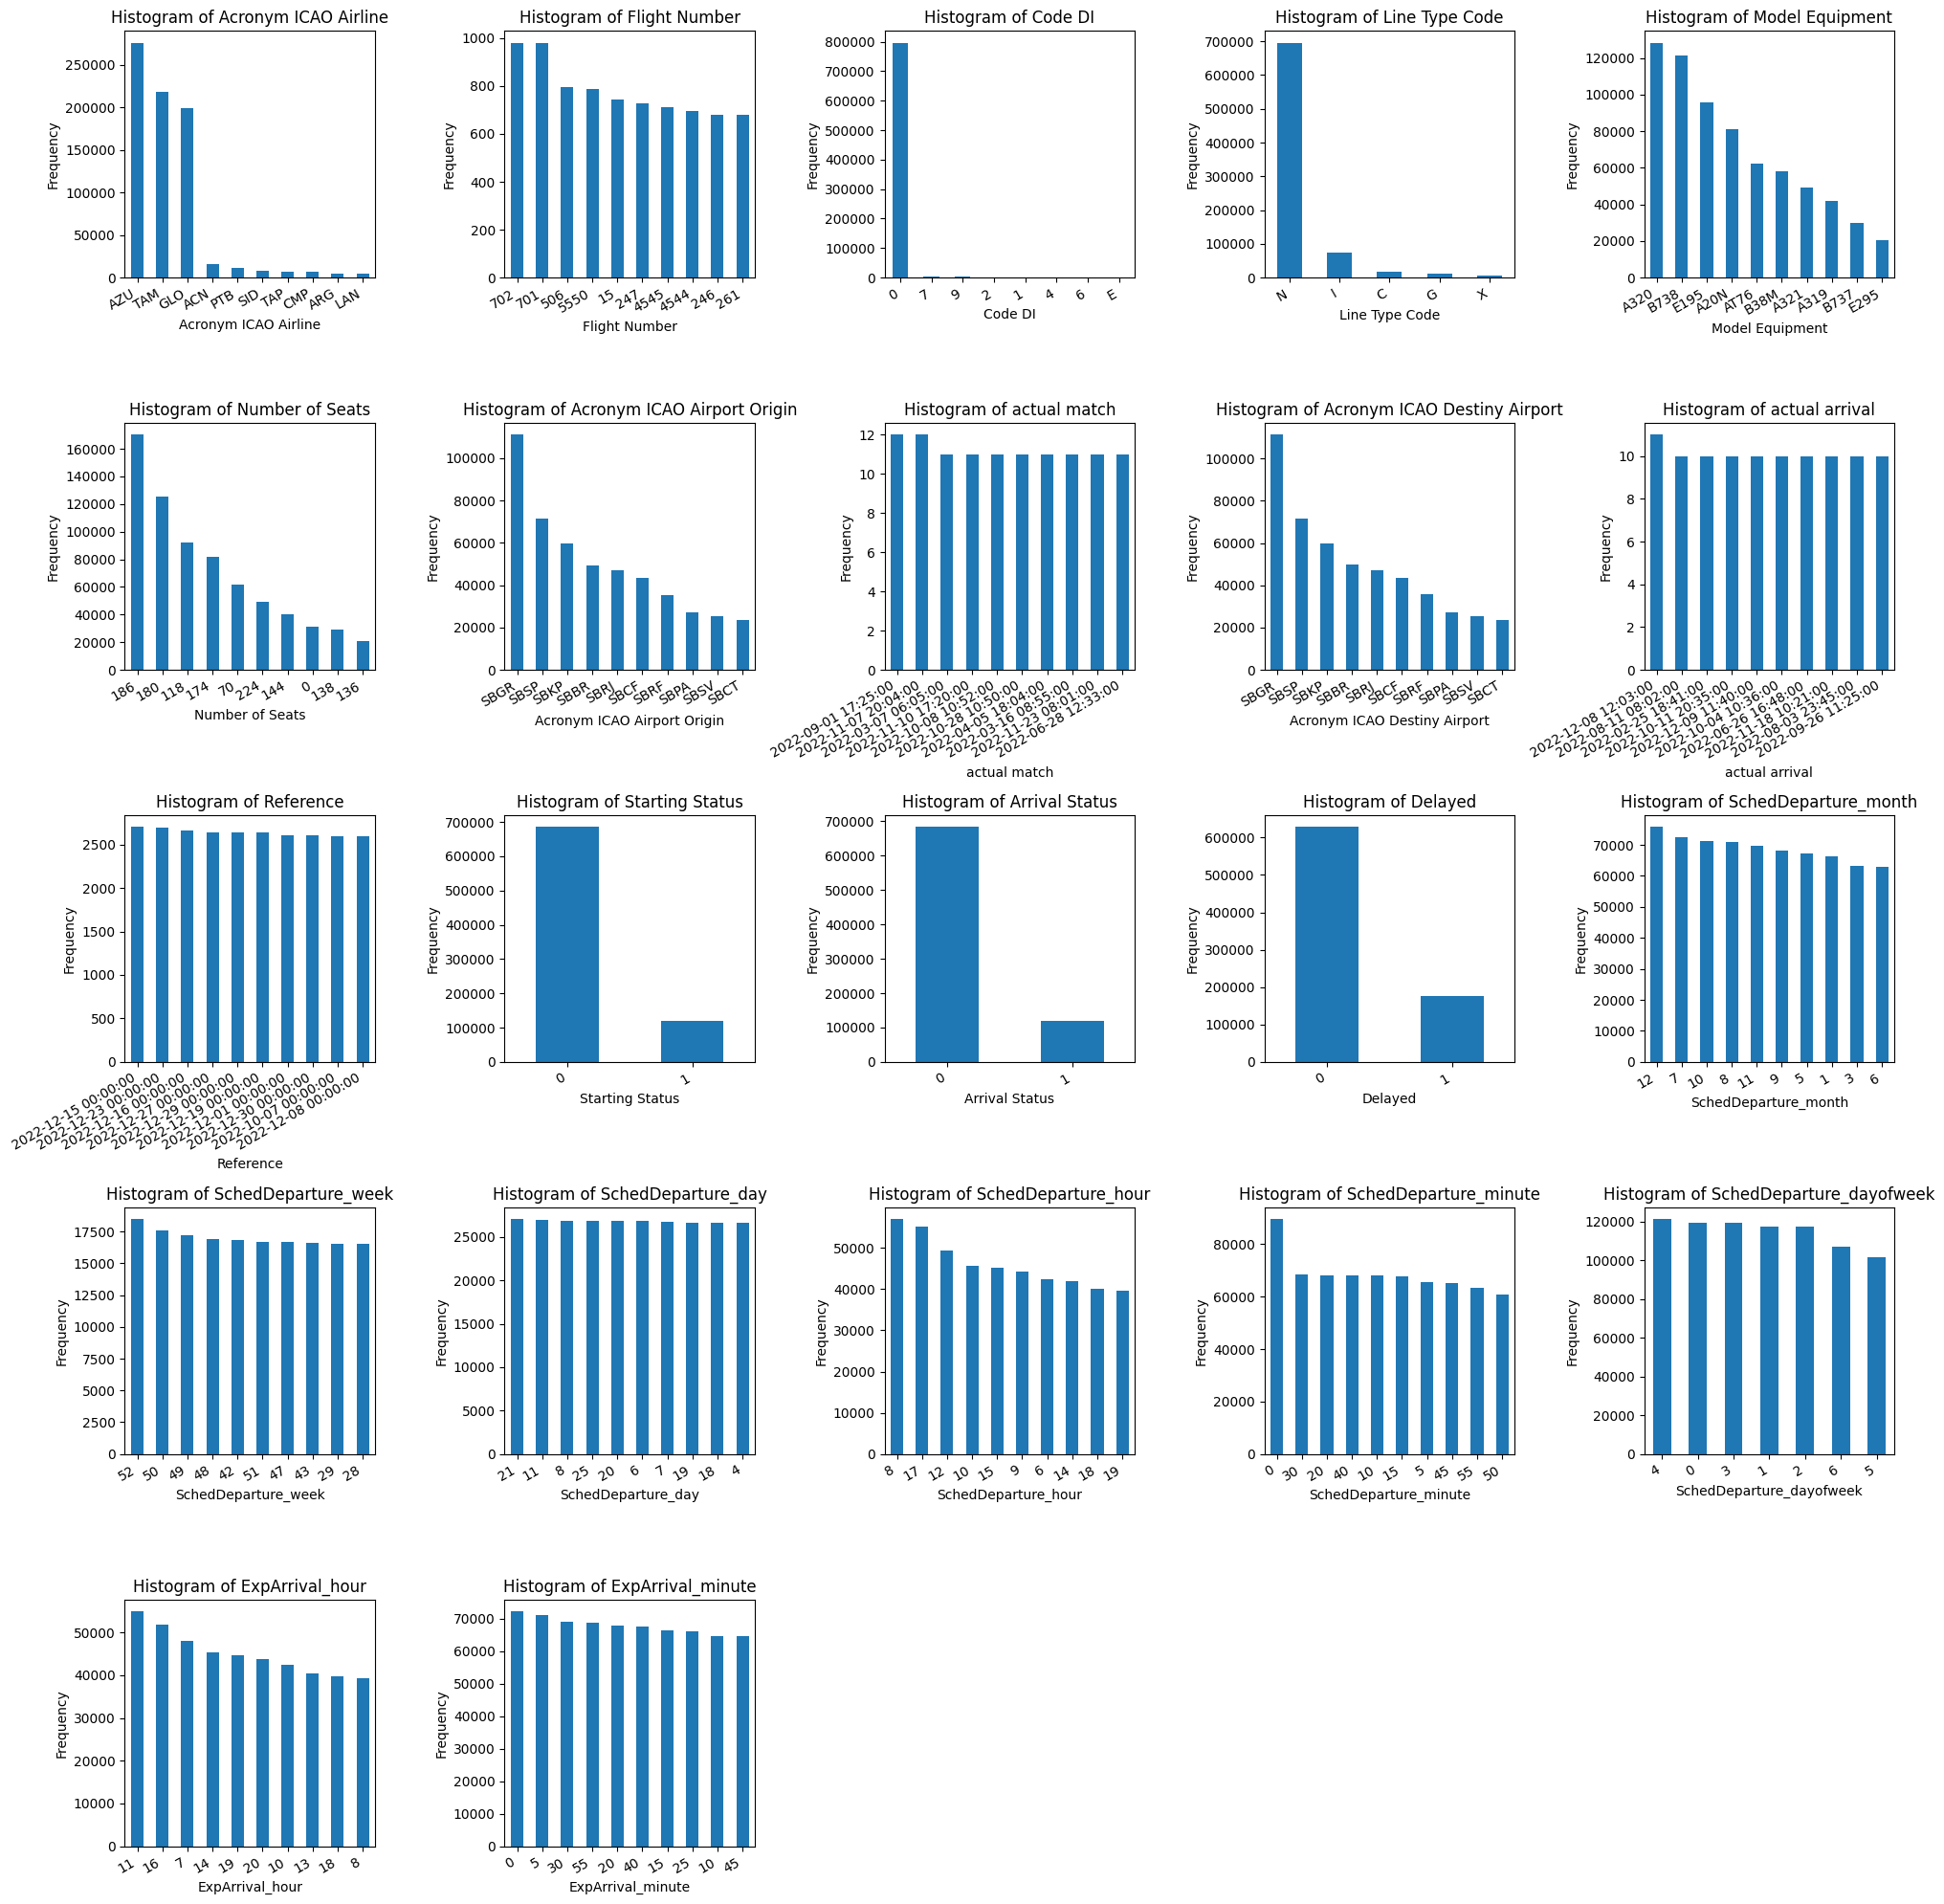

In [20]:
#  Plot histograms for each column, descending the top 10 occuring values for each column
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    data_brazil4[name].value_counts().head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

In [21]:
# Print most frequent airlines and airports full names
print("Most frequent airlines: " + airline_code_dict.get("AZU") + ", " + airline_code_dict.get("TAM") + ", and " + airline_code_dict.get("GLO"))
print("Most frequent departure and arrival airports: " + airport_code_dict.get("SBGR") + ", " + airport_code_dict.get("SBSP") + ", and " + airport_code_dict.get("SBKP"))

Most frequent airlines: AZUL LINHAS AÉREAS BRASILEIRAS S/A, TAM LINHAS AÉREAS S.A., and GOL LINHAS AÉREAS S.A. (EX- VRG LINHAS AÉREAS S.A.)
Most frequent departure and arrival airports: GUARULHOS - GOVERNOR ANDRÉ FRANCO MONTORO - GUARULHOS - SP - BRAZIL, CONGONHAS - SÃO PAULO - SP - BRAZIL, and VIRACOPOS - CAMPINAS - SP - BRAZIL


A lot more information can be gathered from these obtained histograms. It can be seen that some airlines and airports are used way more often in Brazil than others. Further, the A320 model of plane is the most common and 186/180 seats is also a popular amount for flights in Brazil.

In this study, we are interested in flight delays. Therefore, we will look at the same distributions but then with the portion of delayed flights integrated in the histograms.

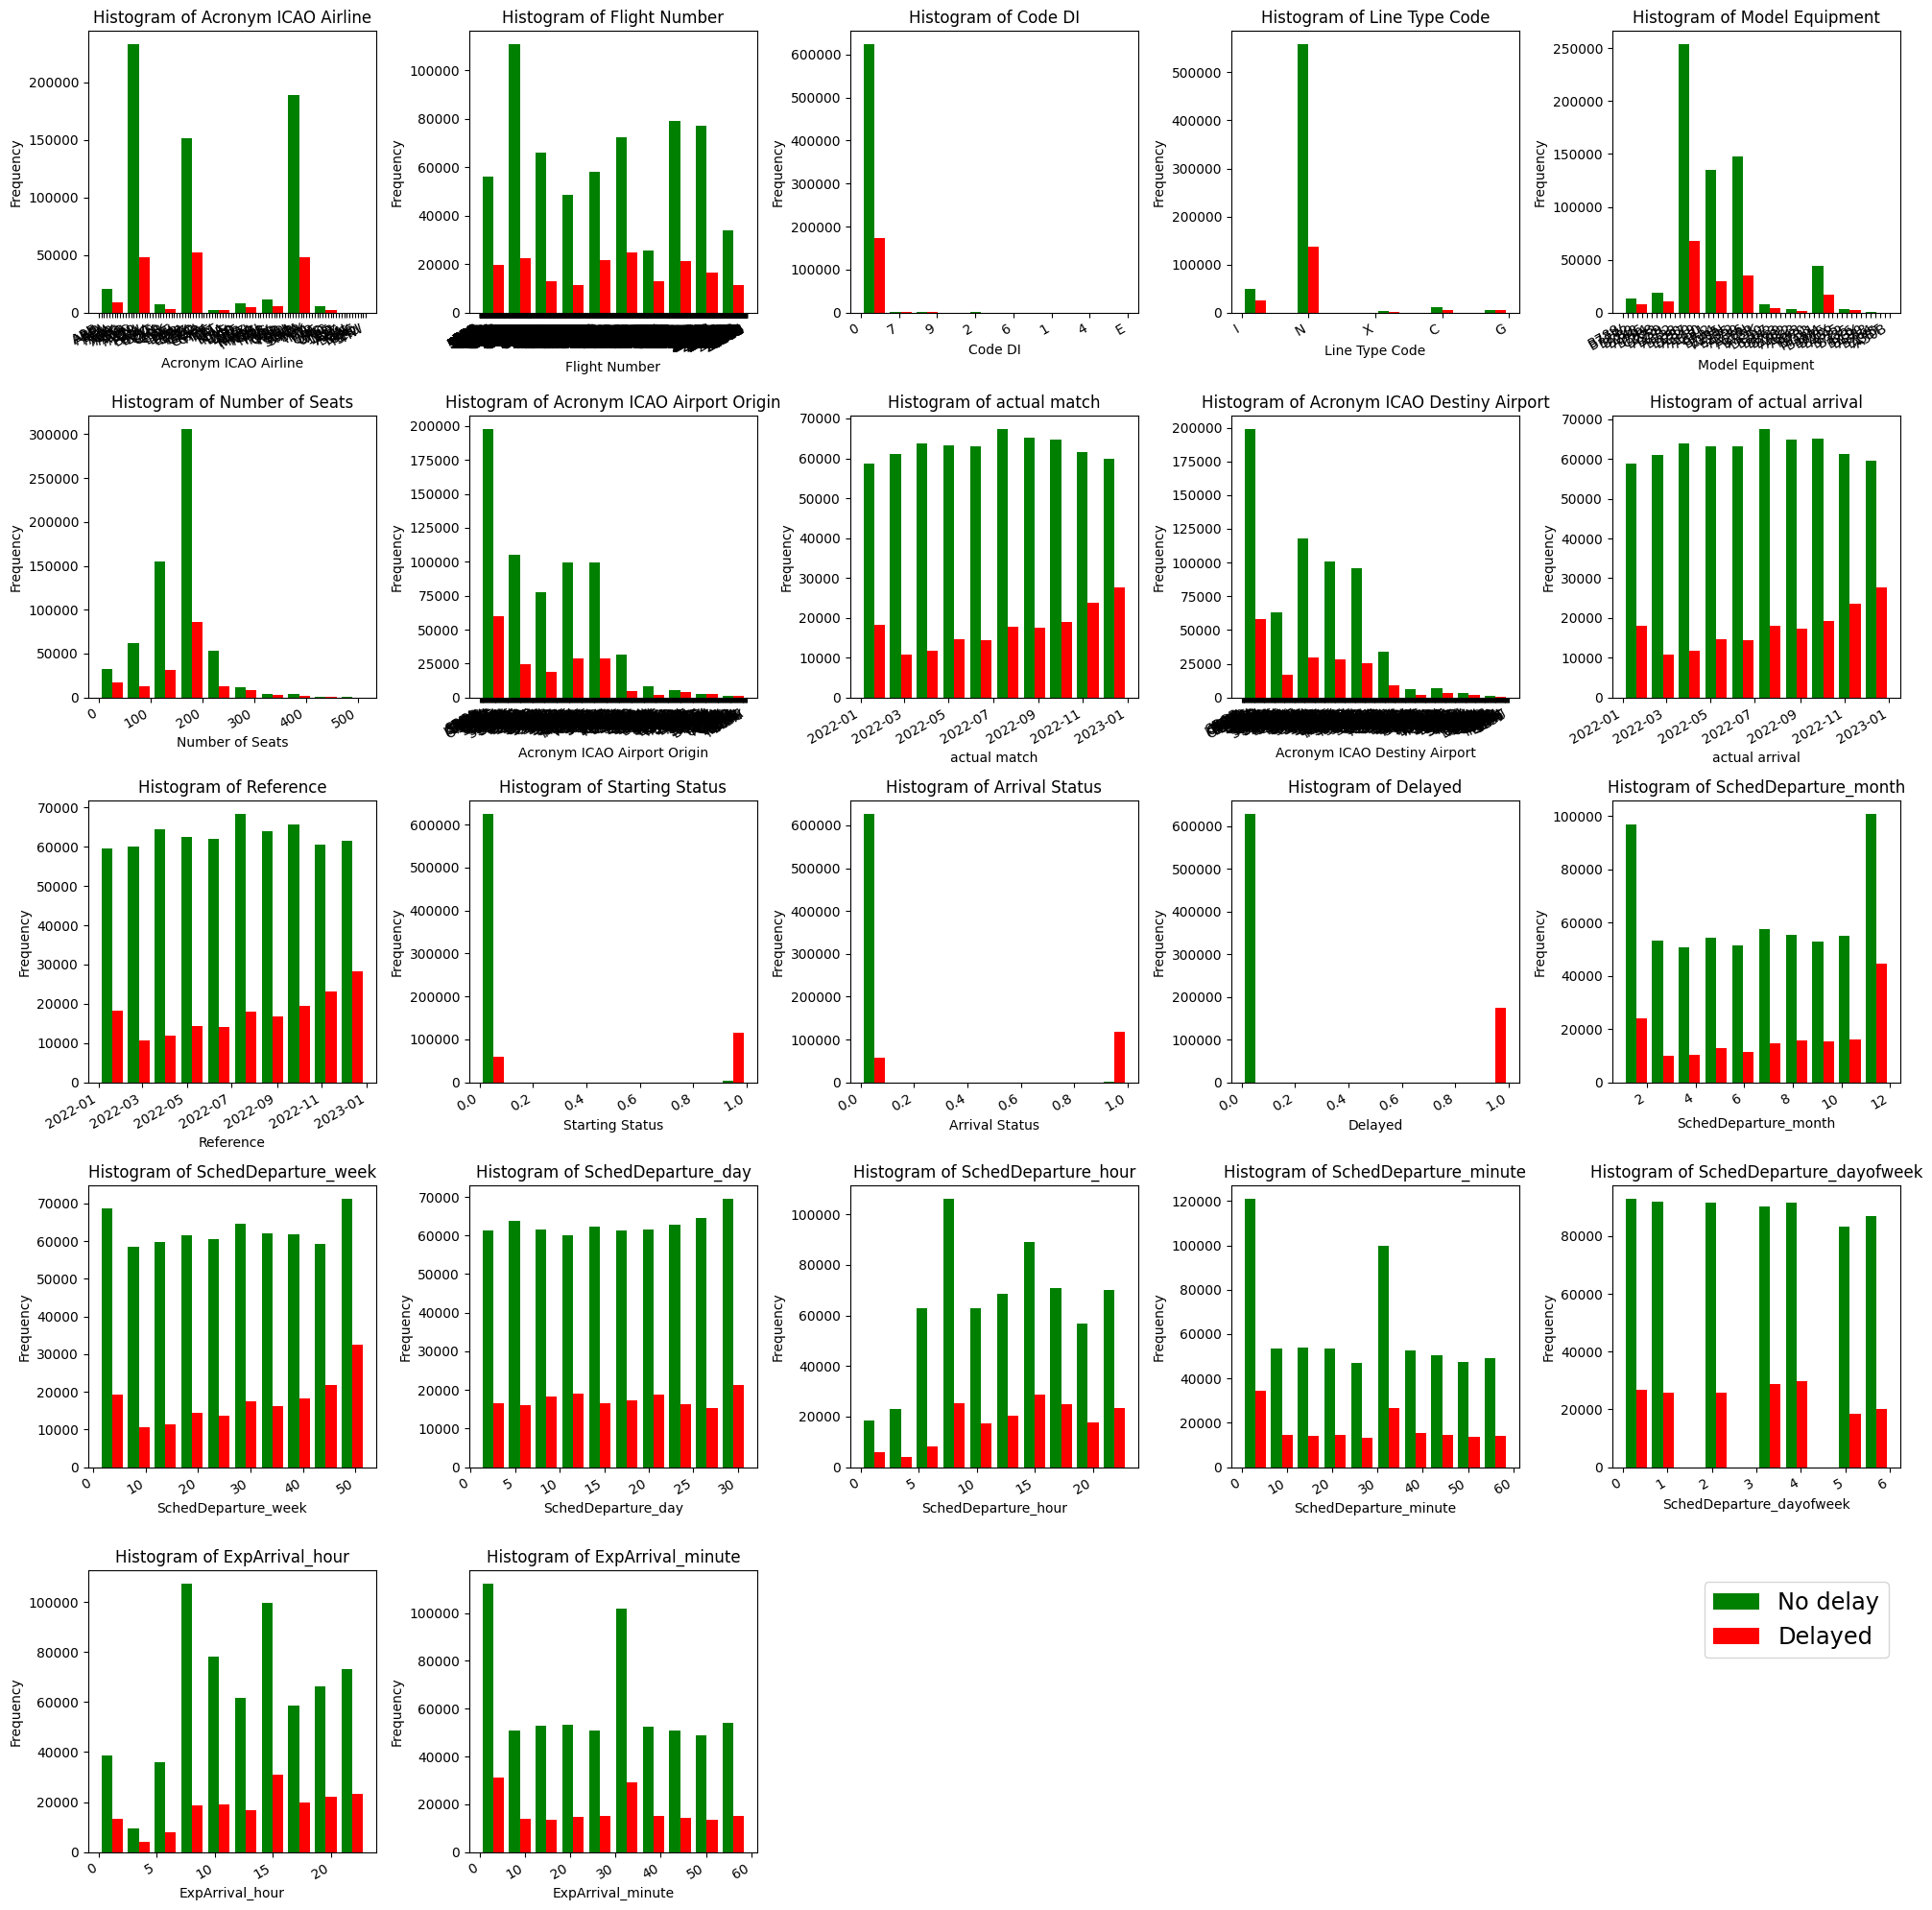

In [22]:
# Plot histograms for each column and making a separation between a delayed or non-delayed flight
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist([data_brazil4.loc[data_brazil4["Delayed"]==0, name], data_brazil4.loc[data_brazil4["Delayed"]==1, name]], color=["green", "red"], label=["No delay", "Delayed"])
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    handles, labels = axs[x,y].get_legend_handles_labels()
    y+=1
fig.tight_layout()
plt.legend(handles, labels, fontsize="xx-large")
plt.show()

The same will be done for the top 10 occuring values for each variable.

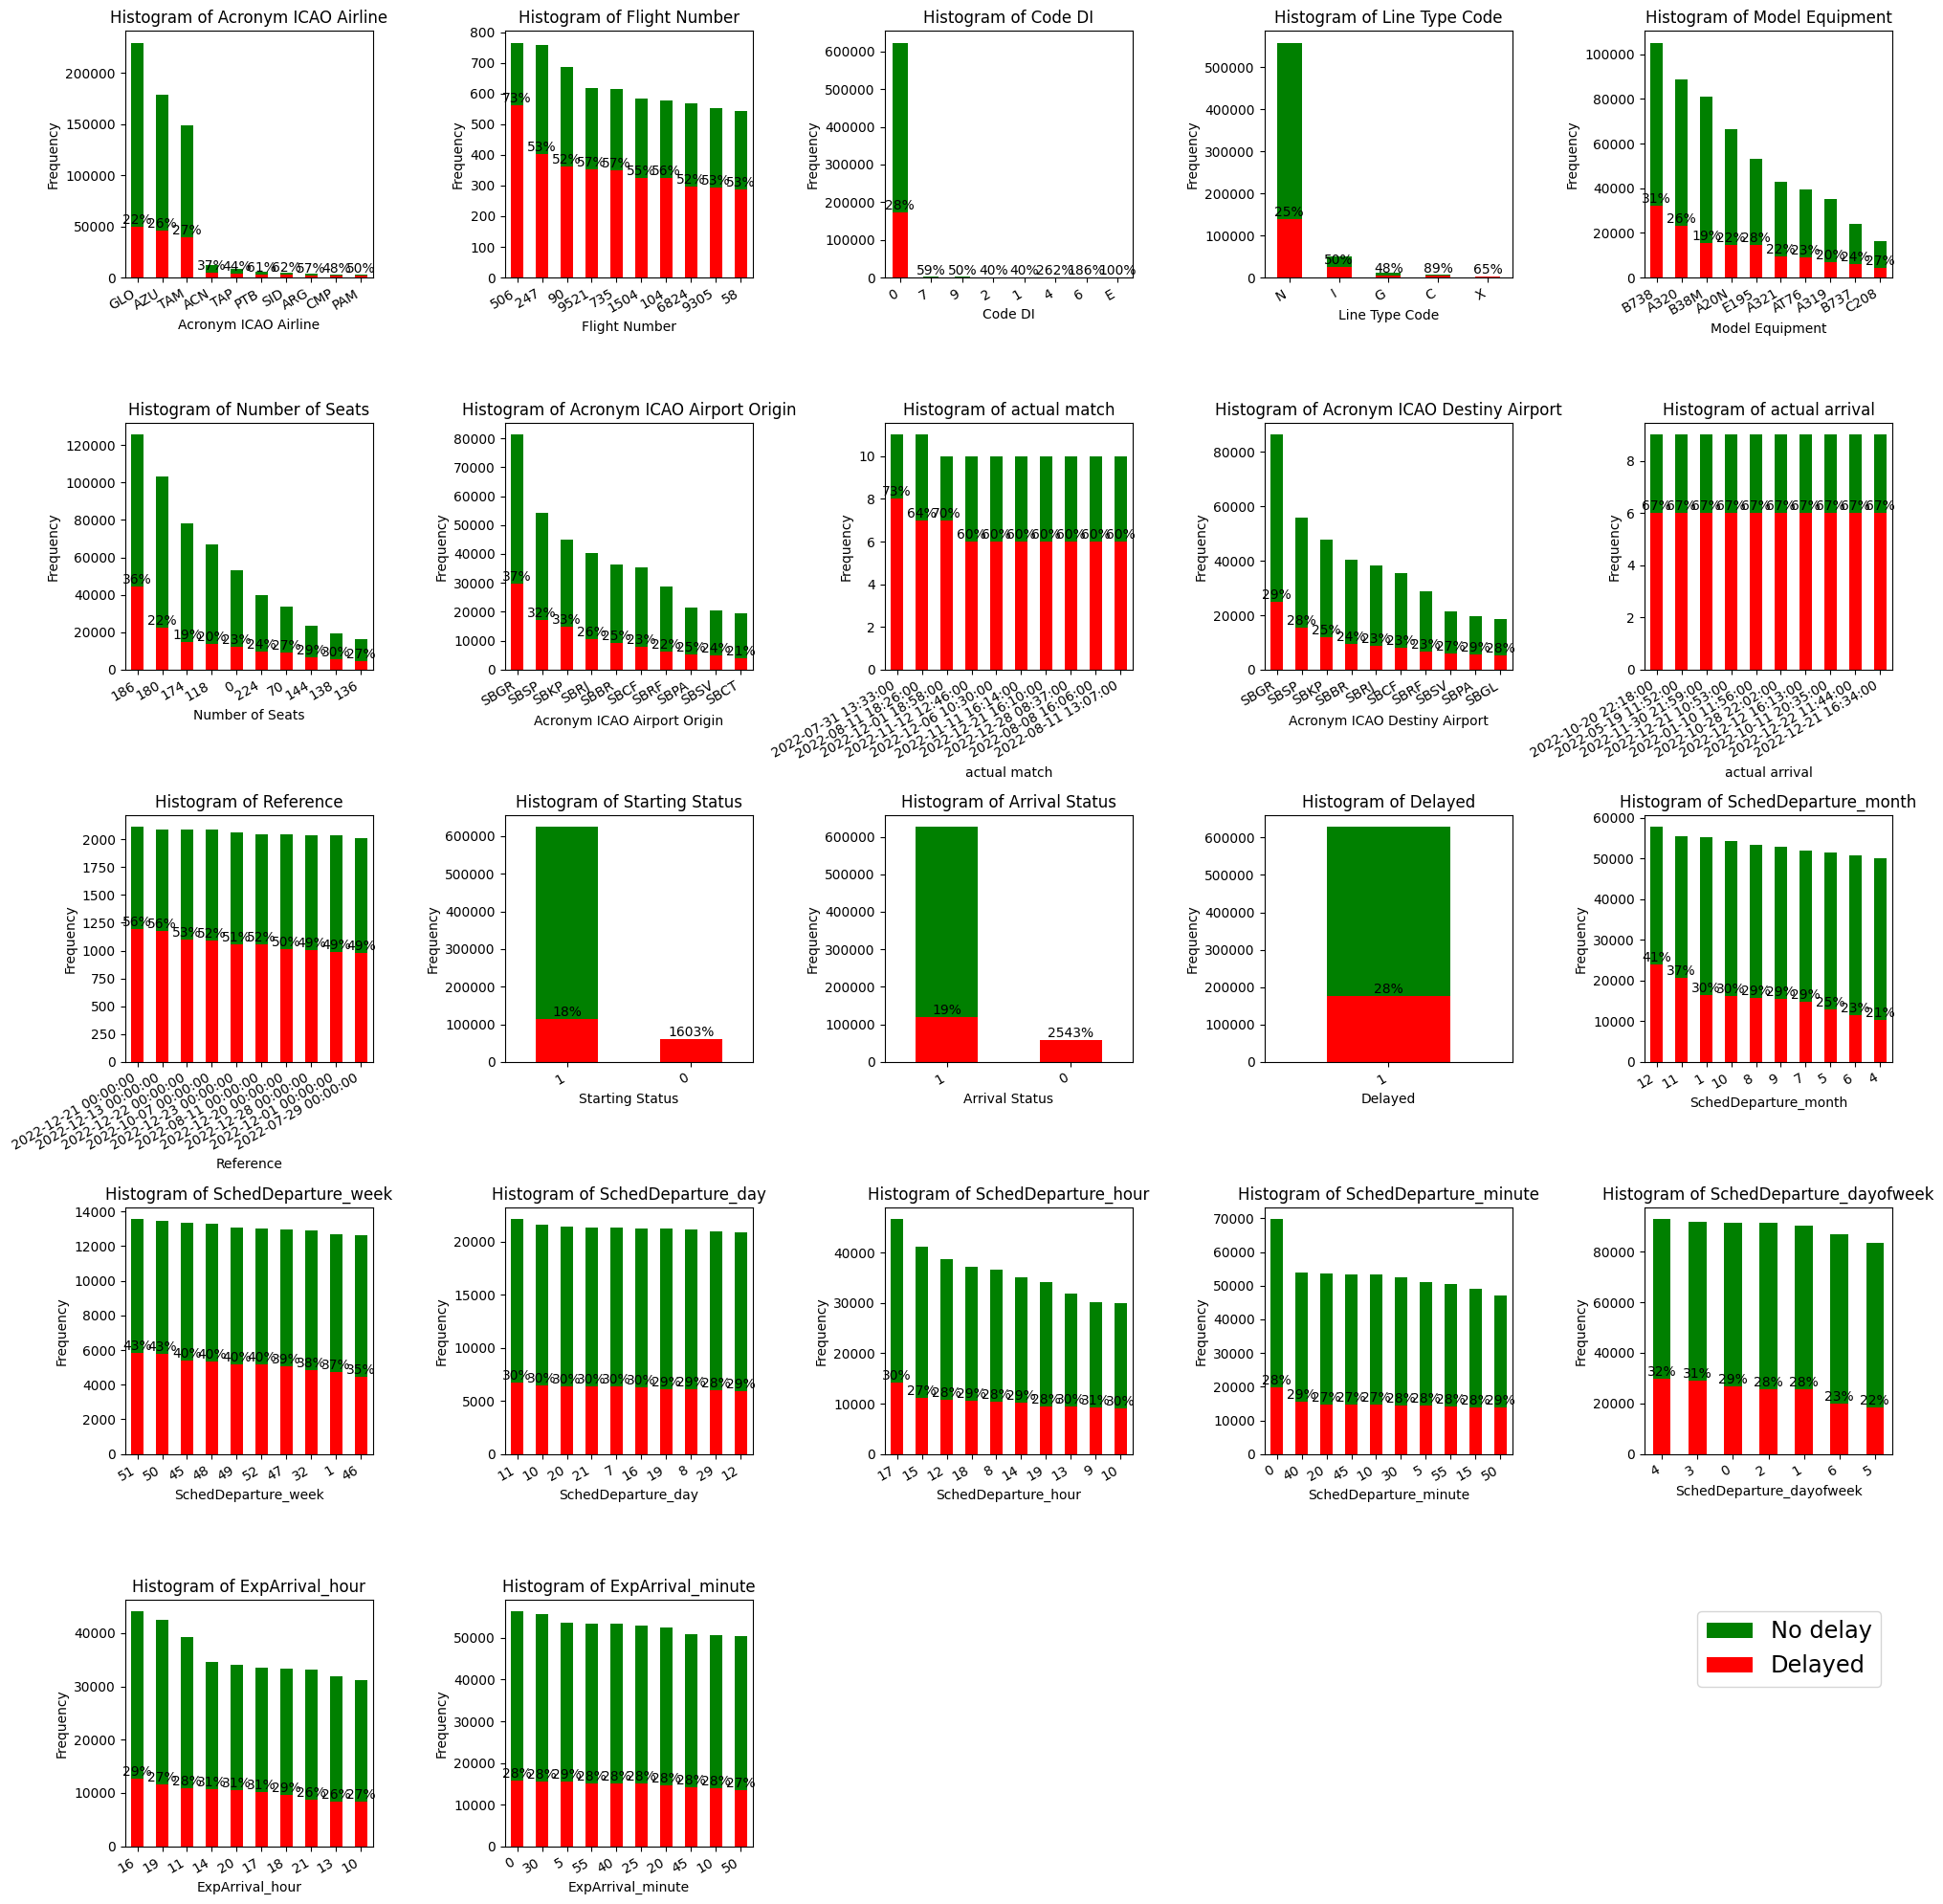

In [23]:
#  Plot histograms for each column, descending the top 10 occuring values for each column and making a separation between a delayed or non-delayed flight
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    data_brazil4.loc[data_brazil4["Delayed"]==0, name].value_counts().head(10).plot(kind='bar', ax=axs[x,y], color='green', label="No delay")
    data_brazil4.loc[data_brazil4["Delayed"]==1, name].value_counts().head(10).plot(kind='bar', ax=axs[x,y], color='red', label="Delayed")
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    handles, labels = axs[x,y].get_legend_handles_labels()
    axs[x,y].bar_label(axs[x,y].containers[1], labels=[f'{item/axs[x,y].containers[0].datavalues[i]*100:.0f}%' for i, item in enumerate(axs[x,y].containers[1].datavalues)])
    y+=1
fig.tight_layout()
plt.legend(handles, labels, fontsize="xx-large")
plt.show()

From the new histograms that take our response variable into account, we can see that the B738 experiences a lot more delays than the other airplanes. We will also create boxplots to identify outliers and to create another way of looking at numerical data.

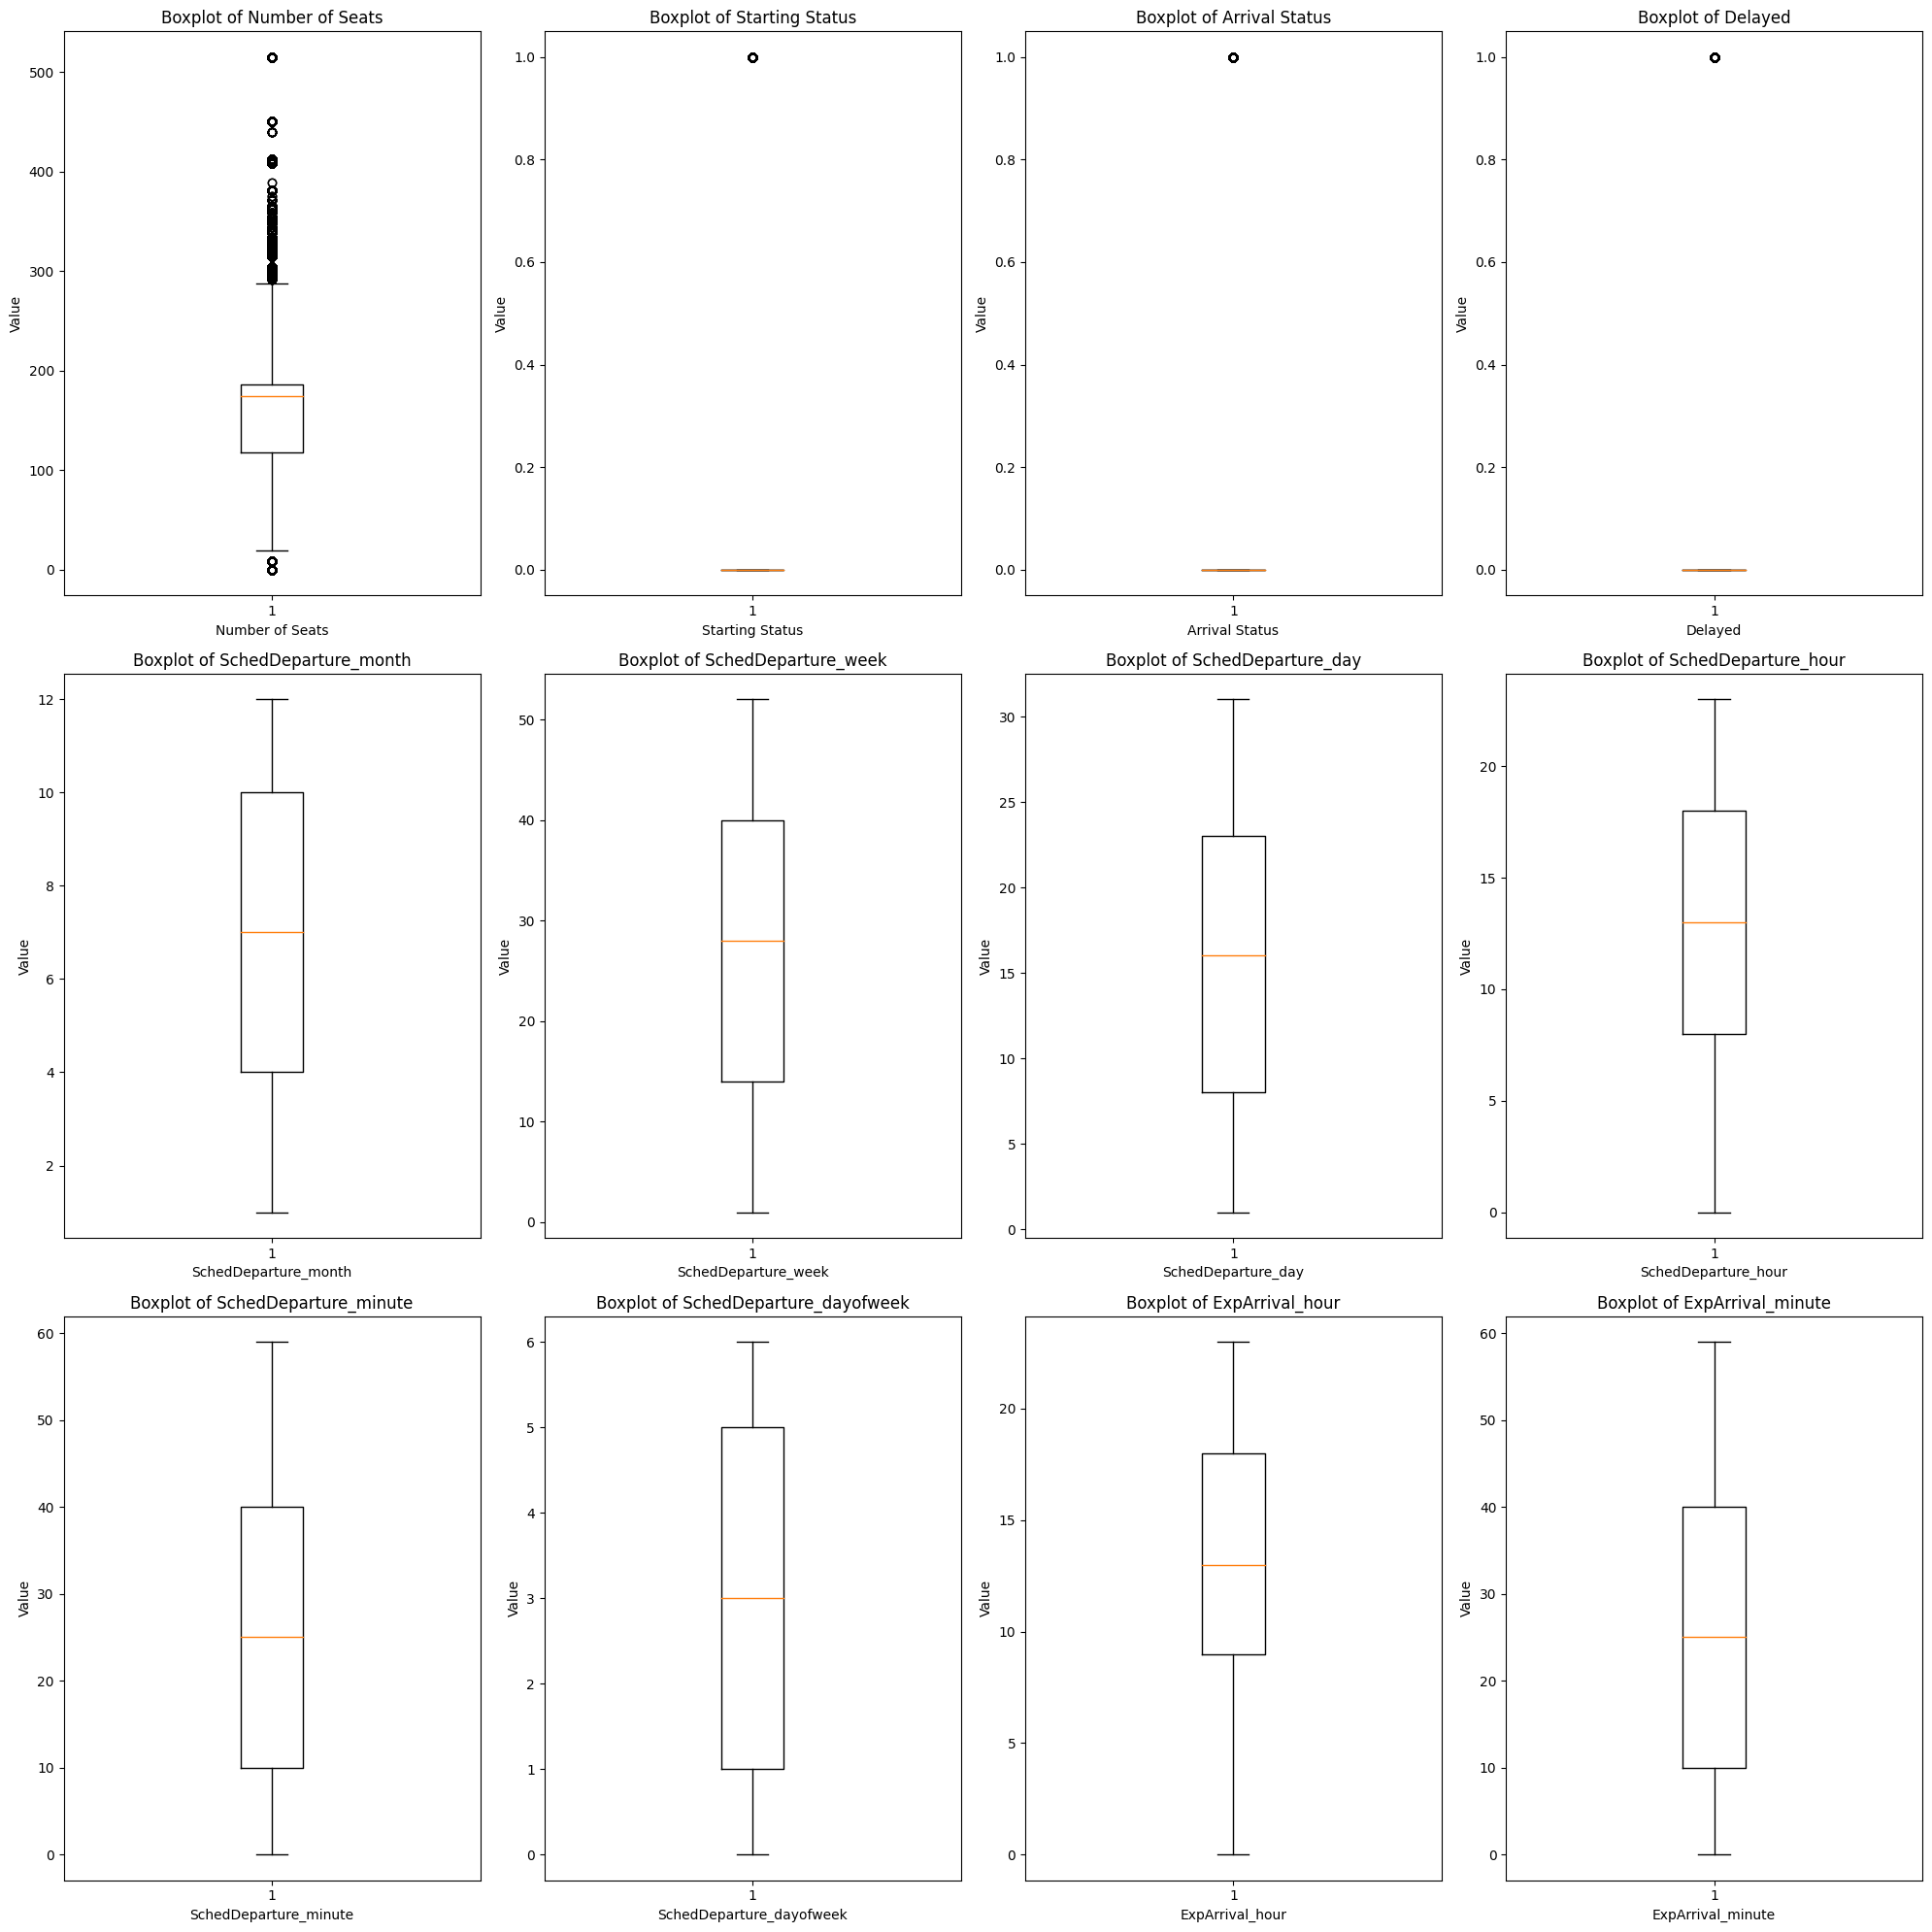

In [24]:
# Plot boxplots for numeric columns
fig, axs = plt.subplots(3,4, figsize=(20,20))
x = 0; y=0; count=0
for i, name in enumerate(data_brazil4.columns.values):
    if is_numeric_dtype(data_brazil4[name]):
        if count % 4 == 0 and count != 0:
            x += 1
            y = 0
        axs[x,y].boxplot(x=data_brazil4[name])
        axs[x,y].set(xlabel=name, ylabel="Value")
        axs[x,y].set_title("Boxplot of " + name)
        count +=1
        y += 1
fig.tight_layout()
plt.show()

From the histograms and boxplots, the distribution of each column is clearly visible. We can see that the 'Code DI' column is higly zero-inflated, and therefore seems to be redundant. The column will be removed because of this. It represents the type of authorization for each flight step and doesn't seem to have lots of effect on a delay. There are a lot of outliers visible in the number of seats column, but these won't get removed since there are planes with 0 seats (cargo planes) and with 500 seats (A388). 

In [25]:
# Drop Code DI column as it is highly zero-inflated
data_brazil4.drop(columns=['Code DI'], inplace=True)

Before going to feature selection, the columns 'actual match' and 'actual arrival' will be removed since this information is not known prior to the flight, and the prediction will be done prior to the flight. The 'Reference' column will also be removed, as the date can be derived from the 'Scheduled departure' fields.

In [118]:
# Remove columns that are unavailable at time of prediction
data_brazil5 = data_brazil4.drop(columns=['actual match', 'actual arrival', 'Reference'])

# Create copies of dataset to use for feature selection and ML algorithms
data_brazil_fs = data_brazil4.drop(columns=['actual match', 'actual arrival', 'Reference'])
data_brazil_ml = data_brazil4.drop(columns=['actual match', 'actual arrival', 'Reference'])

To have a better look at the proportion of delayed flights per value in each column, the proportions are plotted in a histogram. The top 10 values for each column with the highest proportion of delayed flights are plotted to get a better look at which factors caused delays in the flights of this data set.

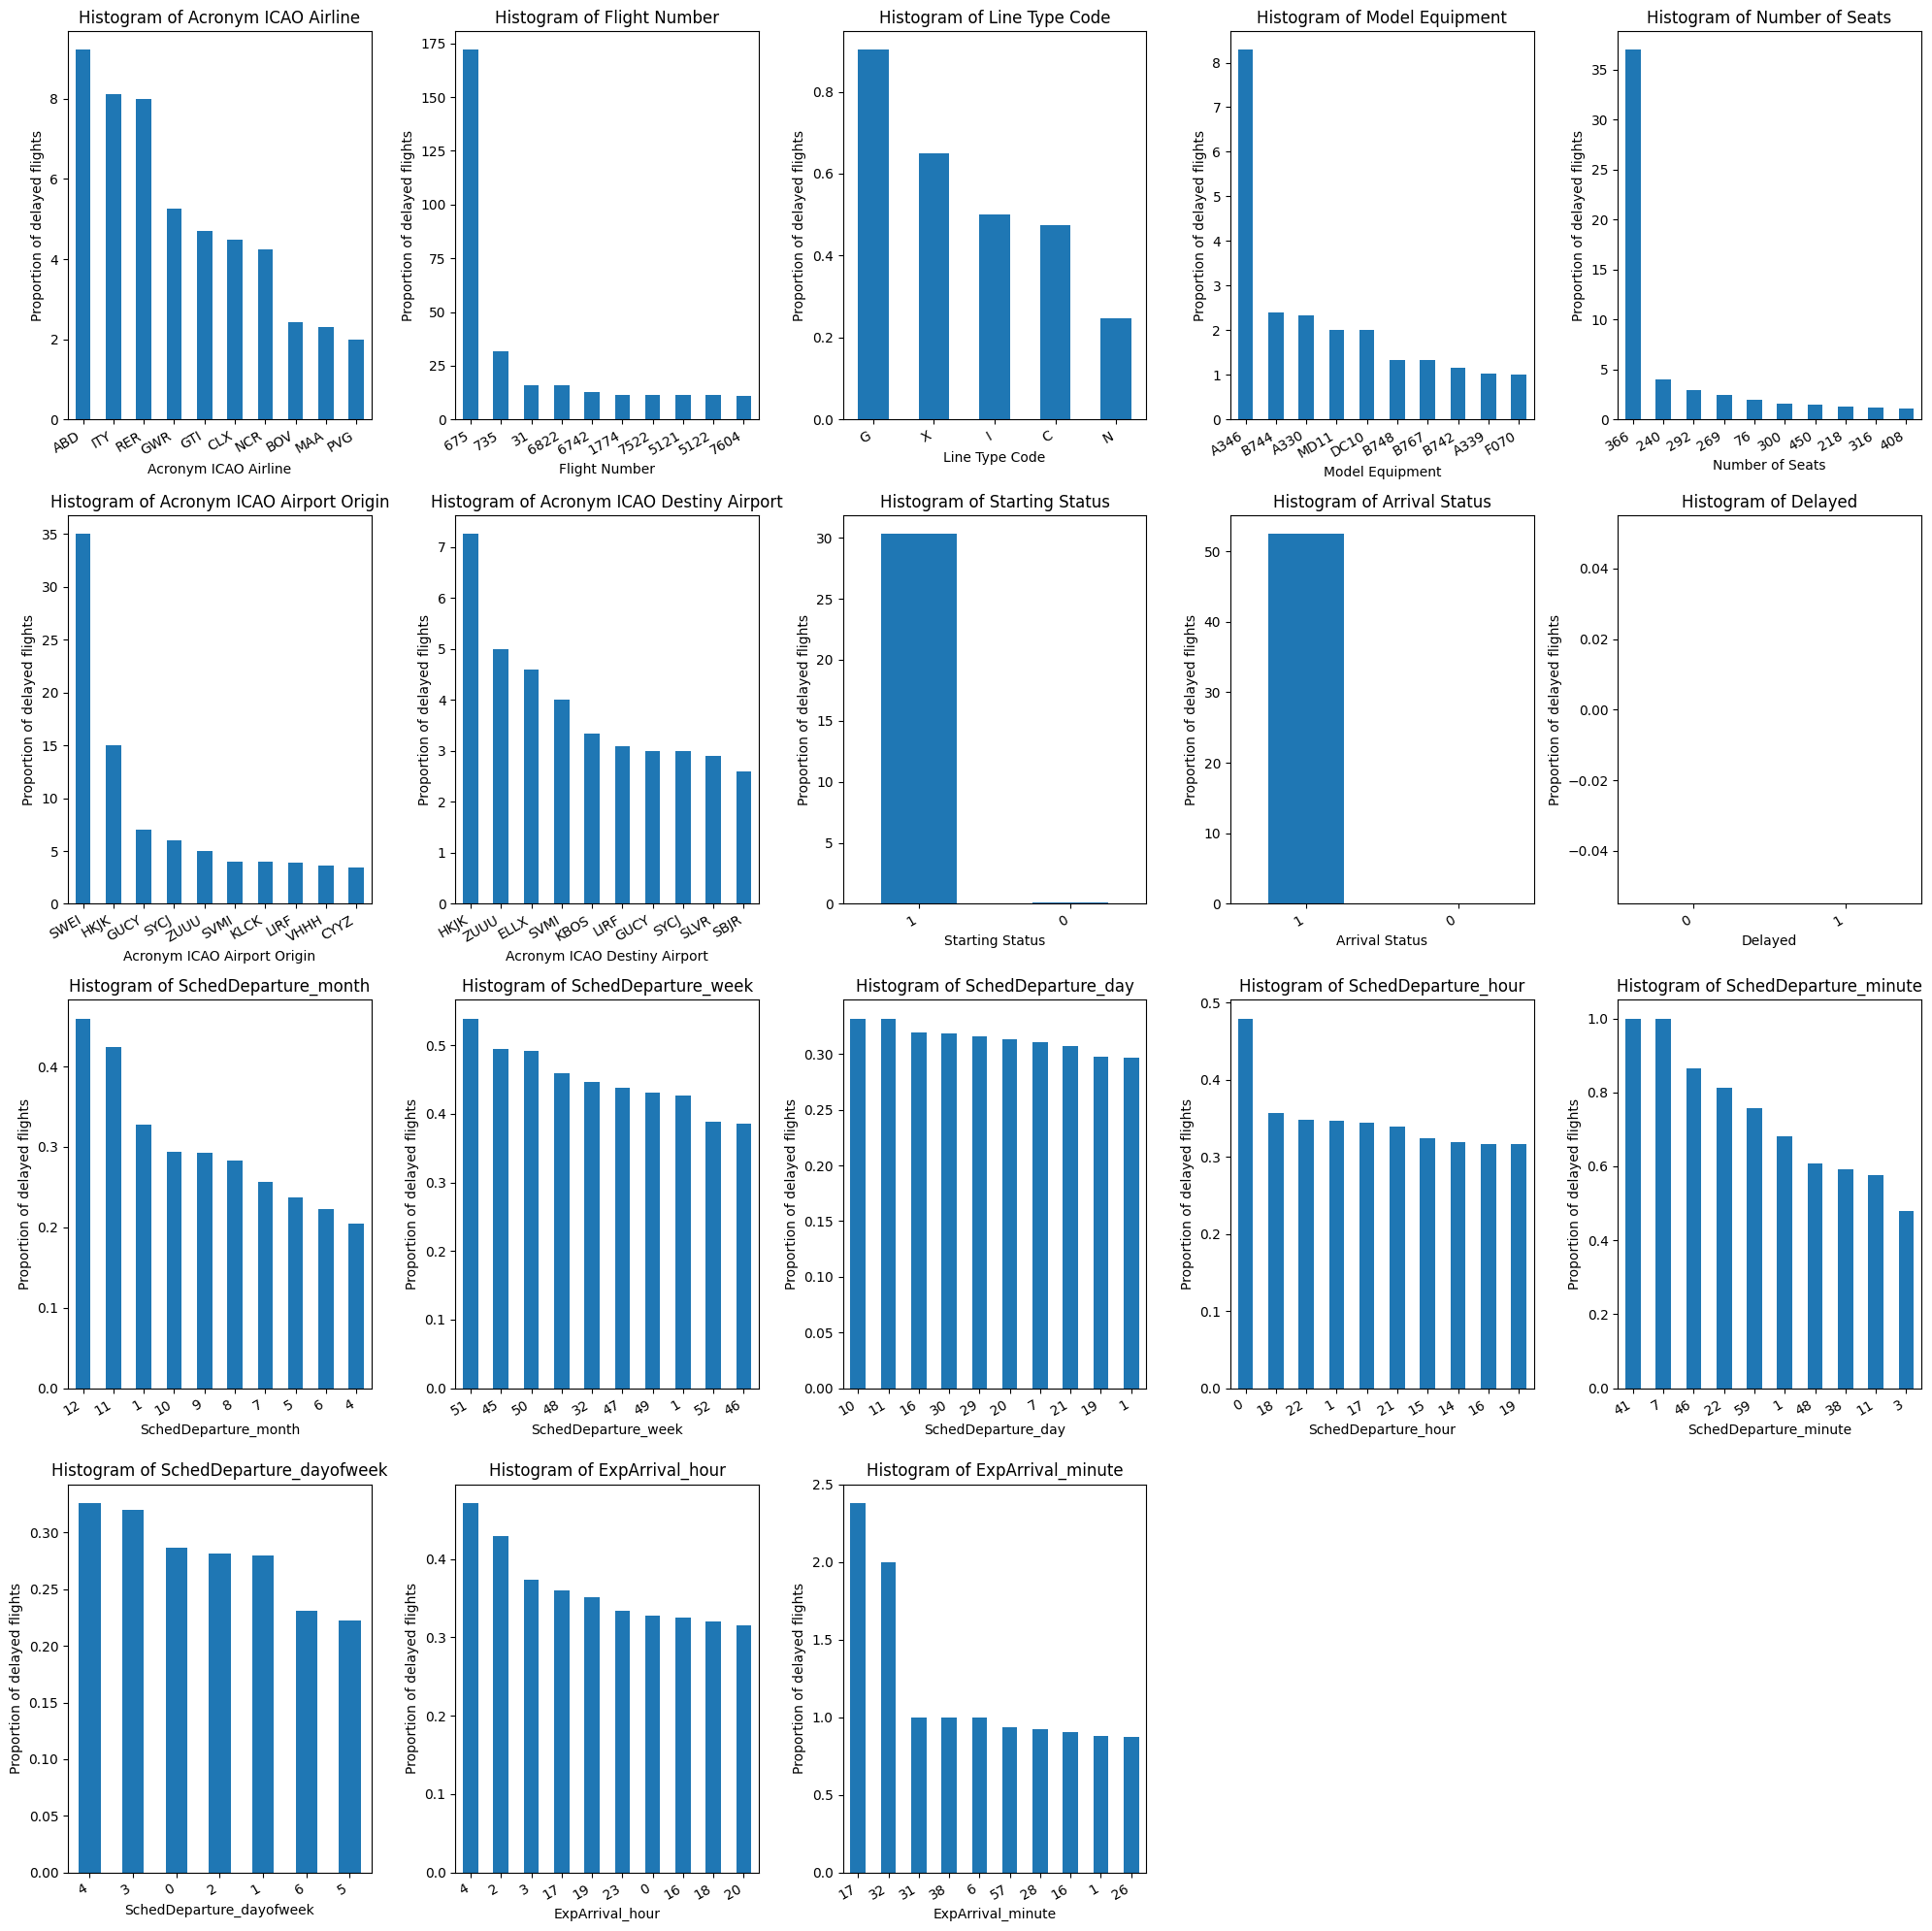

In [119]:
# Look per column for highest proportion of delayed flights for certain value
no_delay = data_brazil5[data_brazil5["Delayed"]==0]
delayed = data_brazil5[data_brazil5["Delayed"]==1]

fig, axs = plt.subplots(4,5, figsize=(20,20))
axs[3,3].axis('off')
axs[3,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil5.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    (delayed[name].value_counts() / no_delay[name].value_counts()).sort_values(ascending=False).head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Proportion of delayed flights")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

It is visible that for instance flights on a thursday or friday are far more likely to be delayed, wehereas certain air carriers even have more delayed flights than non-delayed flights. To see which factors ensure the least amount of delayed flights, a histogram has been plotted with the lowest 10 proportions of delayed flights for each column value.

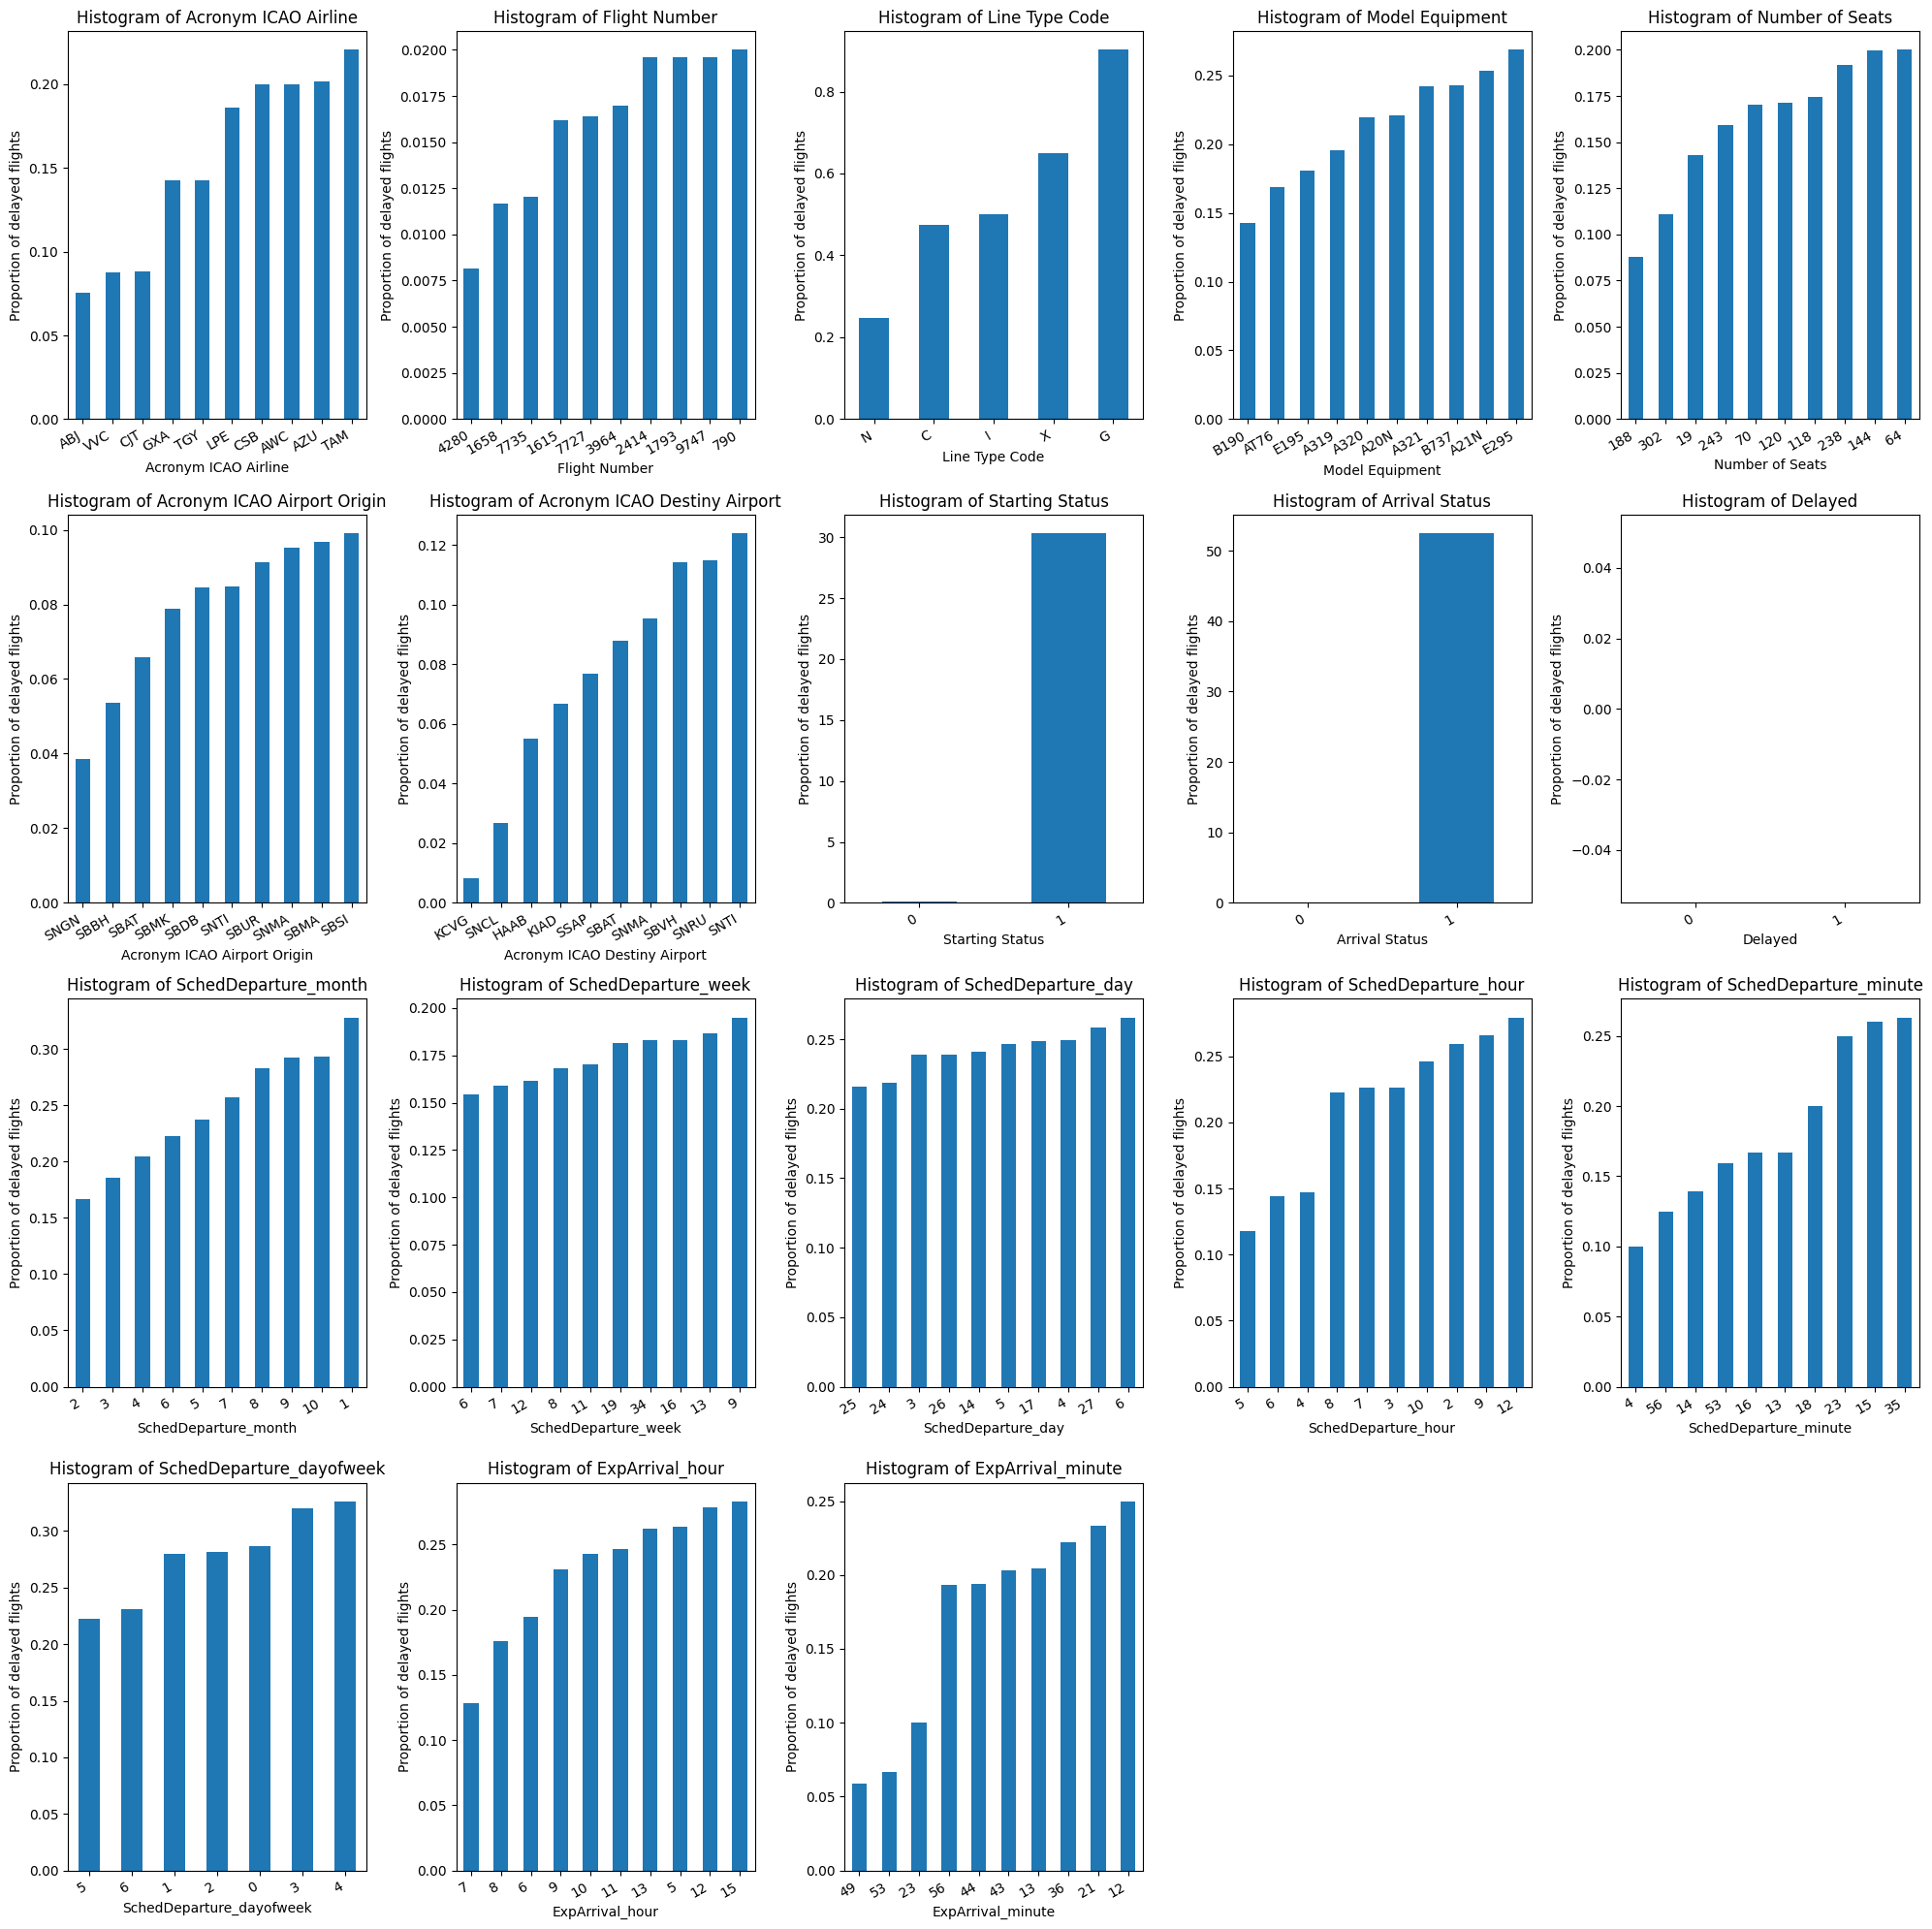

In [28]:
# Look per column for lowest proportion of delayed flights for certain value
no_delay = data_brazil5[data_brazil5["Delayed"]==0]
delayed = data_brazil5[data_brazil5["Delayed"]==1]

fig, axs = plt.subplots(4,5, figsize=(20,20))
axs[3,3].axis('off')
axs[3,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil5.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    (delayed[name].value_counts() / no_delay[name].value_counts()).sort_values(ascending=True).head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Proportion of delayed flights")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

From these histograms, it can be seen that early flights are less likely to get delayed. Further, it seems like some airplane models have a really low proportion of delayed flights, but this could also be caused by the fact that they only had a few flights.

#### 2.4 Feature selection
We will now have a look at which features seem to be the most important for our problem. Firstly, to visualize the correlations between variables, a heatmap is created. This is done in order to detect high collinearity in our model.

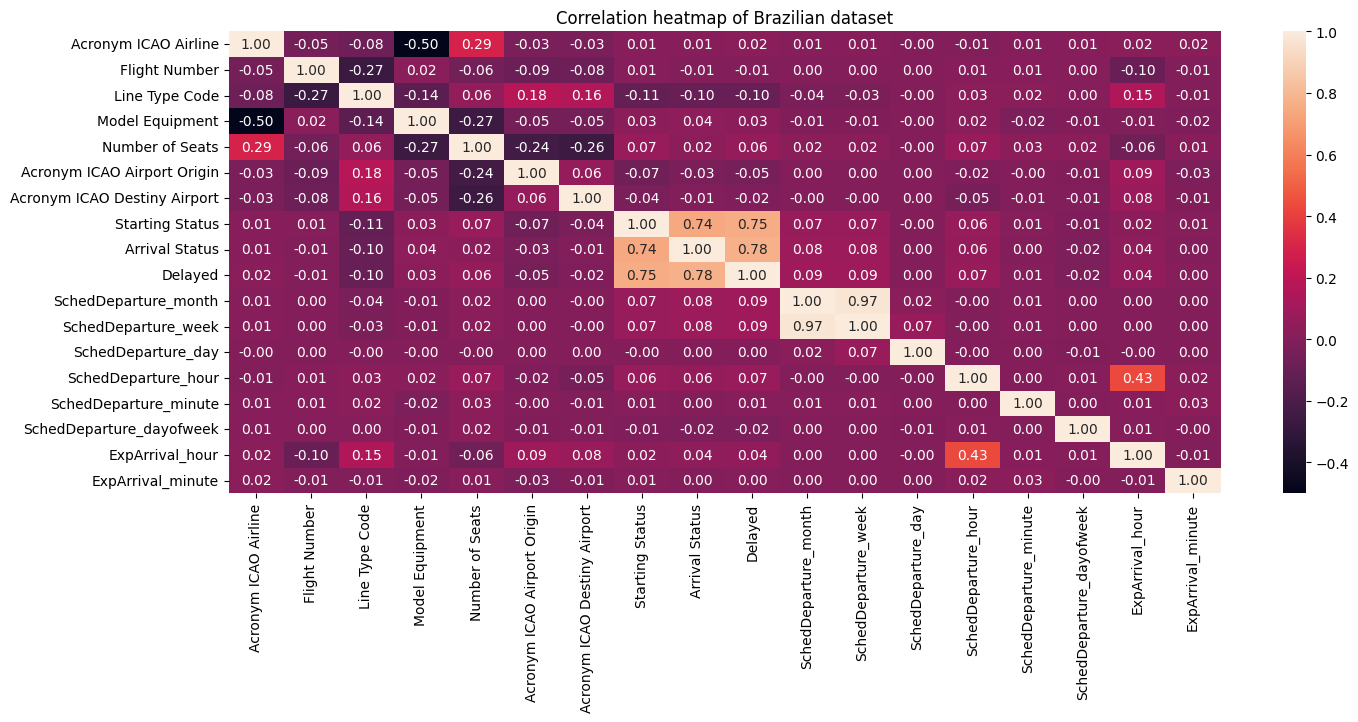

In [120]:
# Create correlation heatmap
for name in data_brazil5.columns.values:
    data_brazil5[name] = data_brazil5[name].astype('category').cat.codes
plt.figure(figsize=(16, 6))
plt.title("Correlation heatmap of Brazilian dataset")
heatmap = sns.heatmap(data_brazil5.corr(), annot=True, fmt=".2f")
plt.show()

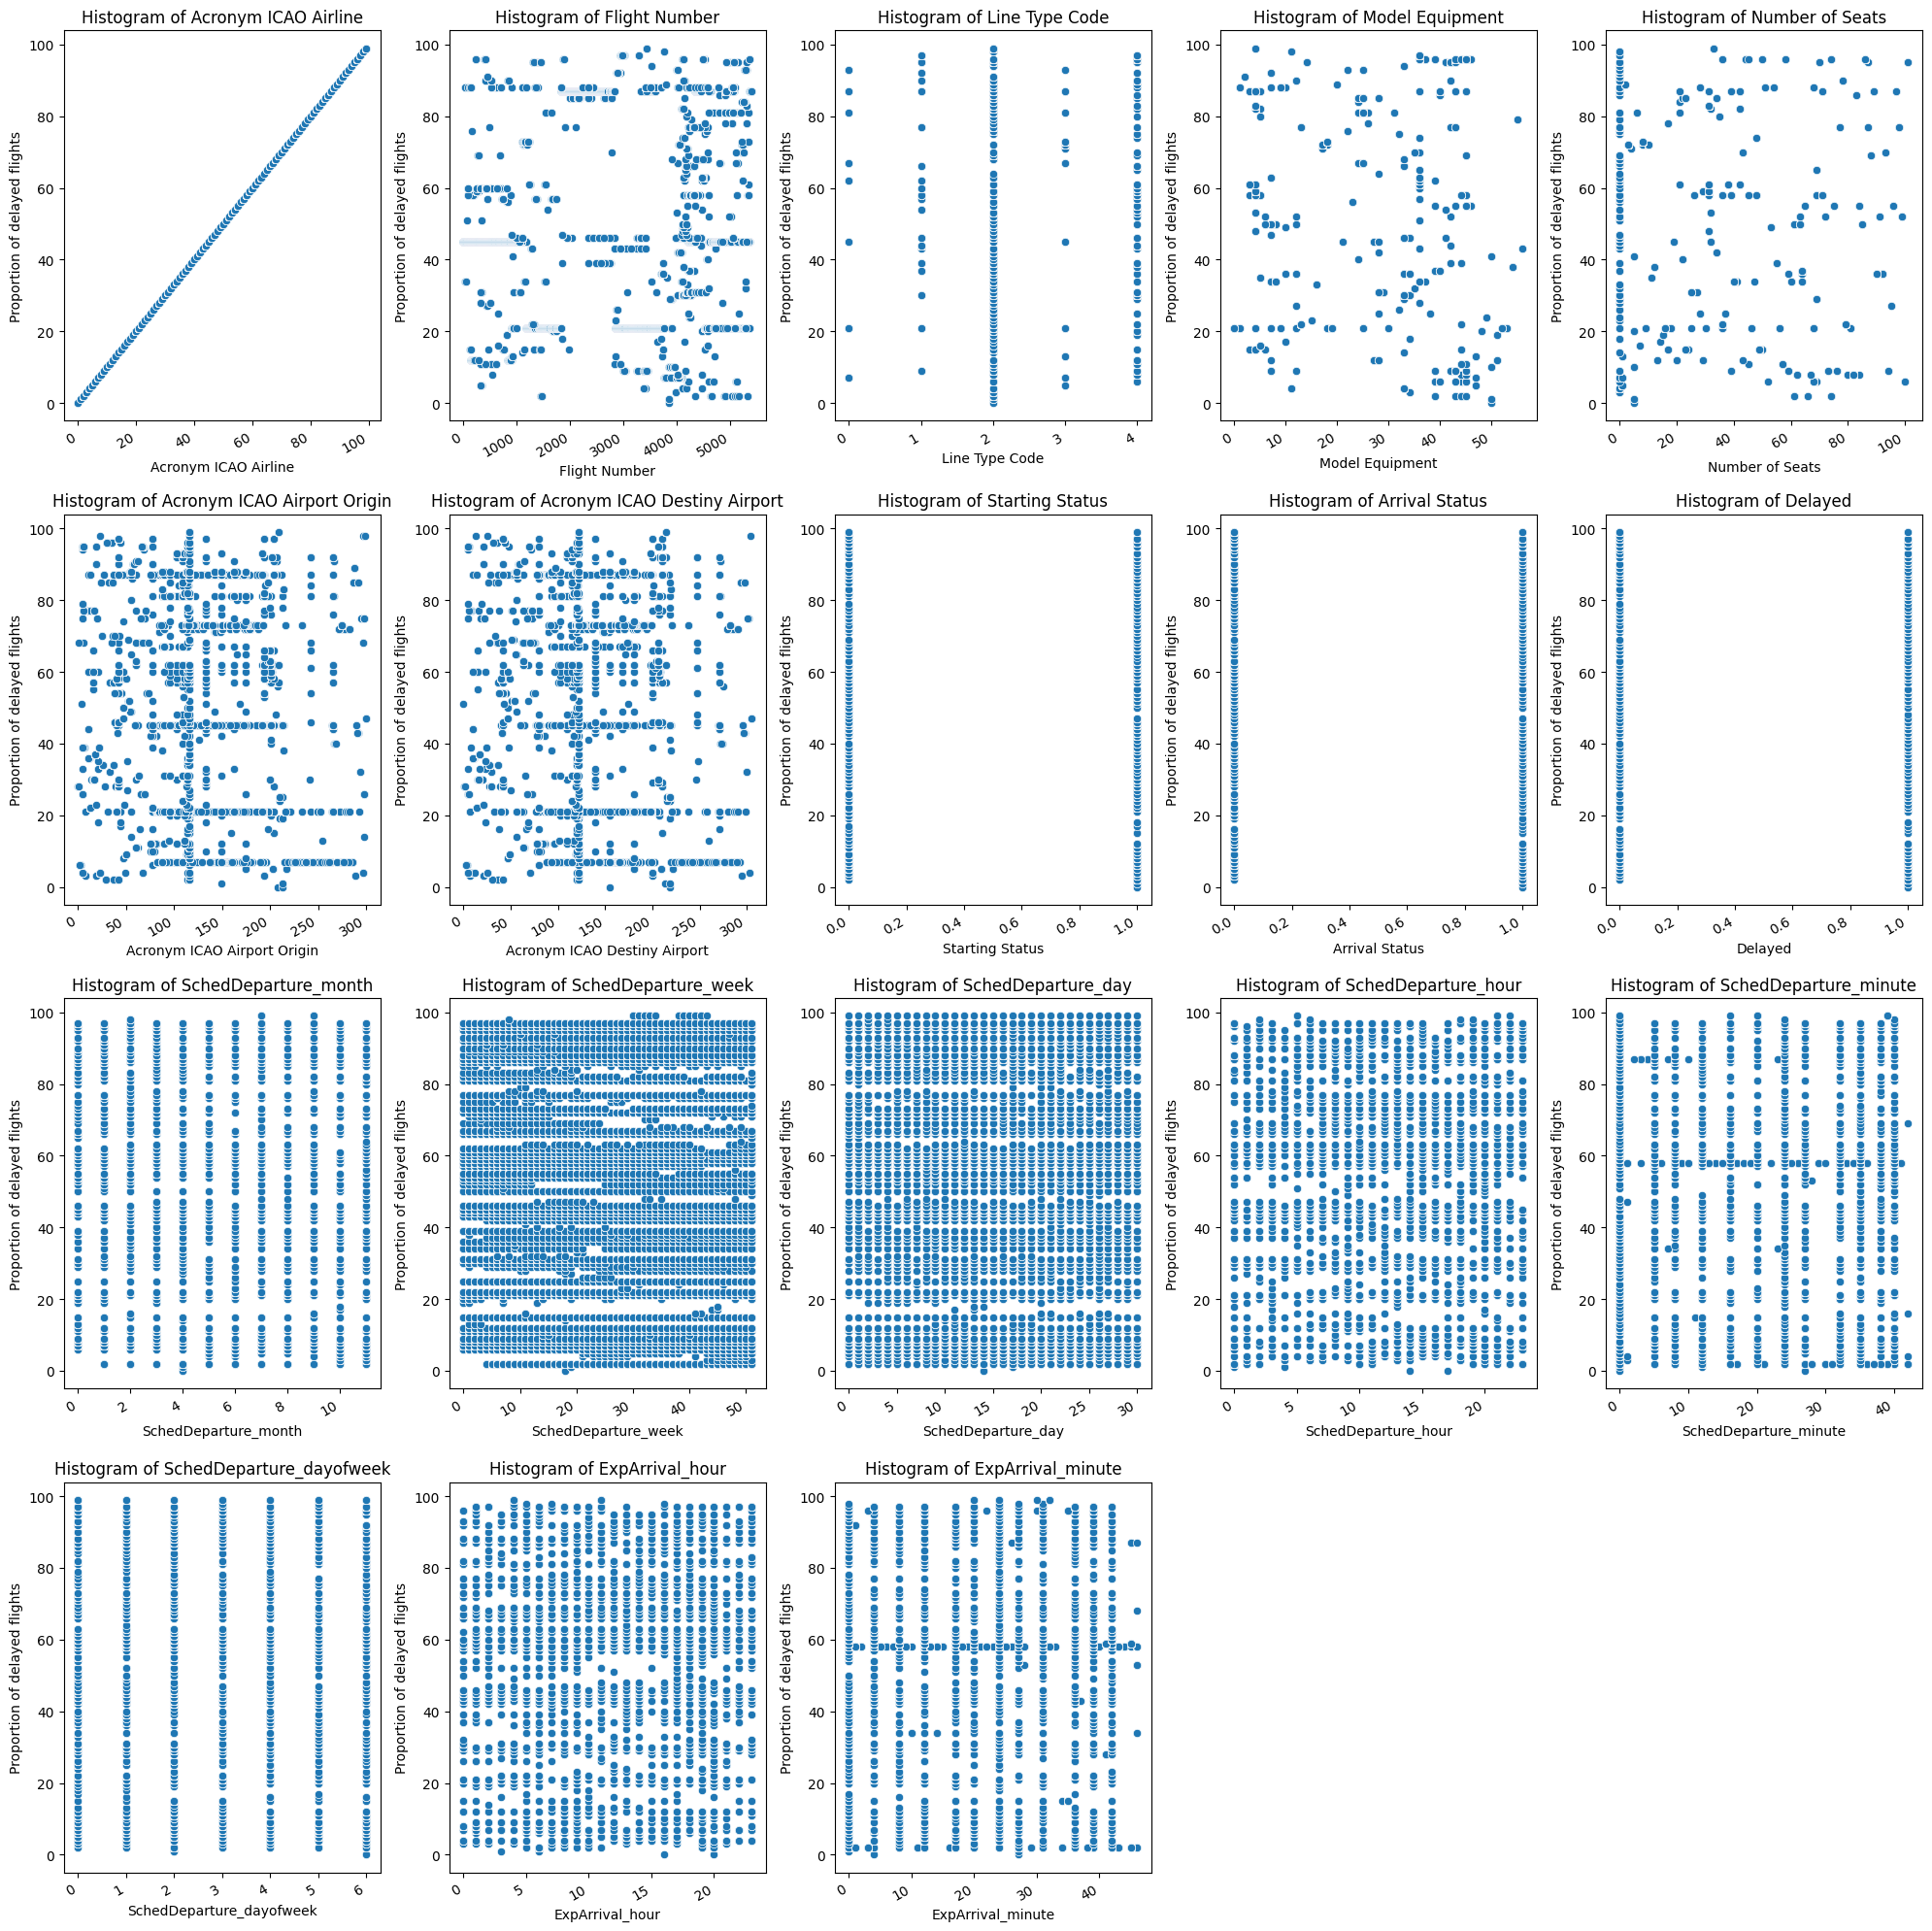

In [127]:
# CREATE THIS FOR ALL COLUMNS + IMPLEMENT IN USA DATA SET

#################################################################
fig, axs = plt.subplots(4,5, figsize=(20,20))
axs[3,3].axis('off')
axs[3,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_brazil5.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    sns.scatterplot(x=name, y="Acronym ICAO Airline", data=data_brazil5, ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Proportion of delayed flights")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

Besides collinearity between the response variables, there is a high signs of collinearity (correlation >= 0.7 [source](https://doi.org/10.1111/j.1600-0587.2012.07348.x)) between the scheduled departure week and month in this data set. This makes sense, since the record with the same weeks are almost always in the same month. Therefore, the scheduled departure week column will be removed. We can look at the correlation heatmap again to see if the high collinearity has been removed after this change.

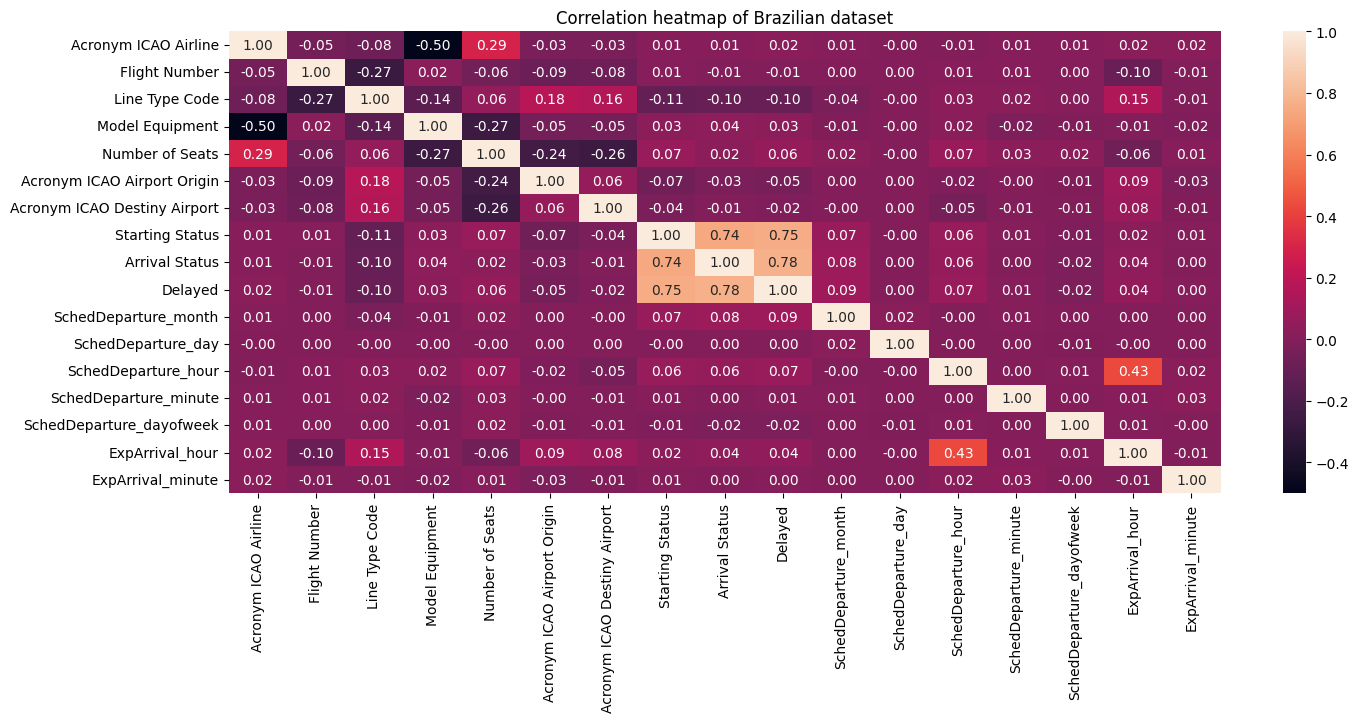

In [30]:
# Drop correlated column 
data_brazil5.drop(columns=["SchedDeparture_week"], inplace=True)
data_brazil_fs.drop(columns=["SchedDeparture_week"], inplace=True)
data_brazil_ml.drop(columns=["SchedDeparture_week"], inplace=True)

# Create correlation heatmap again
plt.figure(figsize=(16, 6))
plt.title("Correlation heatmap of Brazilian dataset")
heatmap = sns.heatmap(data_brazil5.corr(), annot=True, fmt=".2f")
plt.show()

It can be seen that the collinearity has now been removed amongst the explanatory variables in the data set.

Another way to gain information about which features contain the most information is to perform a chi-square test and look at the mutual information gain.

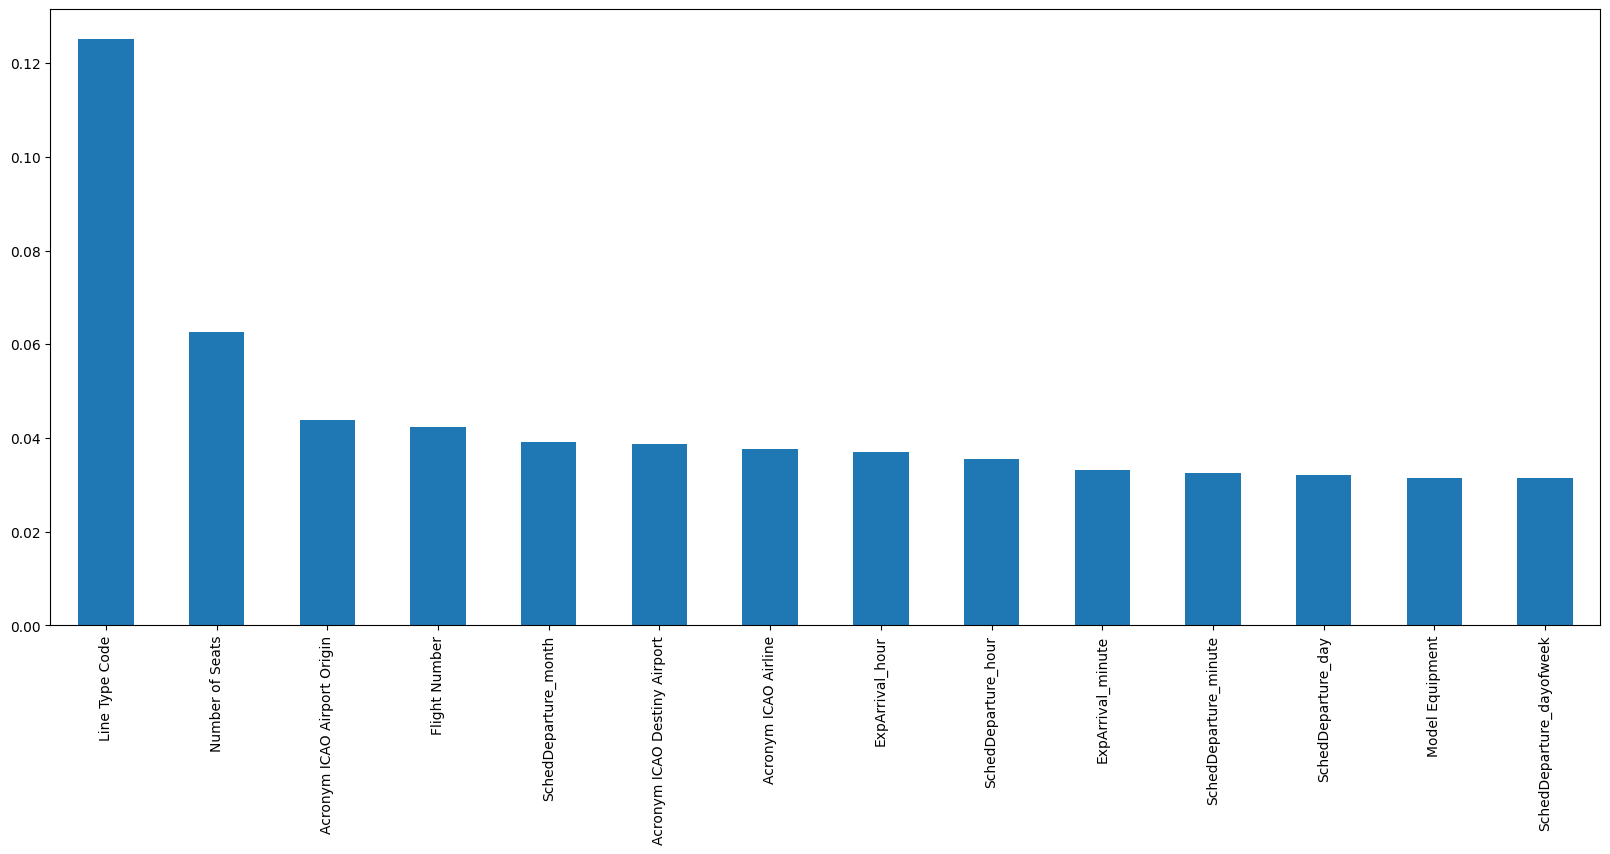

Index(['Flight Number', 'Line Type Code', 'Number of Seats',
       'Acronym ICAO Airport Origin', 'Acronym ICAO Destiny Airport'],
      dtype='object')

In [31]:
# Create X and y of dataset
y = data_brazil5["Delayed"]
X = data_brazil5.drop(columns=["Delayed", "Arrival Status", "Starting Status"])

# Chi2 test
# f_p_values=chi2(X, y)
# p_values=pd.Series(f_p_values[1])
# p_values.index=X.columns
# print(p_values.sort_values(ascending=True))

# Calculate mutual information gain
mutual_info = mutual_info_classif(X,y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit_transform(X,y)
X.columns[sel_five_cols.get_support()]

The mutual information gain is a metric to get the importance of a variable. The higher the value, the more important that feature will be. In our case, we can see that the number of seats, line type code and the flight number have the highest values. No columns will be removed, since we are only looking at the important values prior to machine learning to get an expression already.

The last metric used to see which features are more important than other is the information gain, which is calculated using the WoE. 

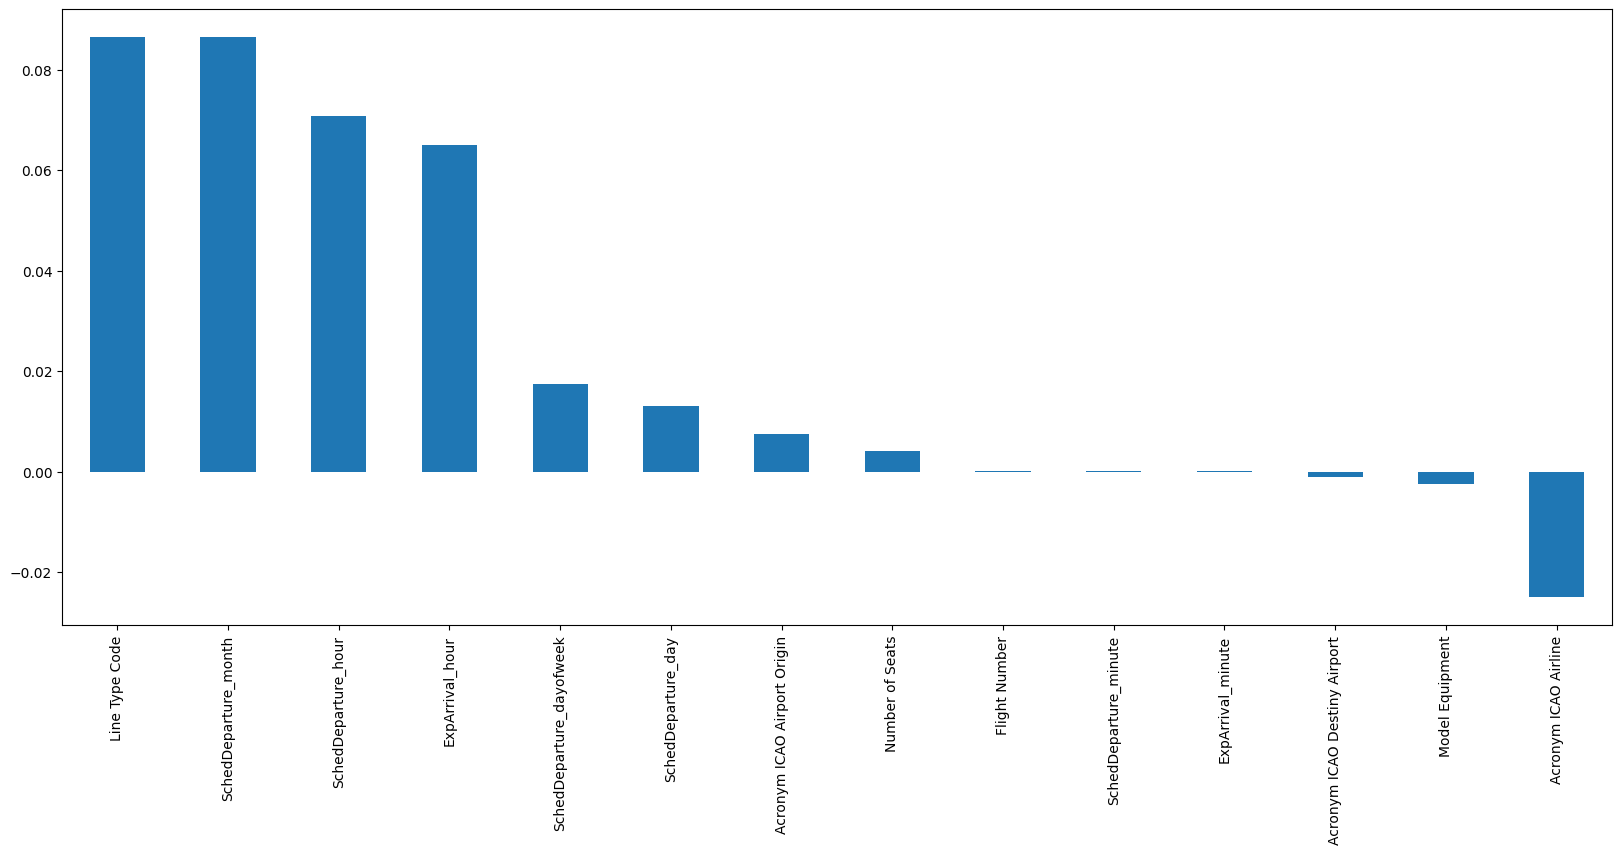

In [32]:
# Function to calculate information value
def get_iv(feature, target):
    df_woe_iv = (pd.crosstab(data_brazil_fs[feature],data_brazil_fs[target], normalize='columns')
                .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]) if (dfx[0]>0.0001).all() else dfx[1])
                .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv = df_woe_iv.iloc[0,2:][1]
    return iv

# Plot information value for all explanatory variables
X_fs = data_brazil_fs.drop(columns=["Delayed", "Arrival Status", "Starting Status"])
ivs = []
for feature in X_fs.columns.values:
    ivs.append(get_iv(feature, "Delayed"))
ivs_pd = pd.Series(ivs)
ivs_pd.index = X_fs.columns
ivs_pd.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

The resulting plot of information values shows that all features have an IV below the useful threshold. However, this is caused due to the dataset being really diverse, which is the reason no variables will be removed yet.

The feature selection has shown some preliminary influences of various attributes. However, the predictions can use completely different factors as the crucial features, so these results are not to be fully taken representative.

#### 2.5 Machine learning

Now that the data exploration phase is done, all data will get encoded to make it ready for the machine learning algorithms. We are using One Hot Encoding instead of label encoding, to avoid confusing the model that there is some kind of hierarchy in the categorical columns and to keep the information in the model.

In [33]:
# USE scaling if needed

# Use One Hot Encoding (MAYBE USE LABEL ENCODING LATER)
# cols = data_brazil5.select_dtypes(include="object").columns.values
# data_brazil5 = pd.get_dummies(data_brazil5, columns=cols)

# from sklearn import tree
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# y = data_brazil5["Delayed"]
# X = data_brazil5.drop(columns=["Delayed", "Arrival Status", "Starting Status"])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1242)
# clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred))
# importance = pd.Series(clf.feature_importances_, index=X.columns.values)
# importance.sort_values(ascending=False).head(10).plot.bar()
# plt.show()
# plt.figure(figsize=(20,20))
# tree.plot_tree(clf, fontsize=10, feature_names=X.columns.values, class_names=['Delayed', 'No delay'])
# plt.show()

### 3 Preprocessing the United States data

For the second data set, preprocessing is also needed. This is done in the following sections.

#### 3.1 Looking at the data

Let's have a look at the United States flight data set first before modifying it.

In [70]:
display(data_usa)

FL_DATE OP_UNIQUE_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  \
0          1/1/2022 12:00:00 AM                9E   N138EV               4732   
1          1/1/2022 12:00:00 AM                9E   N138EV               4979   
2          1/1/2022 12:00:00 AM                9E   N138EV               5430   
3          1/1/2022 12:00:00 AM                9E   N138EV               5430   
4          1/1/2022 12:00:00 AM                9E   N146PQ               4722   
...                         ...               ...      ...                ...   
6729120  12/31/2022 12:00:00 AM                YX   N882RW               5741   
6729121  12/31/2022 12:00:00 AM                YX   N979RP               3607   
6729122  12/31/2022 12:00:00 AM                YX   N979RP               3686   
6729123  12/31/2022 12:00:00 AM                YX   N979RP               3699   
6729124  12/31/2022 12:00:00 AM                YX   N979RP               3719   

         ORIGIN_AIRPORT_ID  ORIGIN_CITY_MARKET_ID  DEST_AIRPORT_ID  \
0                    10135                  30135            11433   
1                    11433                  31295            14524   
2                    10135                  30135            11433   
3                    11433                  31295            10135   
4                    11433                  31295            11423   
...                    ...                    ...              ...   
6729120              12953                  31703            11066   
6729121              14321                  34321            13930   
6729122              13930                  30977            14321   
6729123              11003                  31003            13930   
6729124              13930                  30977            11003   

         DEST_CITY_MARKET_ID  CRS_DEP_TIME  DEP_DELAY  ...  DISTANCE  \
0                      31295          1015       -1.0  ...     425.0   
1                      34524          2130        NaN  ...     456.0   
2                      31295          1700        NaN  ...     425.0   
3                      30135          1422       -3.0  ...     425.0   
4                      31423          1255        NaN  ...     534.0   
...                      ...           ...        ...  ...       ...   
6729120                31066           830       -7.0  ...     479.0   
6729121                30977           635       -7.0  ...     900.0   
6729122                34321          1800       -7.0  ...     900.0   
6729123                30977          1508      -10.0  ...     196.0   
6729124                31003          1245       -6.0  ...     196.0   

         CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0                  NaN            NaN        NaN             NaN   
1                  NaN            NaN        NaN             NaN   
2                  NaN            NaN        NaN             NaN   
3                  NaN            NaN        NaN             NaN   
4                  NaN            NaN        NaN             NaN   
...                ...            ...        ...             ...   
6729120            NaN            NaN        NaN             NaN   
6729121            0.0            0.0       25.0             0.0   
6729122            NaN            NaN        NaN             NaN   
6729123            NaN            NaN        NaN             NaN   
6729124            NaN            NaN        NaN             NaN   

         LATE_AIRCRAFT_DELAY  FIRST_DEP_TIME  TOTAL_ADD_GTIME  \
0                        NaN             NaN              NaN   
1                        NaN             NaN              NaN   
2                        NaN             NaN              NaN   
3                        NaN             NaN              NaN   
4                        NaN             NaN              NaN   
...                      ...             ...              ...   
6729120                  NaN             NaN              NaN   
6729121 

It is clear that this data set is way larger than the one from Brazil. A lot of columns from the original data set are not included in this file, because I selected the columns which were needed for this research. Columns that contained information which is not known prior to a flight and columns that contain information which can be derived from other columns are redundant and therefore not selected.

To be able to derive the airline carrier names and airport names, the lookup tables from the BTS are downloaded and lookup dictionaires are created based on them. 

In [71]:
# Store lookup tables from official BTS website
l_airline = pd.read_csv("../Data/L_UNIQUE_CARRIERS.csv")
l_airport = pd.read_csv("../Data/L_AIRPORT_ID.csv")

# Create dictionary to look up full name of airline ID
values = []
for code in data_usa["OP_UNIQUE_CARRIER"].unique():
    [item] = l_airline.loc[l_airline["Code"]==code, "Description"].tolist()
    values.append(item)
airline_lookup = dict(zip(data_usa["OP_UNIQUE_CARRIER"].unique(), values))

# Create dictionary to look up full name of airport ID
keys = pd.unique(np.concatenate((data_usa["ORIGIN_AIRPORT_ID"].unique(),data_usa["DEST_AIRPORT_ID"].unique())))
airport_codes = pd.unique(np.concatenate((data_usa["ORIGIN_AIRPORT_ID"].unique(),data_usa["DEST_AIRPORT_ID"].unique())))
values = []
for code in airport_codes:
    [item] = l_airport.loc[l_airport["Code"]==code, "Description"].tolist()
    values.append(item)
airport_lookup = dict(zip(keys, values))

The data is still the same, but the full airline and airport names can easily be retrieved now. 

#### 3.2 First steps of data cleaning
After the lookup dictionaires have been created, we can start having a look at the values of each column and its properties.

In [72]:
print(data_usa.count())

FL_DATE                  6729125
OP_UNIQUE_CARRIER        6729125
TAIL_NUM                 6694565
OP_CARRIER_FL_NUM        6729125
ORIGIN_AIRPORT_ID        6729125
ORIGIN_CITY_MARKET_ID    6729125
DEST_AIRPORT_ID          6729125
DEST_CITY_MARKET_ID      6729125
CRS_DEP_TIME             6729125
DEP_DELAY                6551777
CRS_ARR_TIME             6729125
ARR_DELAY                6532012
CANCELLED                6729125
DIVERTED                 6729125
CRS_ELAPSED_TIME         6729125
FLIGHTS                  6729125
DISTANCE                 6729125
CARRIER_DELAY            1376798
WEATHER_DELAY            1376798
NAS_DELAY                1376798
SECURITY_DELAY           1376798
LATE_AIRCRAFT_DELAY      1376798
FIRST_DEP_TIME             40908
TOTAL_ADD_GTIME            40904
LONGEST_ADD_GTIME          40904
DIV_ARR_DELAY              14160
dtype: int64


It is clear that there are still some features present in the data set, which will not be available prior to a flight departure. These include the various kinds of delays, which are logically not available, and whether a flight is cancelled or diverted. Our research will focus on predicting whether a flight gets delayed, not whether it is cancelled or diverted. Therefore, all cancelled and diverted flights records will be removed from the data set as well as the aforementioned columns.

In [88]:
# Drop entries of flights that are cancelled or uninformed
data_usa2 = data_usa.drop(data_usa[(data_usa["CANCELLED"] == 1) | (data_usa["DIVERTED"] == 1)].index)

# Drop cancelled and diverted columns as they have no use anymore
data_usa2.drop(columns=['CANCELLED', 'DIVERTED'], inplace=True)

# Drop various delay columns as these are not known prior to a flight
data_usa2.drop(columns=['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'], inplace=True)

display(data_usa2)

FL_DATE OP_UNIQUE_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  \
0          1/1/2022 12:00:00 AM                9E   N138EV               4732   
3          1/1/2022 12:00:00 AM                9E   N138EV               5430   
6          1/1/2022 12:00:00 AM                9E   N147PQ               4671   
7          1/1/2022 12:00:00 AM                9E   N147PQ               5009   
8          1/1/2022 12:00:00 AM                9E   N147PQ               5083   
...                         ...               ...      ...                ...   
6729120  12/31/2022 12:00:00 AM                YX   N882RW               5741   
6729121  12/31/2022 12:00:00 AM                YX   N979RP               3607   
6729122  12/31/2022 12:00:00 AM                YX   N979RP               3686   
6729123  12/31/2022 12:00:00 AM                YX   N979RP               3699   
6729124  12/31/2022 12:00:00 AM                YX   N979RP               3719   

         ORIGIN_AIRPORT_ID  ORIGIN_CITY_MARKET_ID  DEST_AIRPORT_ID  \
0                    10135                  30135            11433   
3                    11433                  31295            10135   
6                    10397                  30397            14783   
7                    13487                  31650            11423   
8                    11423                  31423            10397   
...                    ...                    ...              ...   
6729120              12953                  31703            11066   
6729121              14321                  34321            13930   
6729122              13930                  30977            14321   
6729123              11003                  31003            13930   
6729124              13930                  30977            11003   

         DEST_CITY_MARKET_ID  CRS_DEP_TIME  DEP_DELAY  CRS_ARR_TIME  \
0                      31295          1015       -1.0          1209   
3                      30135          1422       -3.0          1548   
6                      34783          2057       -5.0          2149   
7                      31423          1041       -3.0          1153   
8                      30397          1300       -3.0          1610   
...                      ...           ...        ...           ...   
6729120                31066           830       -7.0          1038   
6729121                30977           635       -7.0           758   
6729122                34321          1800       -7.0          2129   
6729123                30977          1508      -10.0          1627   
6729124                31003          1245       -6.0          1400   

         ARR_DELAY  CRS_ELAPSED_TIME  FLIGHTS  DISTANCE  FIRST_DEP_TIME  \
0            -15.0             114.0      1.0     425.0             NaN   
3            -19.0              86.0      1.0     425.0             NaN   
6            -10.0             112.0      1.0     563.0             NaN   
7              5.0              72.0      1.0     232.0             NaN   
8              6.0             130.0      1.0     743.0             NaN   
...            ...               ...      ...       ...             ...   
6729120      -37.0             128.0      1.0     479.0             NaN   
6729121       25.0             143.0      1.0     900.0             NaN   
6729122      -20.0             149.0      1.0     900.0             NaN   
6729123      -12.0              79.0      1.0     196.0             NaN   
6729124      -12.0              75.0      1.0     196.0             NaN   

         TOTAL_ADD_GTIME  LONGEST_ADD_GTIME  DIV_ARR_DELAY  
0                    NaN                NaN            NaN  
3                    NaN                NaN            NaN  
6                    NaN                NaN            NaN  
7                    NaN                NaN            NaN  
8                    NaN                NaN            NaN  
...                  ...                ...            ...  
6729120              NaN     

To see if the missing values have been removed, we can have a look at the counts of each column again.

In [89]:
print(data_usa2.count())

FL_DATE                  6532013
OP_UNIQUE_CARRIER        6532013
TAIL_NUM                 6532013
OP_CARRIER_FL_NUM        6532013
ORIGIN_AIRPORT_ID        6532013
ORIGIN_CITY_MARKET_ID    6532013
DEST_AIRPORT_ID          6532013
DEST_CITY_MARKET_ID      6532013
CRS_DEP_TIME             6532013
DEP_DELAY                6532013
CRS_ARR_TIME             6532013
ARR_DELAY                6532012
CRS_ELAPSED_TIME         6532013
FLIGHTS                  6532013
DISTANCE                 6532013
FIRST_DEP_TIME             37426
TOTAL_ADD_GTIME            37422
LONGEST_ADD_GTIME          37422
DIV_ARR_DELAY                  0
dtype: int64


We can see that there is one missing arrival delay record, which will therefore be removed.

In [90]:
# Remove row with missing arrival delay
data_usa2.drop(index=data_usa2[data_usa2["ARR_DELAY"].isna()].index, inplace=True)

To create the desired response variables, the same strategy is applied as the one on the Brazilian data set. The total delay of a flight is calculated by adding the arrival delay to the departure delay. If the total delay is more than 15 minutes, the flight is considered delayed. The values for the departure and arrival delay are kept for eventual future research.

In [91]:
# Create new column "Delayed" which represents whether the total delay of the flight is more than 15 minutes
data_usa2.loc[data_usa2["DEP_DELAY"] + data_usa2["ARR_DELAY"] <= 15, "Delayed"] = 0
data_usa2.loc[data_usa2["DEP_DELAY"] + data_usa2["ARR_DELAY"] > 15, "Delayed"] = 1
data_usa2["Delayed"] = data_usa2["Delayed"].astype(int)

# Change departure delay column to represent whether the departure delay is more than 15 minutes
data_usa2.loc[data_usa2["DEP_DELAY"] <= 15, "DEP_DELAY"] = 0
data_usa2.loc[data_usa2["DEP_DELAY"] > 15, "DEP_DELAY"] = 1
data_usa2["DEP_DELAY"] = data_usa2["DEP_DELAY"].astype(int)

# Change arrival delay column to represent whether the arrival delay is more than 15 minutes
data_usa2.loc[data_usa2["ARR_DELAY"] <= 15, "ARR_DELAY"] = 0
data_usa2.loc[data_usa2["ARR_DELAY"] > 15, "ARR_DELAY"] = 1
data_usa2["ARR_DELAY"] = data_usa2["ARR_DELAY"].astype(int)

display(data_usa2)

FL_DATE OP_UNIQUE_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  \
0          1/1/2022 12:00:00 AM                9E   N138EV               4732   
3          1/1/2022 12:00:00 AM                9E   N138EV               5430   
6          1/1/2022 12:00:00 AM                9E   N147PQ               4671   
7          1/1/2022 12:00:00 AM                9E   N147PQ               5009   
8          1/1/2022 12:00:00 AM                9E   N147PQ               5083   
...                         ...               ...      ...                ...   
6729120  12/31/2022 12:00:00 AM                YX   N882RW               5741   
6729121  12/31/2022 12:00:00 AM                YX   N979RP               3607   
6729122  12/31/2022 12:00:00 AM                YX   N979RP               3686   
6729123  12/31/2022 12:00:00 AM                YX   N979RP               3699   
6729124  12/31/2022 12:00:00 AM                YX   N979RP               3719   

         ORIGIN_AIRPORT_ID  ORIGIN_CITY_MARKET_ID  DEST_AIRPORT_ID  \
0                    10135                  30135            11433   
3                    11433                  31295            10135   
6                    10397                  30397            14783   
7                    13487                  31650            11423   
8                    11423                  31423            10397   
...                    ...                    ...              ...   
6729120              12953                  31703            11066   
6729121              14321                  34321            13930   
6729122              13930                  30977            14321   
6729123              11003                  31003            13930   
6729124              13930                  30977            11003   

         DEST_CITY_MARKET_ID  CRS_DEP_TIME  DEP_DELAY  CRS_ARR_TIME  \
0                      31295          1015          0          1209   
3                      30135          1422          0          1548   
6                      34783          2057          0          2149   
7                      31423          1041          0          1153   
8                      30397          1300          0          1610   
...                      ...           ...        ...           ...   
6729120                31066           830          0          1038   
6729121                30977           635          0           758   
6729122                34321          1800          0          2129   
6729123                30977          1508          0          1627   
6729124                31003          1245          0          1400   

         ARR_DELAY  CRS_ELAPSED_TIME  FLIGHTS  DISTANCE  FIRST_DEP_TIME  \
0                0             114.0      1.0     425.0             NaN   
3                0              86.0      1.0     425.0             NaN   
6                0             112.0      1.0     563.0             NaN   
7                0              72.0      1.0     232.0             NaN   
8                0             130.0      1.0     743.0             NaN   
...            ...               ...      ...       ...             ...   
6729120          0             128.0      1.0     479.0             NaN   
6729121          1             143.0      1.0     900.0             NaN   
6729122          0             149.0      1.0     900.0             NaN   
6729123          0              79.0      1.0     196.0             NaN   
6729124          0              75.0      1.0     196.0             NaN   

         TOTAL_ADD_GTIME  LONGEST_ADD_GTIME  DIV_ARR_DELAY  Delayed  
0                    NaN                NaN            NaN        0  
3                    NaN                NaN            NaN        0  
6                    NaN                NaN            NaN        0  
7                    NaN                NaN            NaN        0  
8                    NaN                NaN            NaN        0  
...                  ...            

Just like was done for the Brazilian data set, the flight date and departure/arrival time will be split up. We chose to split the departure date and time into month, week, day, hour, minute and day of the week. The arrival time is split into hour and minute, to avoid high collinearity since most flights arrive at the same day.

In [94]:
# Convert string types to datetime types and store them temporarily
dep_dates = []
arr_dates = []
for i in range(len(data_usa2)):
    day = data_usa2["FL_DATE"].values[i]
    inter = day.split('/')
    inter[0] = inter[0].rjust(2, "0")
    inter[1] = inter[1].rjust(2, "0")
    inter[2] = inter[2][:4]
    inter2 = inter.copy()

    dep_time = data_usa2["CRS_DEP_TIME"].values[i].astype(int).astype(str)
    p1, p2 = dep_time[:len(dep_time)//2], dep_time[len(dep_time)//2:]
    p1 = p1.rjust(2, "0")
    if p1 == "24":
        p1 = "00"
    inter.append(p1)
    inter.append(p2)

    final = ' '.join(inter)

    arr_time = data_usa2["CRS_ARR_TIME"].values[i].astype(int).astype(str)
    p1, p2 = arr_time[:len(arr_time)//2], arr_time[len(arr_time)//2:]
    p1 = p1.rjust(2, "0")
    if p1 == "24":
        p1 = "00"
    inter2.append(p1)
    inter2.append(p2)

    final2 = ' '.join(inter2)
    
    dep_dates.append(datetime.datetime.strptime(final, "%m %d %Y %H %M"))
    arr_dates.append(datetime.datetime.strptime(final2, "%m %d %Y %H %M"))

# Create new columns to save the splitted departure date
data_usa2["CRS_DEP_TIME"] = dep_dates
data_usa2["CRS_ARR_TIME"] = arr_dates
data_usa2["SchedDeparture_month"] = data_usa2["CRS_DEP_TIME"].dt.month
data_usa2["SchedDeparture_week"] = data_usa2["CRS_DEP_TIME"].dt.isocalendar().week
data_usa2["SchedDeparture_day"] = data_usa2["CRS_DEP_TIME"].dt.day
data_usa2["SchedDeparture_hour"] = data_usa2["CRS_DEP_TIME"].dt.hour
data_usa2["SchedDeparture_minute"] = data_usa2["CRS_DEP_TIME"].dt.minute
data_usa2["SchedDeparture_dayofweek"] = data_usa2["CRS_DEP_TIME"].dt.dayofweek

# Create new columns for parts of the expected arrival date
data_usa2["SchedArrival_hour"] = data_usa2["CRS_ARR_TIME"].dt.hour
data_usa2["SchedArrival_minute"] = data_usa2["CRS_ARR_TIME"].dt.minute

# Drop redundant columns with dates
data_usa3 = data_usa2.drop(columns=['FL_DATE', 'CRS_DEP_TIME', 'CRS_ARR_TIME'])
display(data_usa3)

OP_UNIQUE_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
0                      9E   N138EV               4732              10135   
3                      9E   N138EV               5430              11433   
6                      9E   N147PQ               4671              10397   
7                      9E   N147PQ               5009              13487   
8                      9E   N147PQ               5083              11423   
...                   ...      ...                ...                ...   
6729120                YX   N882RW               5741              12953   
6729121                YX   N979RP               3607              14321   
6729122                YX   N979RP               3686              13930   
6729123                YX   N979RP               3699              11003   
6729124                YX   N979RP               3719              13930   

         ORIGIN_CITY_MARKET_ID  DEST_AIRPORT_ID  DEST_CITY_MARKET_ID  \
0                        30135            11433                31295   
3                        31295            10135                30135   
6                        30397            14783                34783   
7                        31650            11423                31423   
8                        31423            10397                30397   
...                        ...              ...                  ...   
6729120                  31703            11066                31066   
6729121                  34321            13930                30977   
6729122                  30977            14321                34321   
6729123                  31003            13930                30977   
6729124                  30977            11003                31003   

         DEP_DELAY  ARR_DELAY  CRS_ELAPSED_TIME  ...  DIV_ARR_DELAY  Delayed  \
0                0          0             114.0  ...            NaN        0   
3                0          0              86.0  ...            NaN        0   
6                0          0             112.0  ...            NaN        0   
7                0          0              72.0  ...            NaN        0   
8                0          0             130.0  ...            NaN        0   
...            ...        ...               ...  ...            ...      ...   
6729120          0          0             128.0  ...            NaN        0   
6729121          0          1             143.0  ...            NaN        1   
6729122          0          0             149.0  ...            NaN        0   
6729123          0          0              79.0  ...            NaN        0   
6729124          0          0              75.0  ...            NaN        0   

         SchedDeparture_month  SchedDeparture_week  SchedDeparture_day  \
0                           1                   52                   1   
3                           1                   52                   1   
6                           1                   52                   1   
7                           1                   52                   1   
8                           1                   52                   1   
...                       ...                  ...                 ...   
6729120                    12                   52                  31   
6729121                    12                   52                  31   
6729122                    12                   52                  31   
6729123                    12                   52                  31   
6729124                    12                   52                  31   

         SchedDeparture_hour  SchedDeparture_minute  SchedDeparture_dayofweek  \
0                         10                     15                         5   
3                         14                     22                         5   
6                         20                     57                         5   
7                         10                     41     

Now that the the response variables have been created and the dates have been split up, we can have a look at the counts of each attribute again.

In [95]:
print(data_usa3.count())

OP_UNIQUE_CARRIER           6532012
TAIL_NUM                    6532012
OP_CARRIER_FL_NUM           6532012
ORIGIN_AIRPORT_ID           6532012
ORIGIN_CITY_MARKET_ID       6532012
DEST_AIRPORT_ID             6532012
DEST_CITY_MARKET_ID         6532012
DEP_DELAY                   6532012
ARR_DELAY                   6532012
CRS_ELAPSED_TIME            6532012
FLIGHTS                     6532012
DISTANCE                    6532012
FIRST_DEP_TIME                37426
TOTAL_ADD_GTIME               37422
LONGEST_ADD_GTIME             37422
DIV_ARR_DELAY                     0
Delayed                     6532012
SchedDeparture_month        6532012
SchedDeparture_week         6532012
SchedDeparture_day          6532012
SchedDeparture_hour         6532012
SchedDeparture_minute       6532012
SchedDeparture_dayofweek    6532012
SchedArrival_hour           6532012
SchedArrival_minute         6532012
dtype: int64


It is visible that the `DIV_ARR_DELAY` column is empty, since all diverted flights have been removed from the data set. The `FIRST_DEP_TIME`, `TOTAL_ADD_GTIME`, and `LONGEST_ADD_GTIME` columns contain gate return information, which is not relevant in our research. Because of these reasons, the 4 aforementioned columns will be removed from the data.

In [96]:
# Drop irrelevant columns from data set
data_usa4 = data_usa3.drop(columns=['DIV_ARR_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME'])

#### 3.3 Data exploration
The data set has now been cleaned a bit and no missing data is present anymore. Therefore, we can have a look at the distributions of the attributes and make some visualizations of our data. The first visualization that I used is a world map which shows all the airports that are present in the United States data set.

<AxesSubplot: >

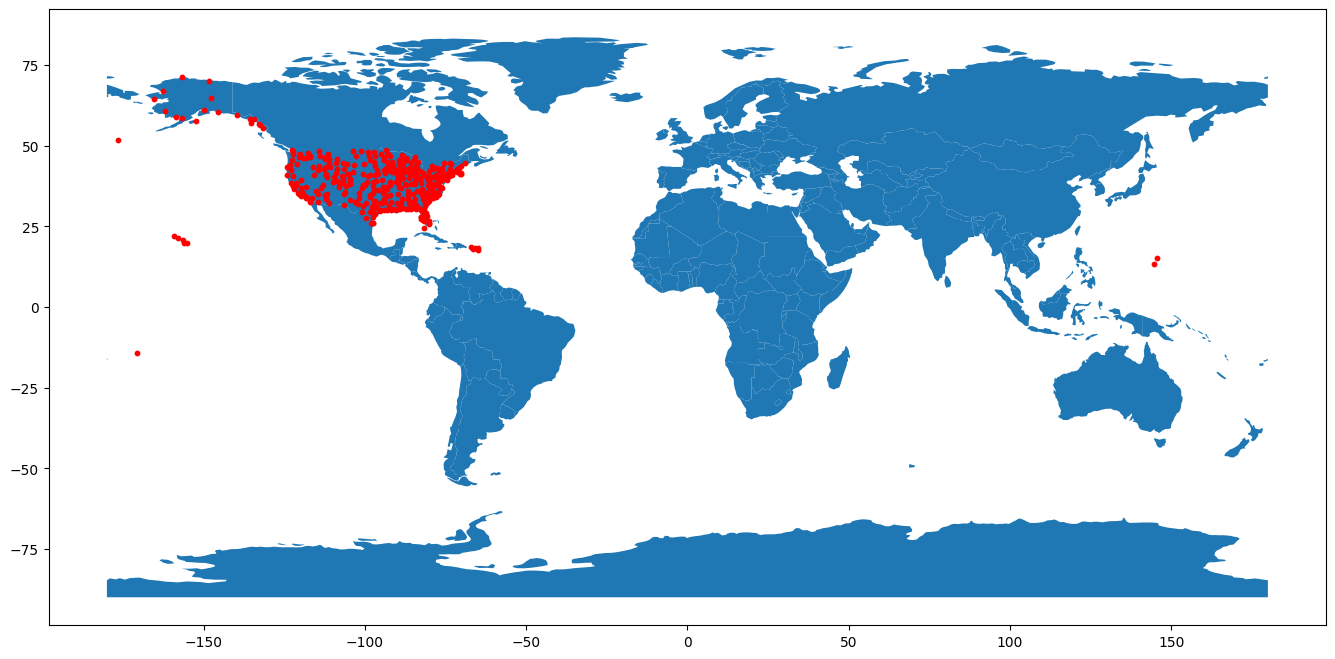

In [97]:
# Create list with coordinates for each airport
geo = ArcGIS()
intermediate = []

for short in airport_lookup:
    location = geo.geocode(airport_lookup.get(short))
    intermediate.append([location.longitude, location.latitude])
df = pd.DataFrame(intermediate, columns=["Longitude", "Latitude"])

# Print the coordinates on the world map
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 8)), marker='o', color='red', markersize=10)

To visualize the distributions of the variables in the data set, we create histograms.

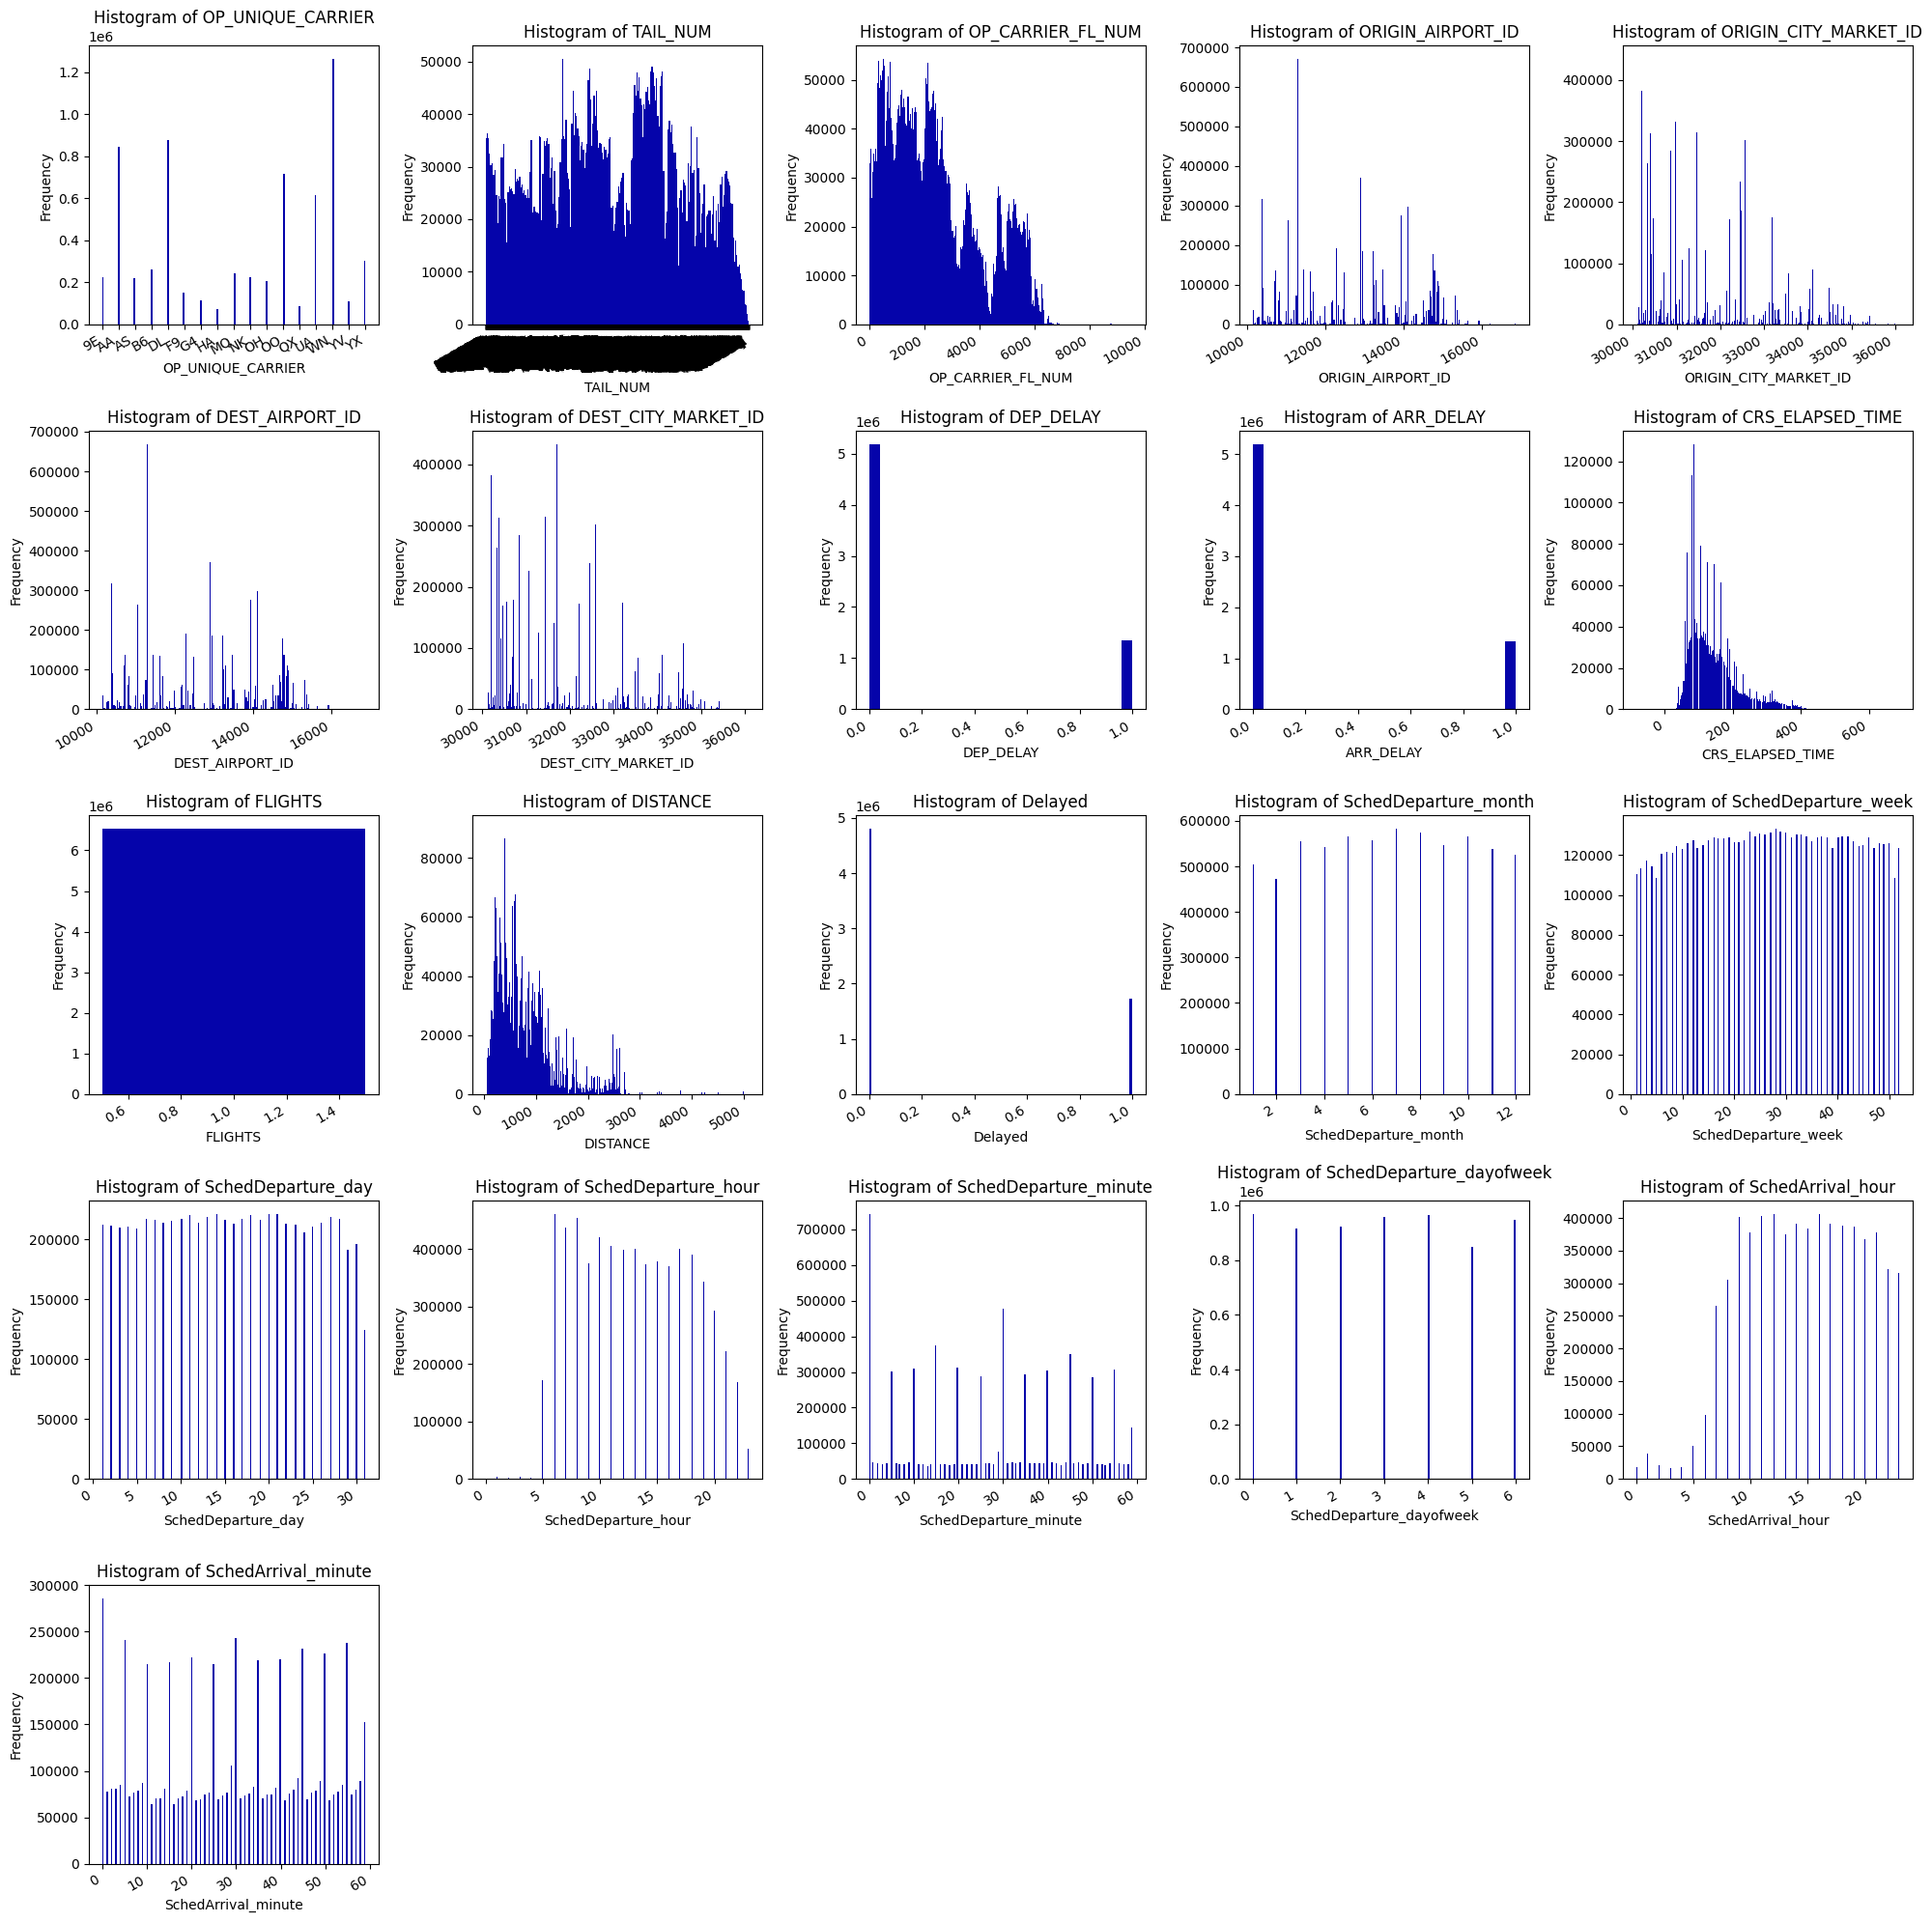

In [98]:
# Plot histograms for each column
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,1].axis('off')
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_usa4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist(x=data_usa4[name], bins='auto', color='#0504aa')
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

Most of the distributions are shown nicely and are really informative. For instance: it can be seen that certain airlines and airports occur a lot of times and that flights departuring in the night are really rare. Some of the columns like the airline and origin airport are not so clear since they have a broad scale. Therefore, the top 10 values of all columns will also be plotted in a histogram.

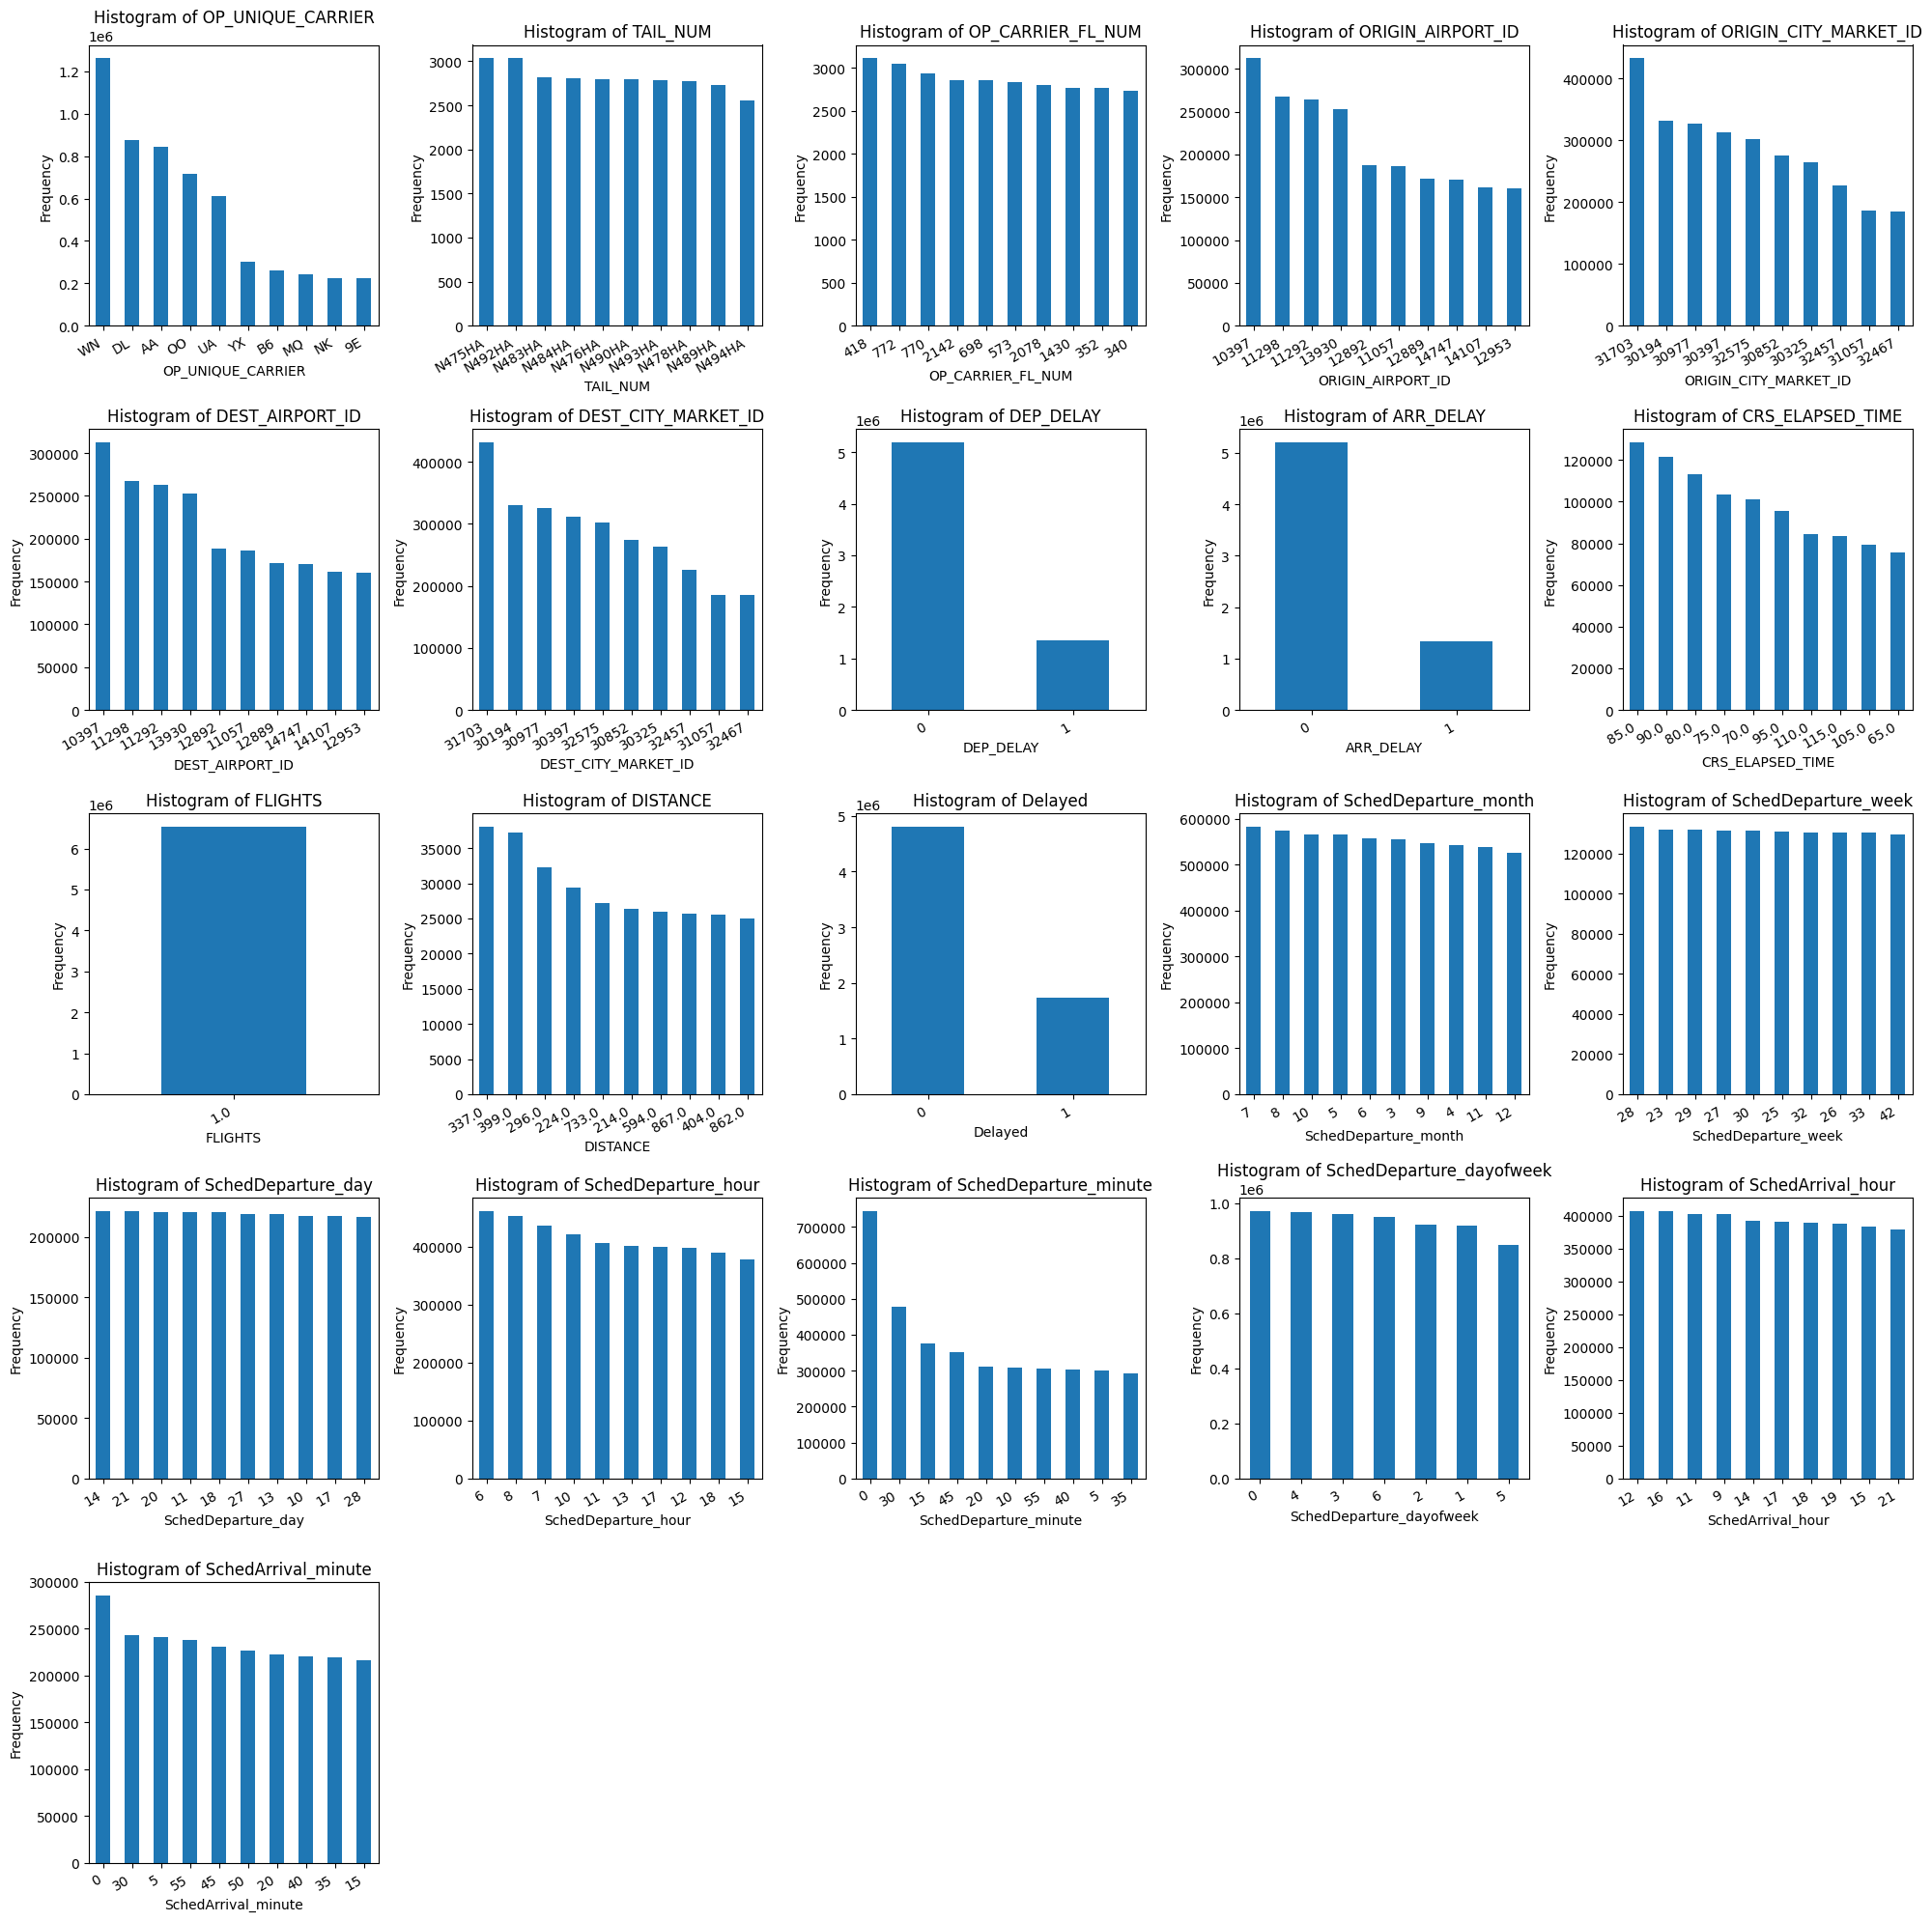

In [99]:
#  Plot histograms for each column, descending the top 10 occuring values for each column
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,1].axis('off')
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_usa4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    data_usa4[name].value_counts().head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

In [100]:
print("Most frequent airlines: " + airline_lookup.get("WN") + ", " + airline_lookup.get("DL") + ", and " + airline_lookup.get("AA"))
print("Most frequent departure and arrival airports: " + airport_lookup.get(10397) + ", " + airport_lookup.get(11298) + ", and " + airport_lookup.get(11292))

Most frequent airlines: Southwest Airlines Co., Delta Air Lines Inc., and American Airlines Inc.
Most frequent departure and arrival airports: Atlanta, GA: Hartsfield-Jackson Atlanta International, Dallas/Fort Worth, TX: Dallas/Fort Worth International, and Denver, CO: Denver International


A lot more information can be gathered from these obtained histograms. It can be seen that some airlines and airports are used way more often in the United States than others, take for example Southwest Airlines as the most occuring airline. Further, it can be seen that the most occuring distance of a route is 337 miles.

In this study, we are interested in flight delays. Therefore, we will look at the same distributions but then with the portion of delayed flights integrated in the histograms.

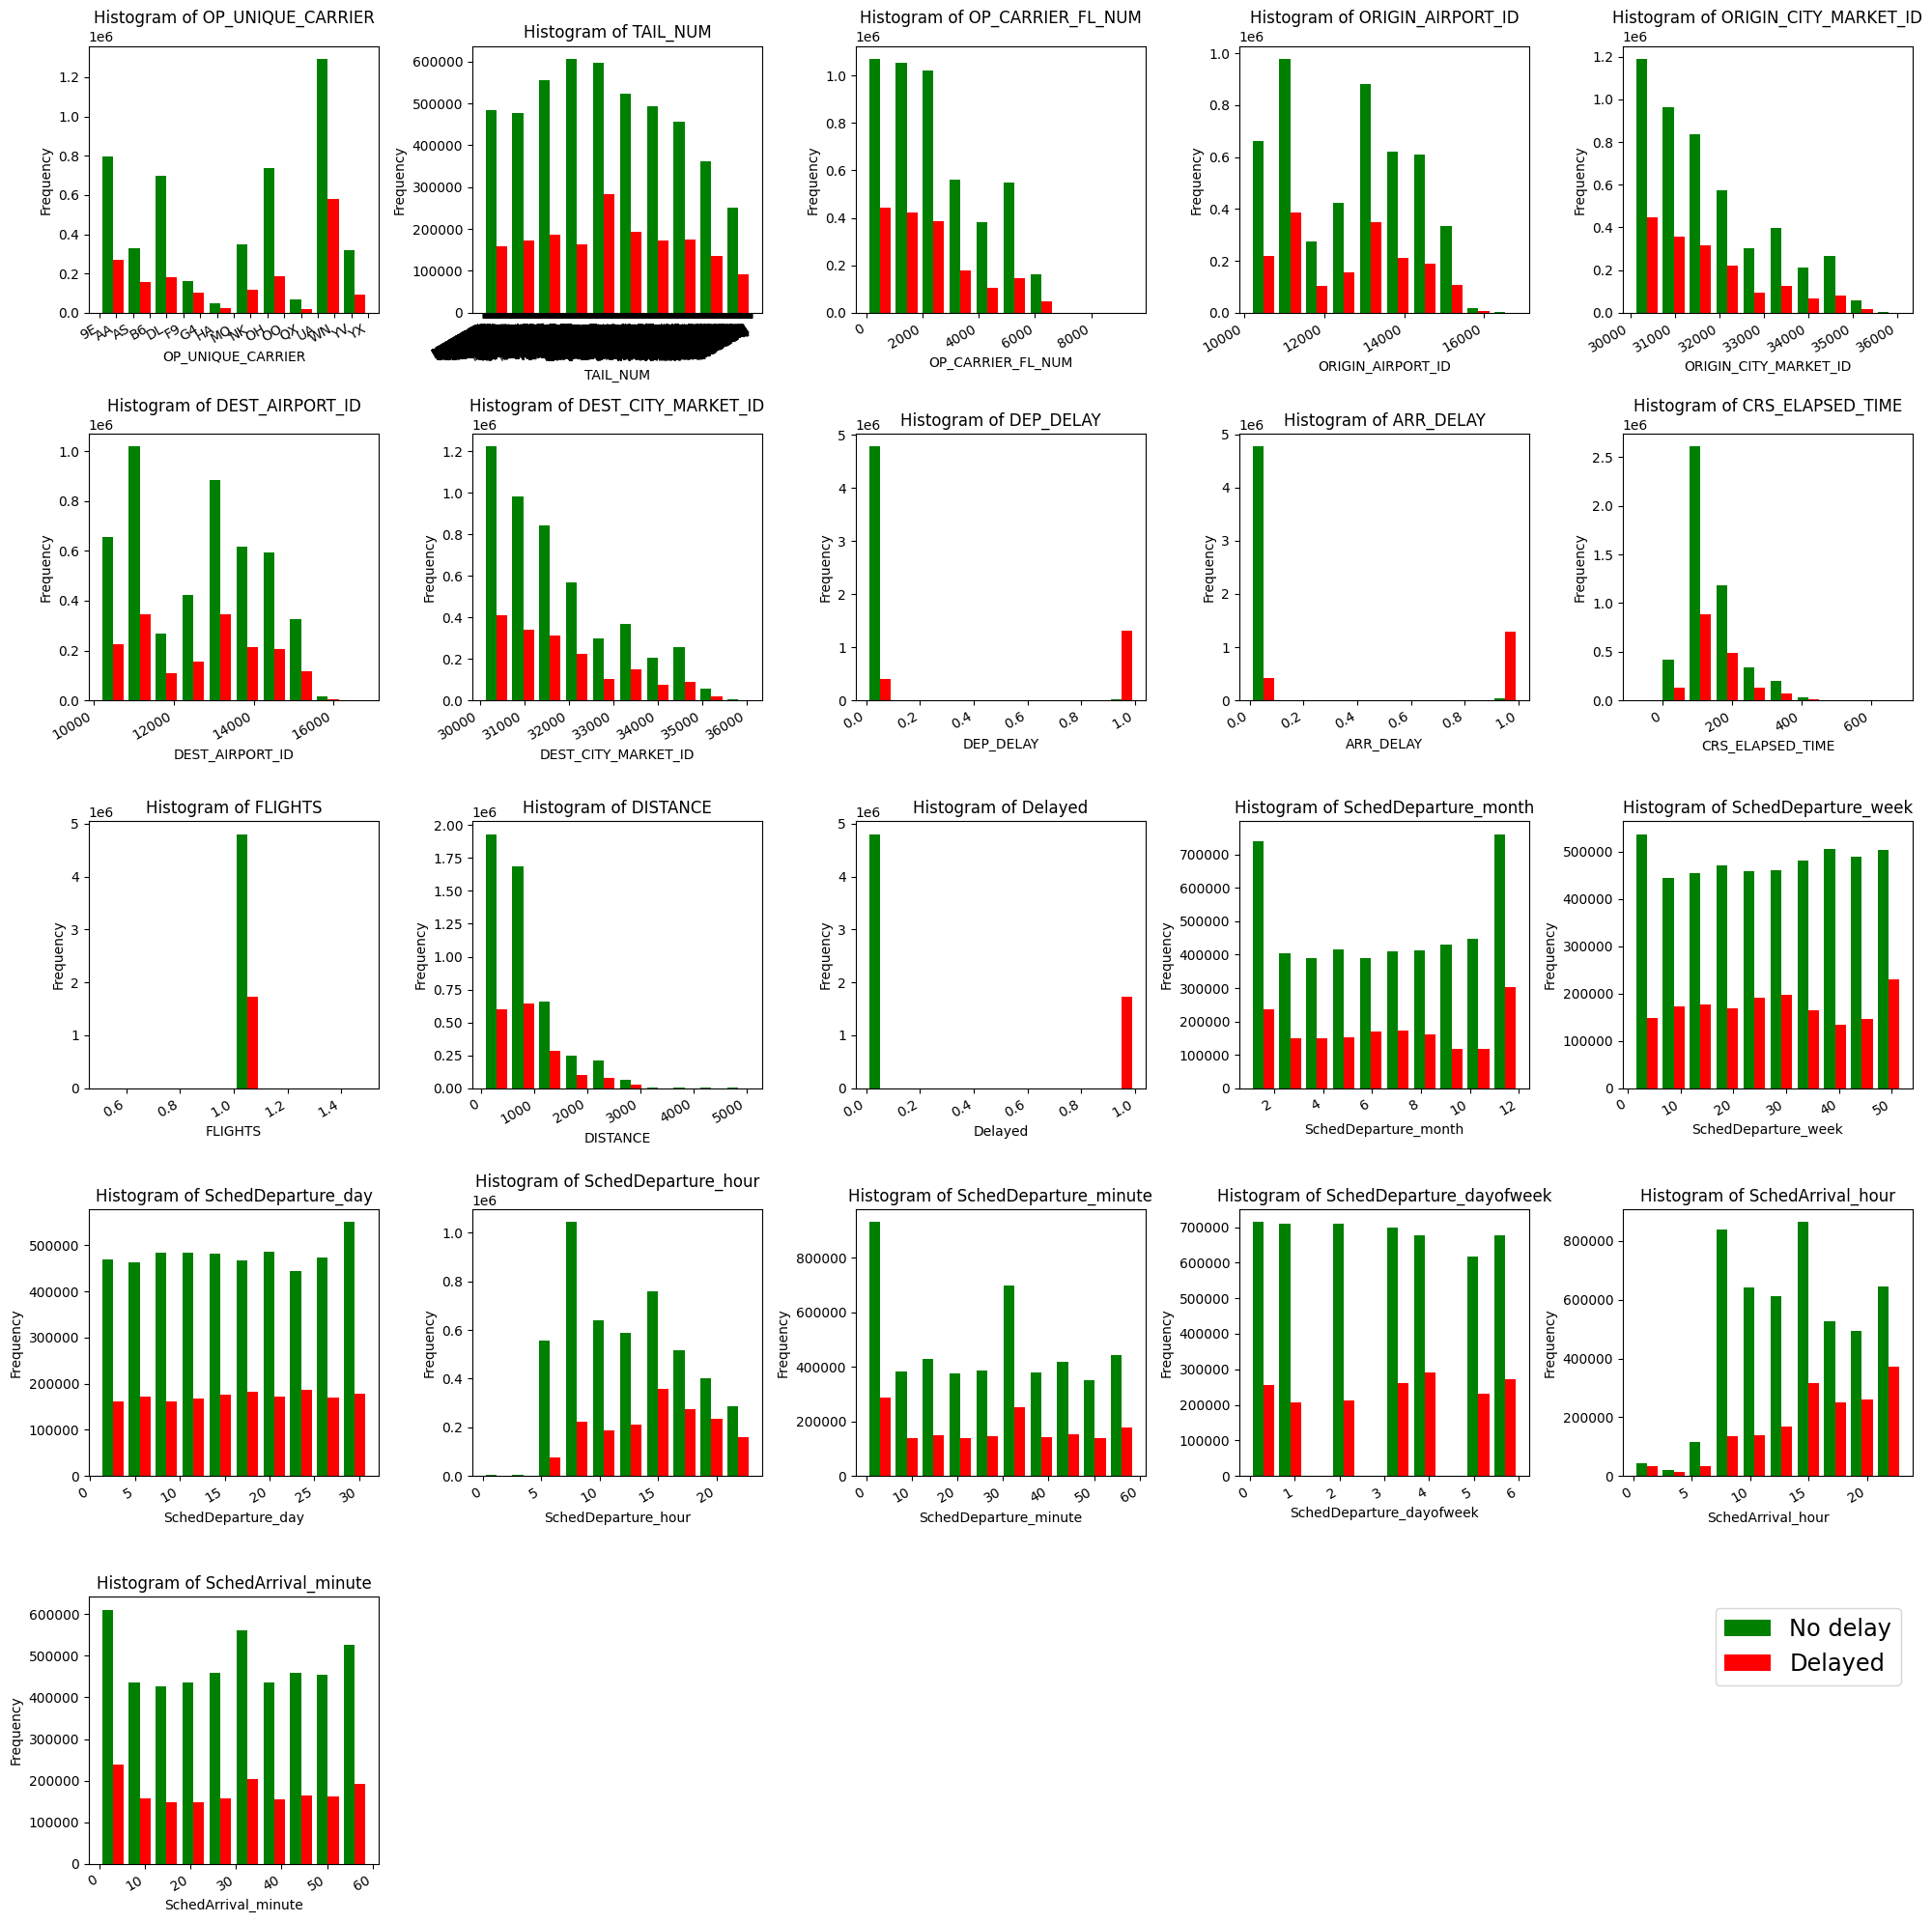

In [101]:
# Plot histograms for each column and making a separation between a delayed or non-delayed flight
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,1].axis('off')
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_usa4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist([data_usa4.loc[data_usa4["Delayed"]==0, name], data_usa4.loc[data_usa4["Delayed"]==1, name]], color=["green", "red"], label=["No delay", "Delayed"])
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    handles, labels = axs[x,y].get_legend_handles_labels()
    y+=1
fig.tight_layout()
plt.legend(handles, labels, fontsize="xx-large")
plt.show()

The proportion of delayed and non-delayed flights is also shown in the histograms for the top 10 occurring values in each column.

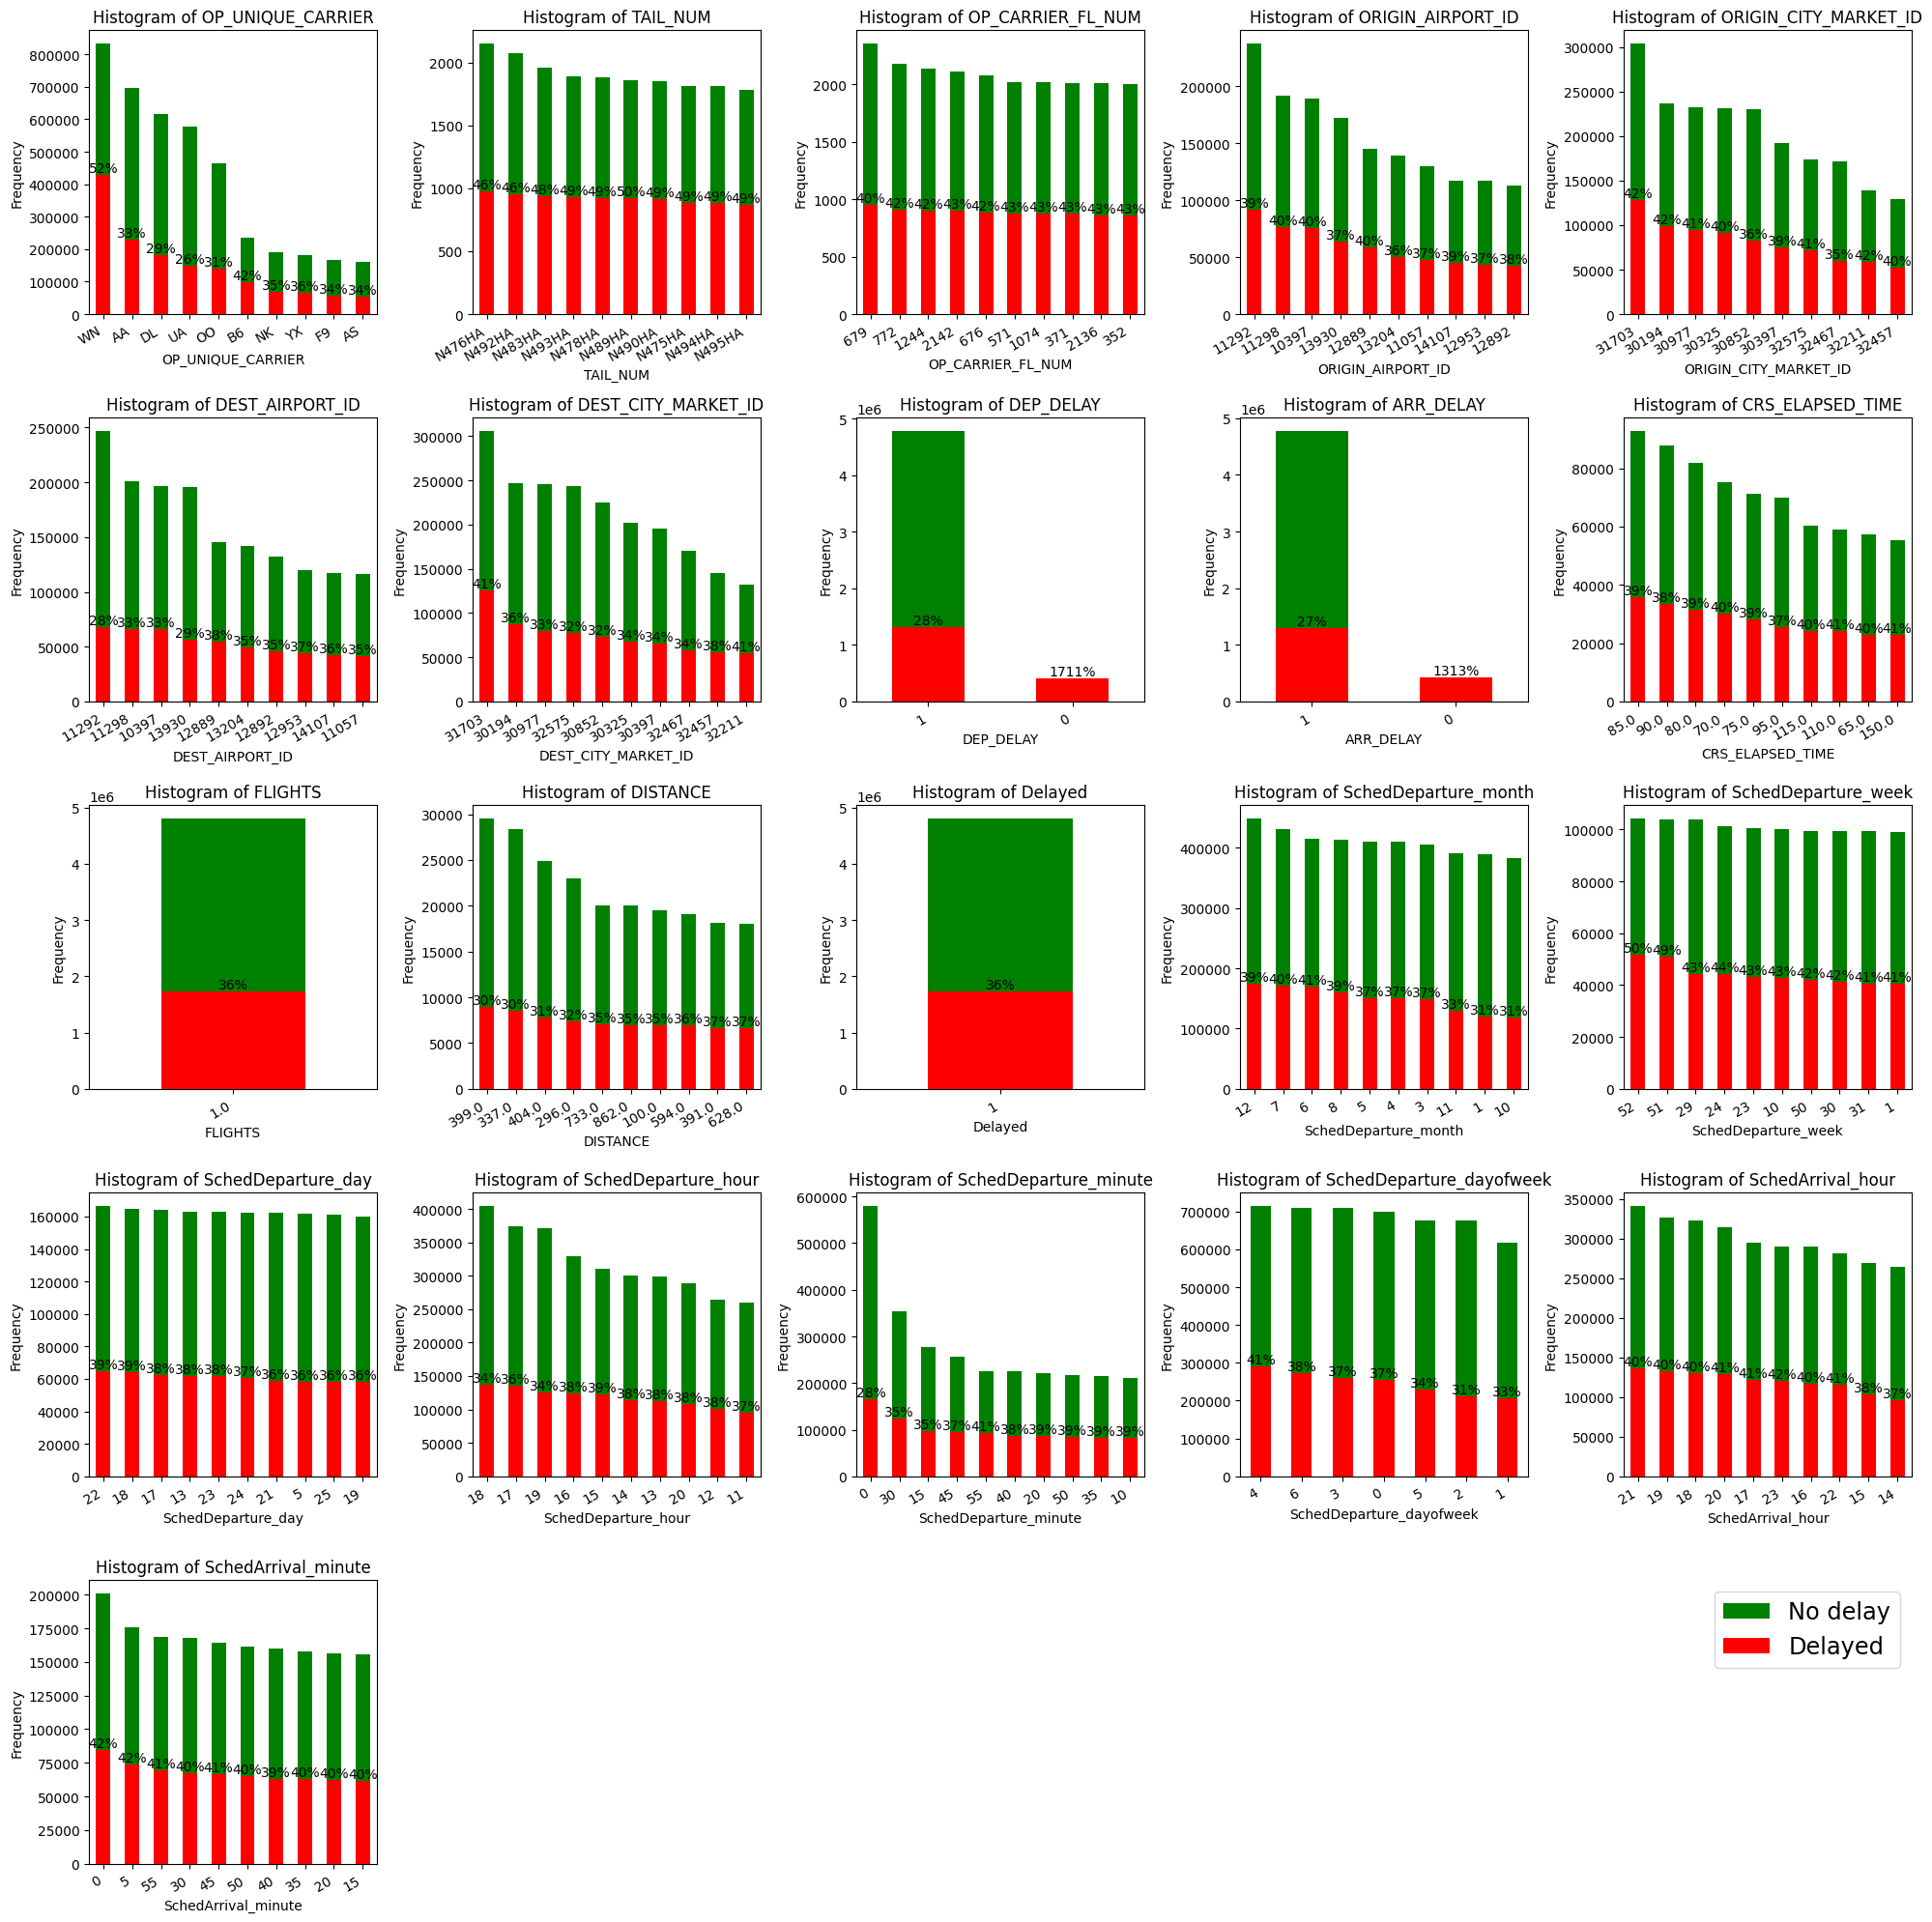

In [102]:
#  Plot histograms for each column, descending the top 10 occuring values for each column and making a separation between a delayed or non-delayed flight
fig, axs = plt.subplots(5,5, figsize=(20,20))
axs[4,1].axis('off')
axs[4,2].axis('off')
axs[4,3].axis('off')
axs[4,4].axis('off')
x = 0; y = 0
for i, name in enumerate(data_usa4.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    data_usa4.loc[data_usa4["Delayed"]==0, name].value_counts().head(10).plot(kind='bar', ax=axs[x,y], color='green', label="No delay")
    data_usa4.loc[data_usa4["Delayed"]==1, name].value_counts().head(10).plot(kind='bar', ax=axs[x,y], color='red', label="Delayed")
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    handles, labels = axs[x,y].get_legend_handles_labels()
    axs[x,y].bar_label(axs[x,y].containers[1], labels=[f'{item/axs[x,y].containers[0].datavalues[i]*100:.0f}%' for i, item in enumerate(axs[x,y].containers[1].datavalues)])
    y+=1
fig.tight_layout()
plt.legend(handles, labels, fontsize="xx-large")
plt.show()

From the new histograms that take our response variable into account, we can see that different days in the month experience a lot more delays than other days. We will also create boxplots to identify outliers and to create another way of looking at numerical data.

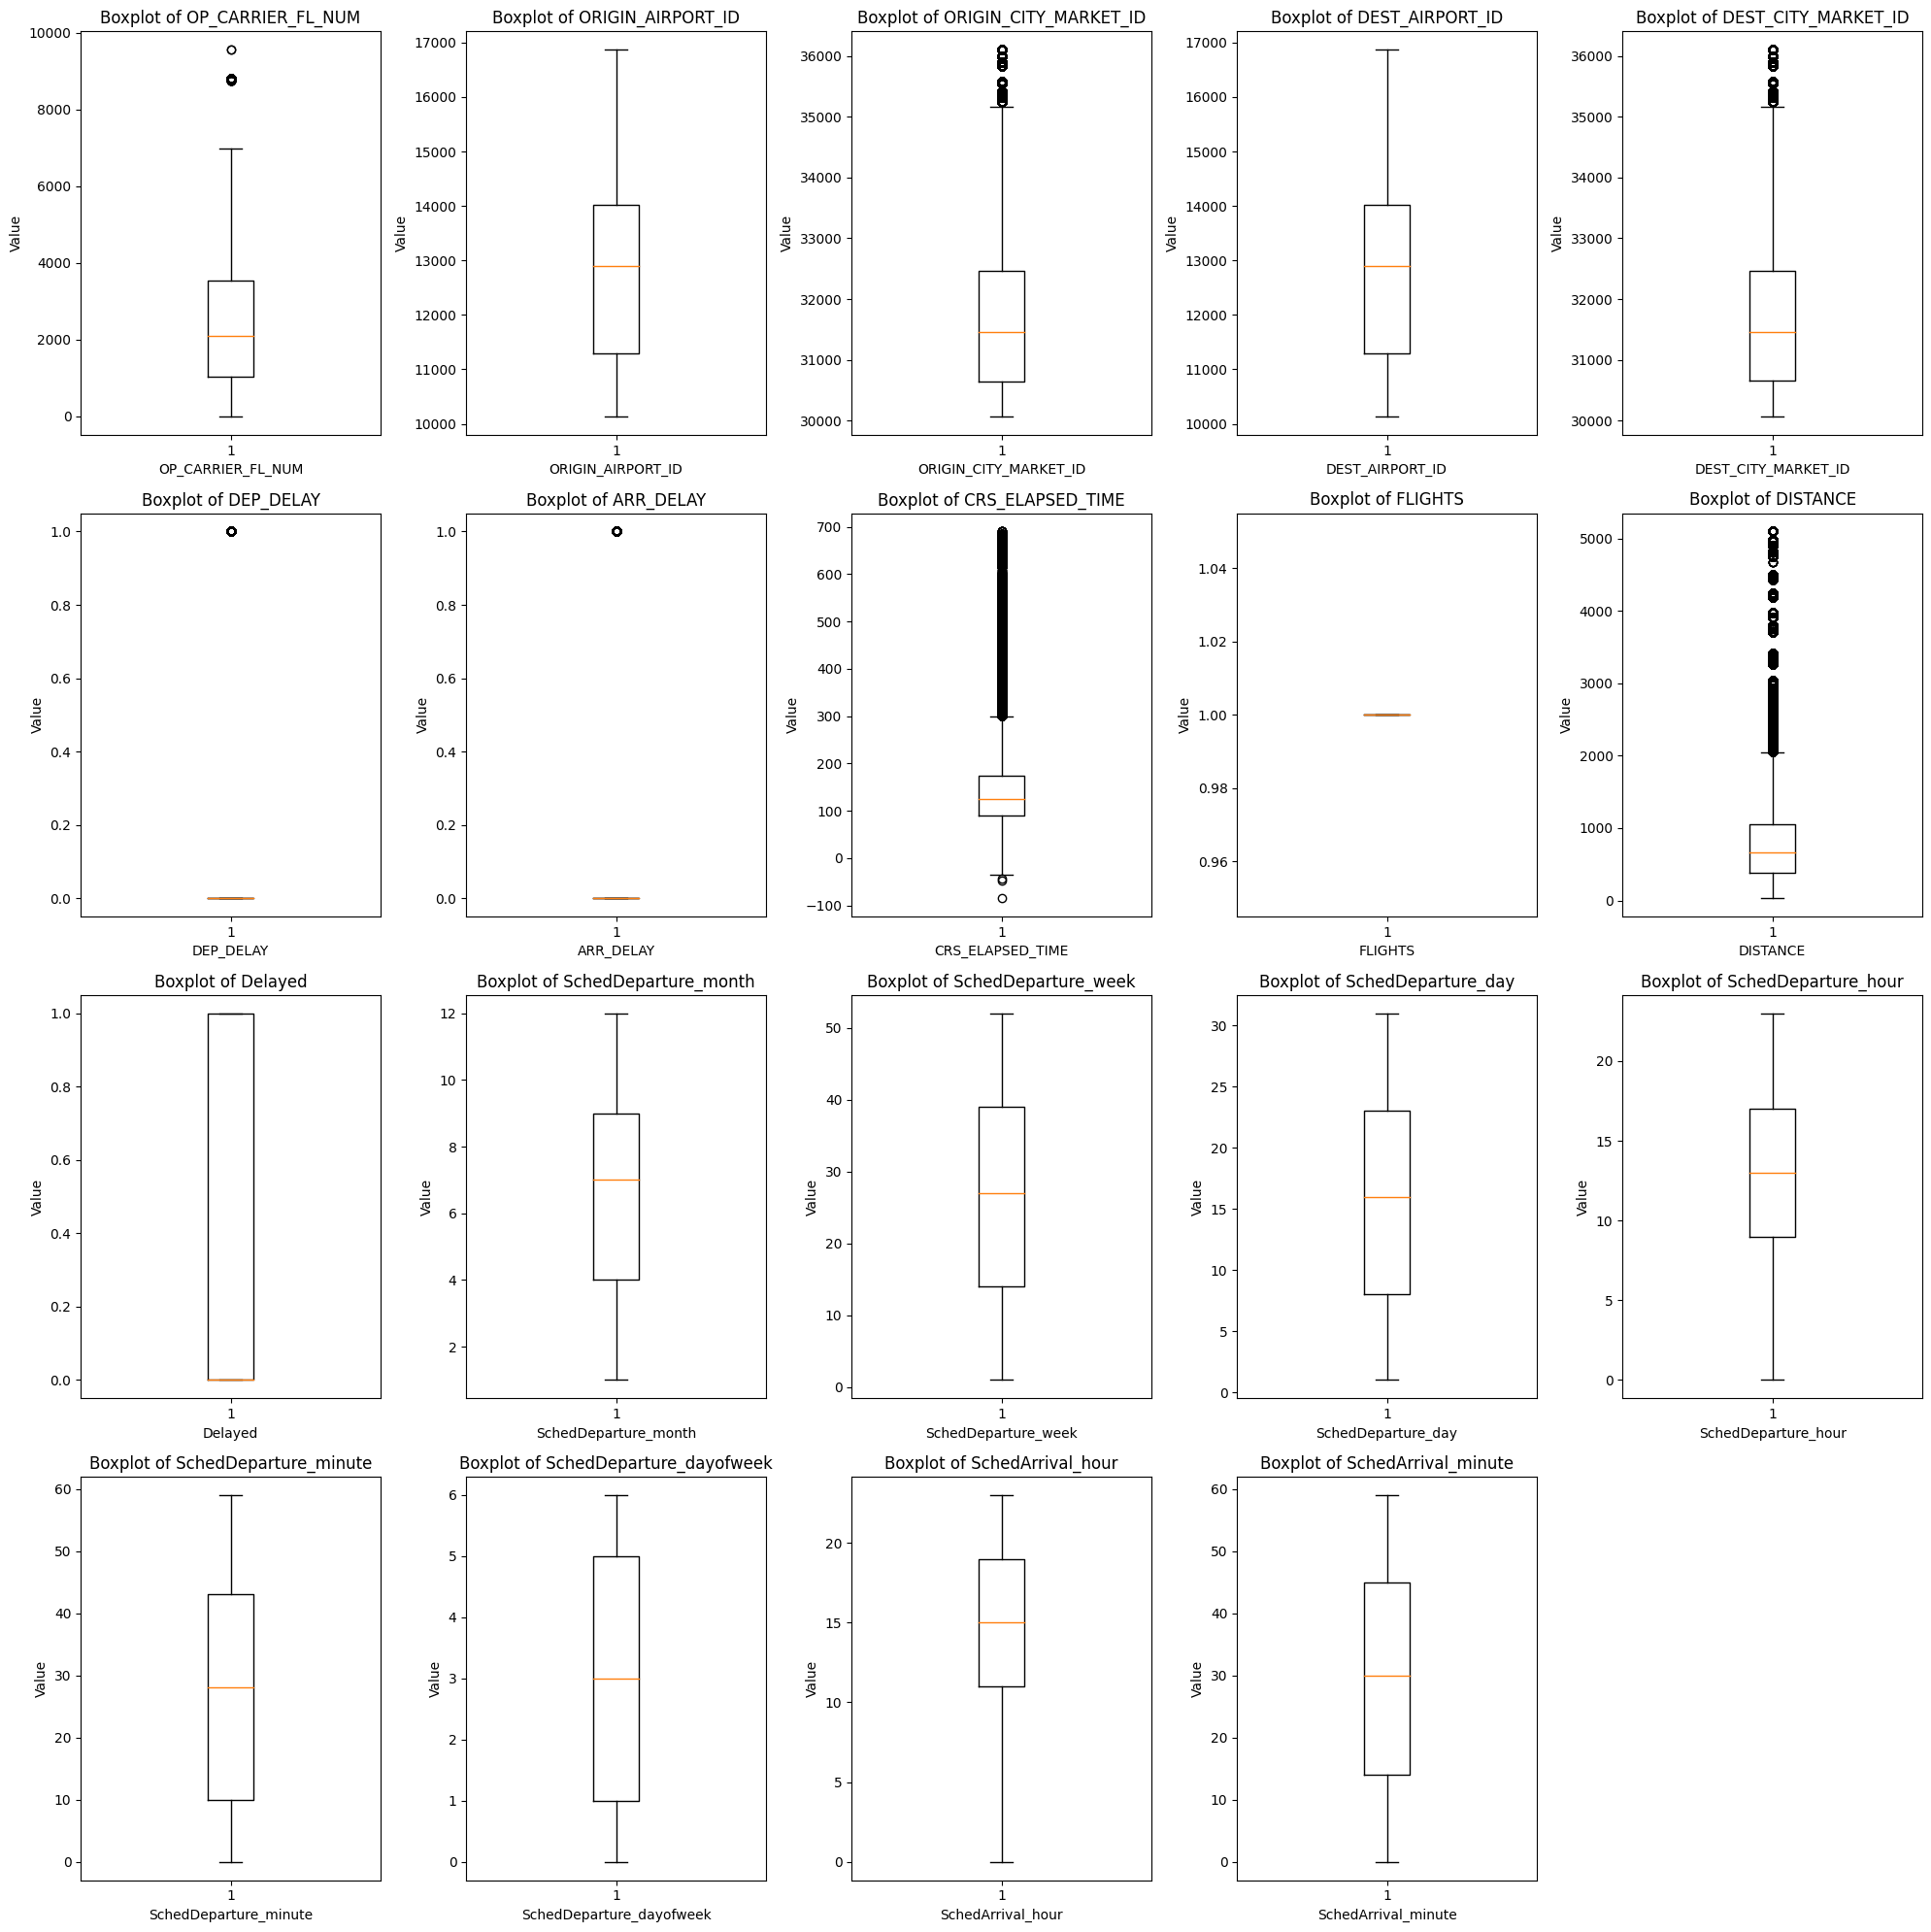

In [103]:
# Plot boxplots for numeric columns
fig, axs = plt.subplots(4,5, figsize=(20,20))
axs[3,4].axis('off')
x = 0; y=0; count=0
for i, name in enumerate(data_usa4.columns.values):
    if is_numeric_dtype(data_usa4[name]):
        if count % 5 == 0 and count != 0:
            x += 1
            y = 0
        axs[x,y].boxplot(x=data_usa4[name])
        axs[x,y].set(xlabel=name, ylabel="Value")
        axs[x,y].set_title("Boxplot of " + name)
        count +=1
        y += 1
fig.tight_layout()
plt.show()

The route between Boston and Honolulu is more than 5000 miles and takes about 10 hours in both directions, which shows that the outliers for the distance and elapsed time are not really outliers in the sense that they are real datapoints. The carrier flight number represents the flight number of a flight, which is unique for each route. Therefore, just as the market ID, these columns are categorical and outliers are not being removed. The `FLIGHTS` column, however, has only one value for all the rows in the data. It represents the amount of flights that are done, which is of course 1. This redundant column is therefore removed.

In [104]:
# Drop column since its value is the same in every row
data_usa5 = data_usa4.drop(columns=["FLIGHTS"])

# Create copies of dataset to use for feature selection and ML algorithms
data_usa_fs = data_usa4.drop(columns=["FLIGHTS"])
data_usa_ml = data_usa4.drop(columns=["FLIGHTS"])

To have a better look at the proportion of delayed flights per value in each column, the proportions are plotted in a histogram. The top 10 values for each column with the highest proportion of delayed flights are plotted to get a better look at which factors caused delays in the flights of this data set.

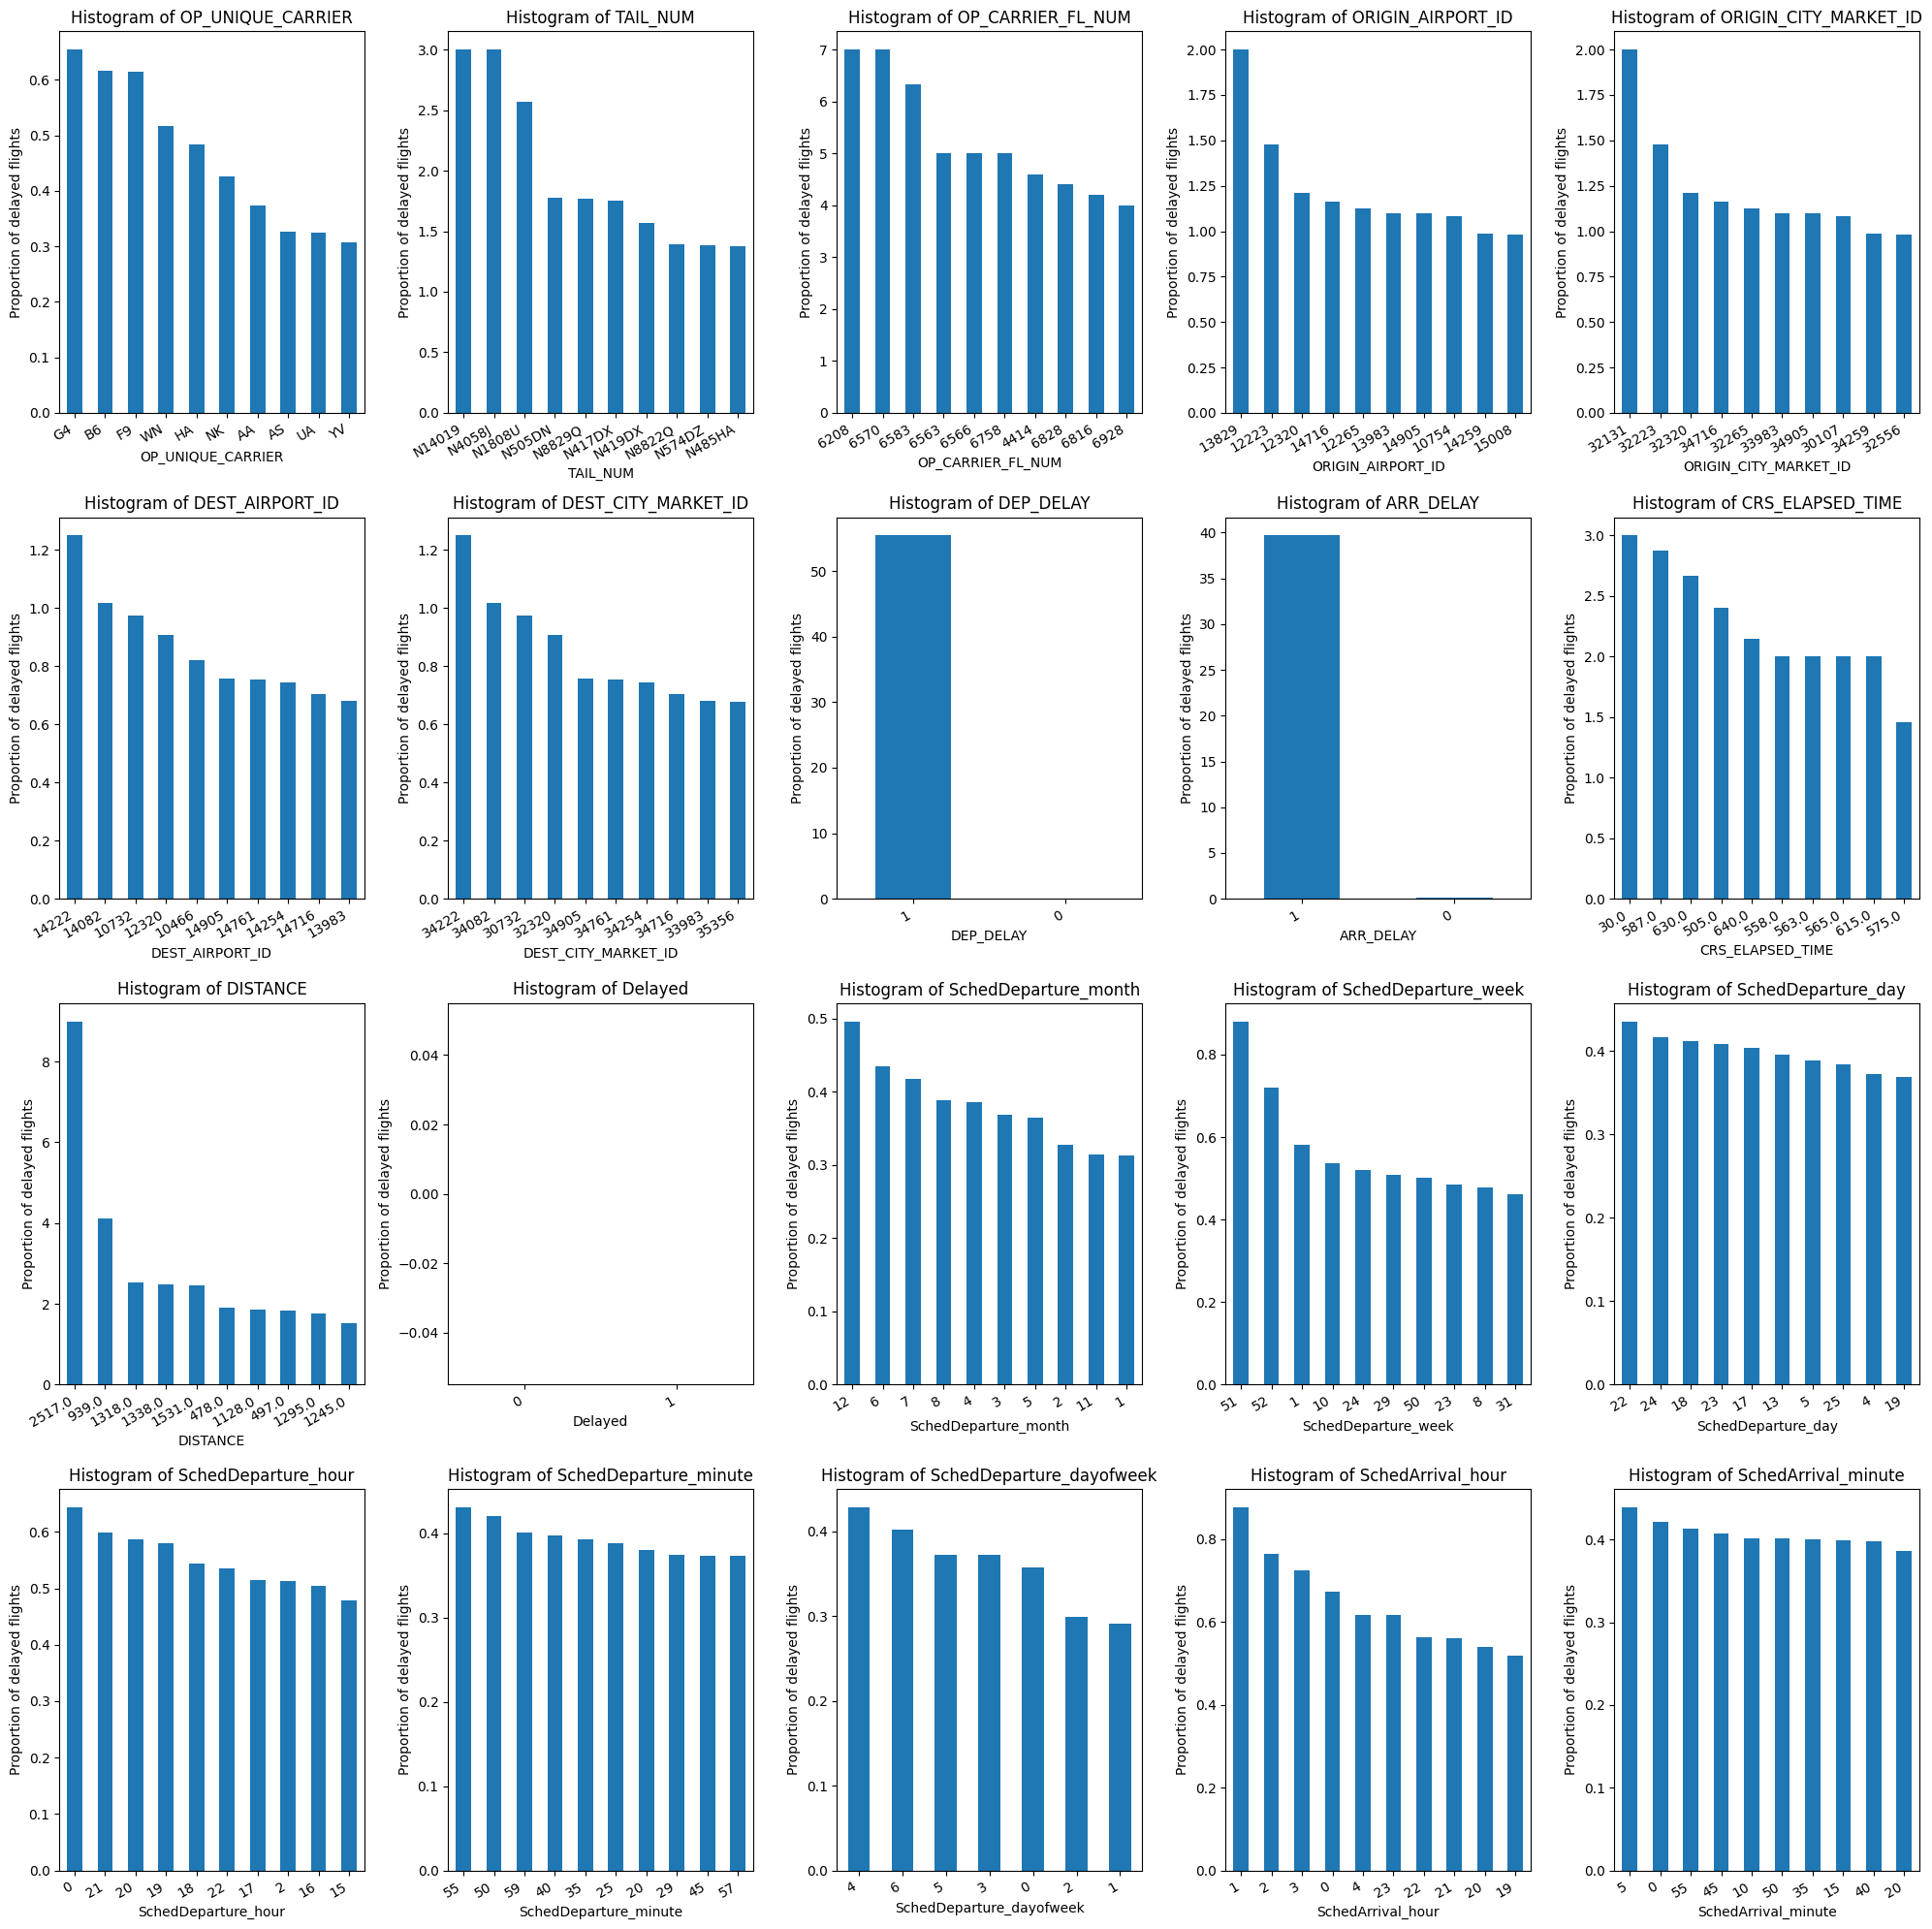

In [105]:
# Look per column for highest proportion of delayed flights for certain value
no_delay = data_usa5[data_usa5["Delayed"]==0]
delayed = data_usa5[data_usa5["Delayed"]==1]

fig, axs = plt.subplots(4,5, figsize=(20,20))
x = 0; y = 0
for i, name in enumerate(data_usa5.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    (delayed[name].value_counts() / no_delay[name].value_counts()).sort_values(ascending=False).head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Proportion of delayed flights")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

It is visible that for instance flights on a friday are more likely to be delayed, wehereas certain tail numbers even have more delayed flights than non-delayed flights. To see which factors ensure the least amount of delayed flights, a histogram has been plotted with the lowest 10 proportions of delayed flights for each column value.

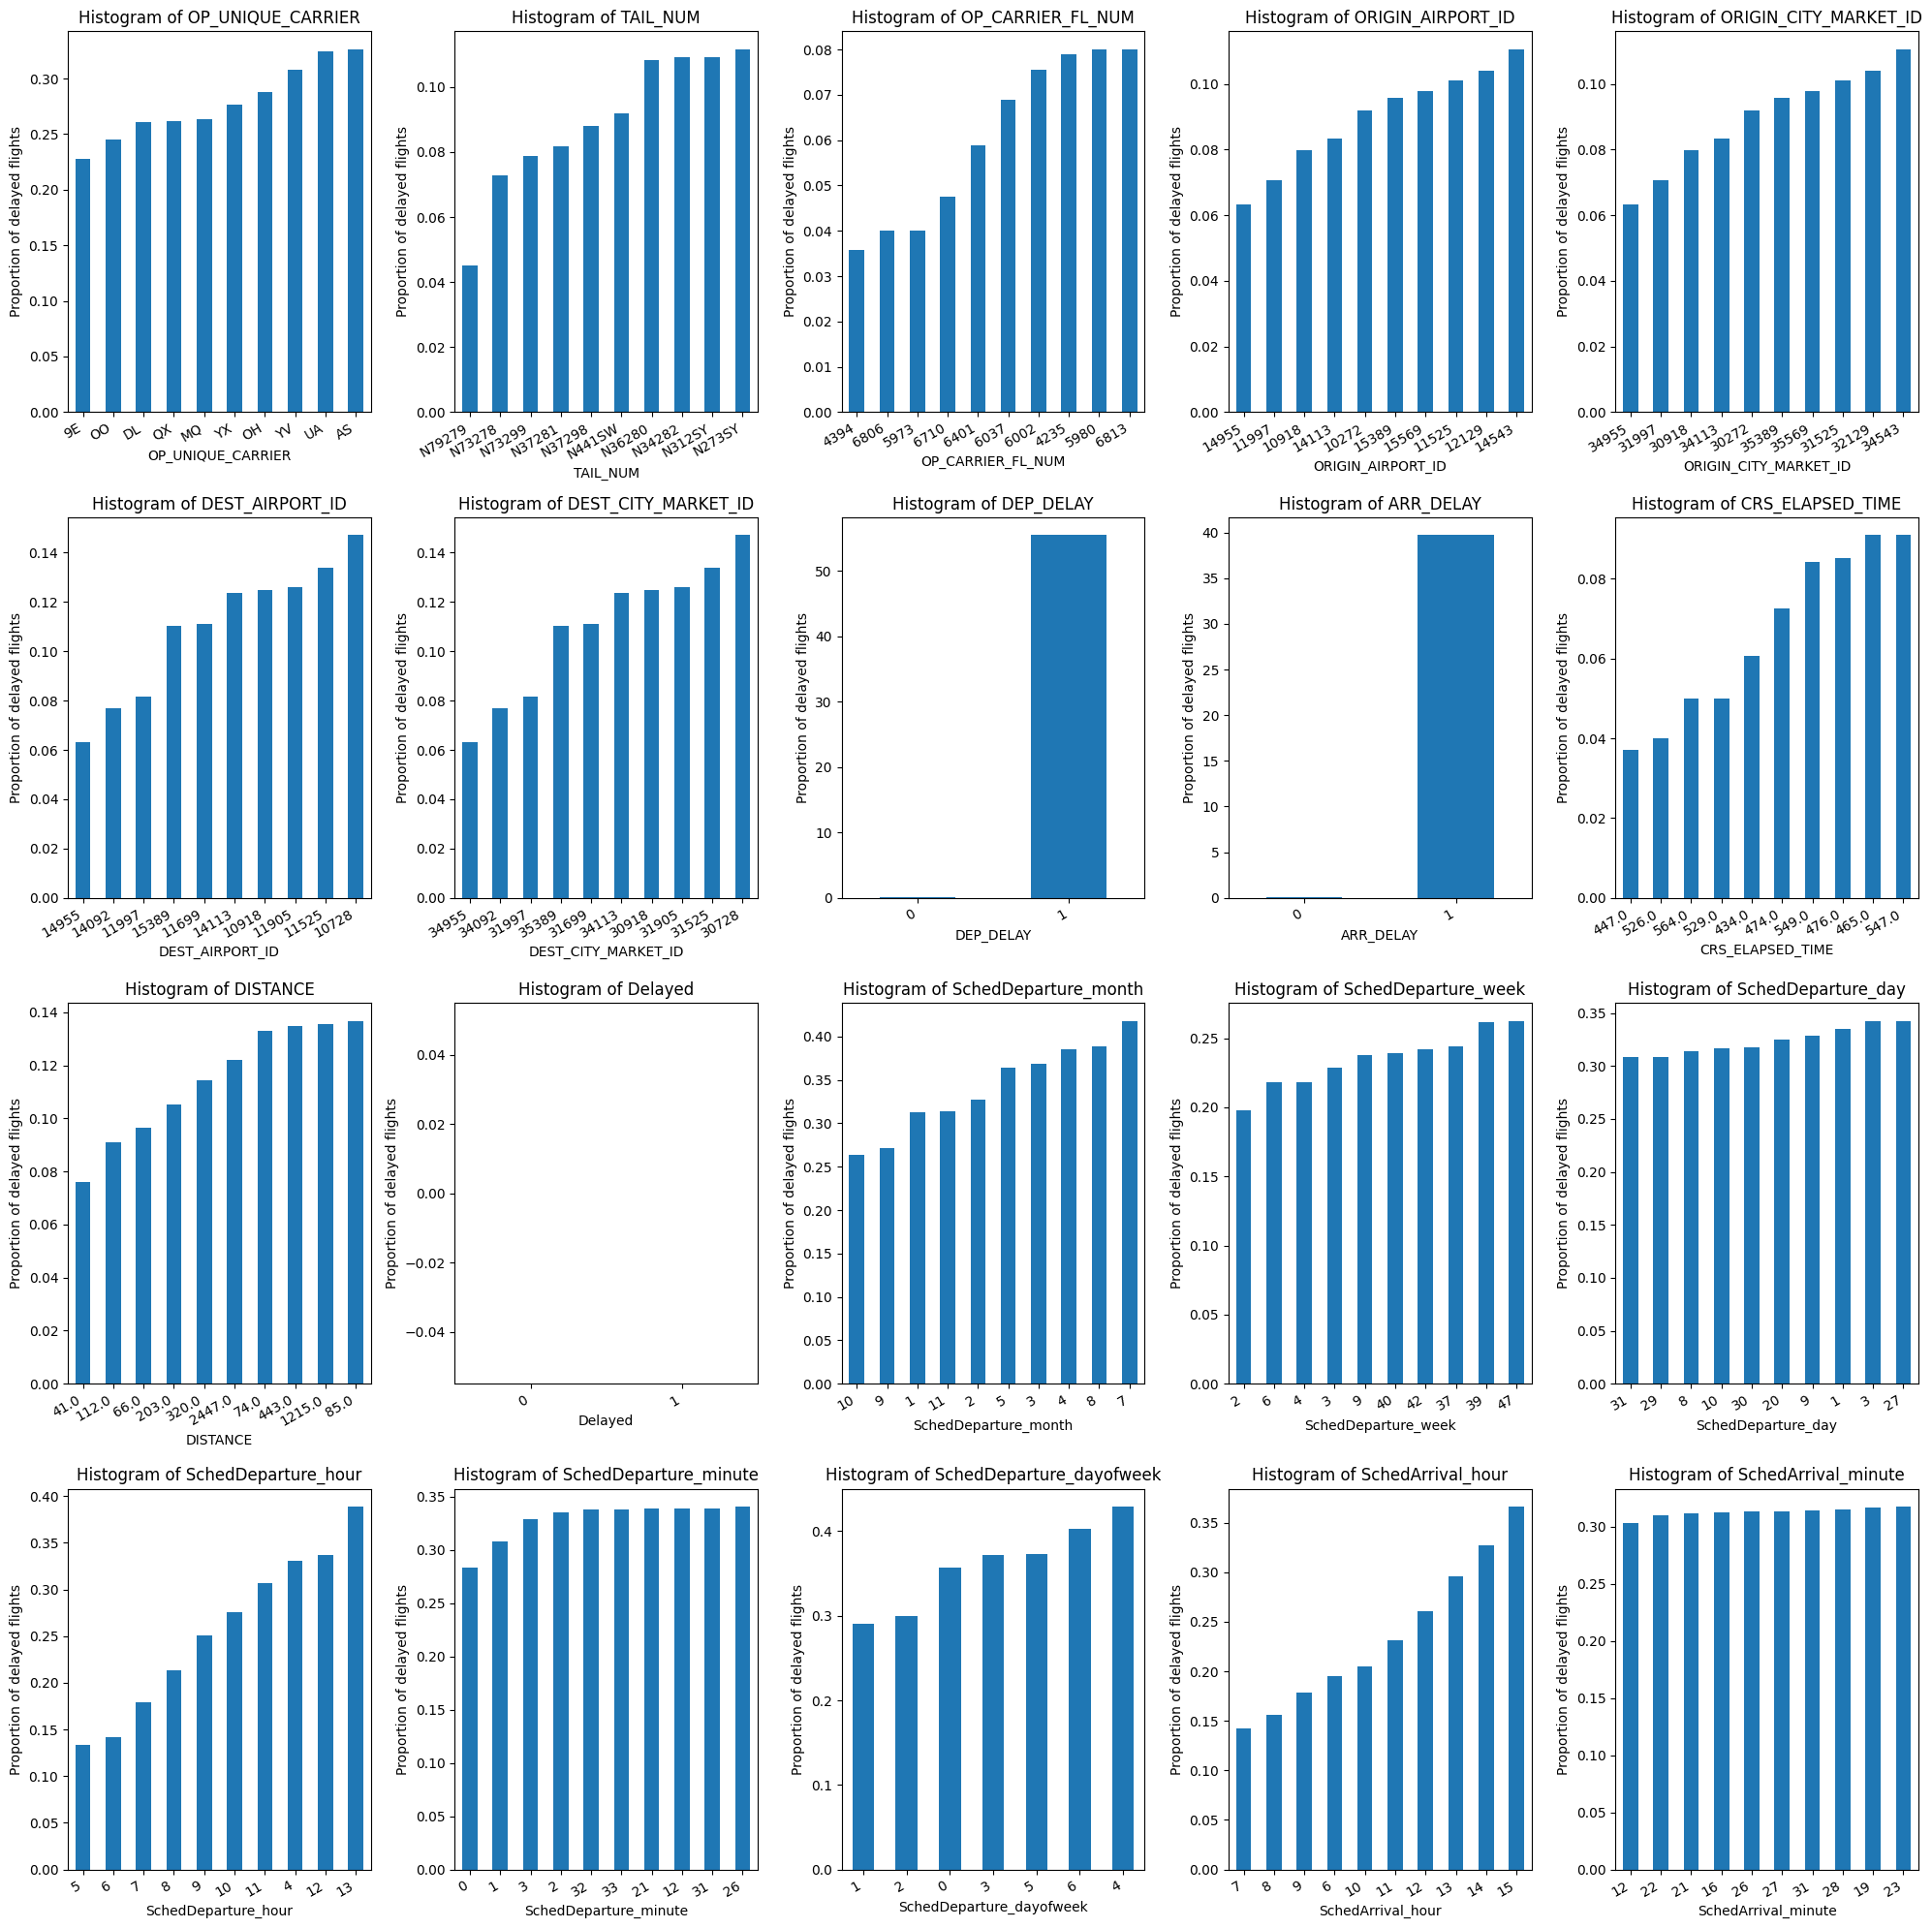

In [107]:
# Look per column for lowest proportion of delayed flights for certain value
no_delay = data_usa5[data_usa5["Delayed"]==0]
delayed = data_usa5[data_usa5["Delayed"]==1]

fig, axs = plt.subplots(4,5, figsize=(20,20))
x = 0; y = 0
for i, name in enumerate(data_usa5.columns.values):
    if i % 5 == 0 and i != 0:
        y = 0
        x += 1
    (delayed[name].value_counts() / no_delay[name].value_counts()).sort_values(ascending=True).head(10).plot(kind='bar', ax=axs[x,y])
    axs[x,y].set(xlabel=name, ylabel="Proportion of delayed flights")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

From the plots, it can be seen that for instance early flights in the morning are less likely to be delayed. The same holds for certain flight routes which have an lower proportion of delayed flights in general.

#### 3.4 Feature selection
We will now look at which features seem to be the most important for our problem prior to applying the machine learning algorithms. Firstly, to visualize the correlations between variables, a heatmap is created. This is done in order to detect possible high collinearity in our model.

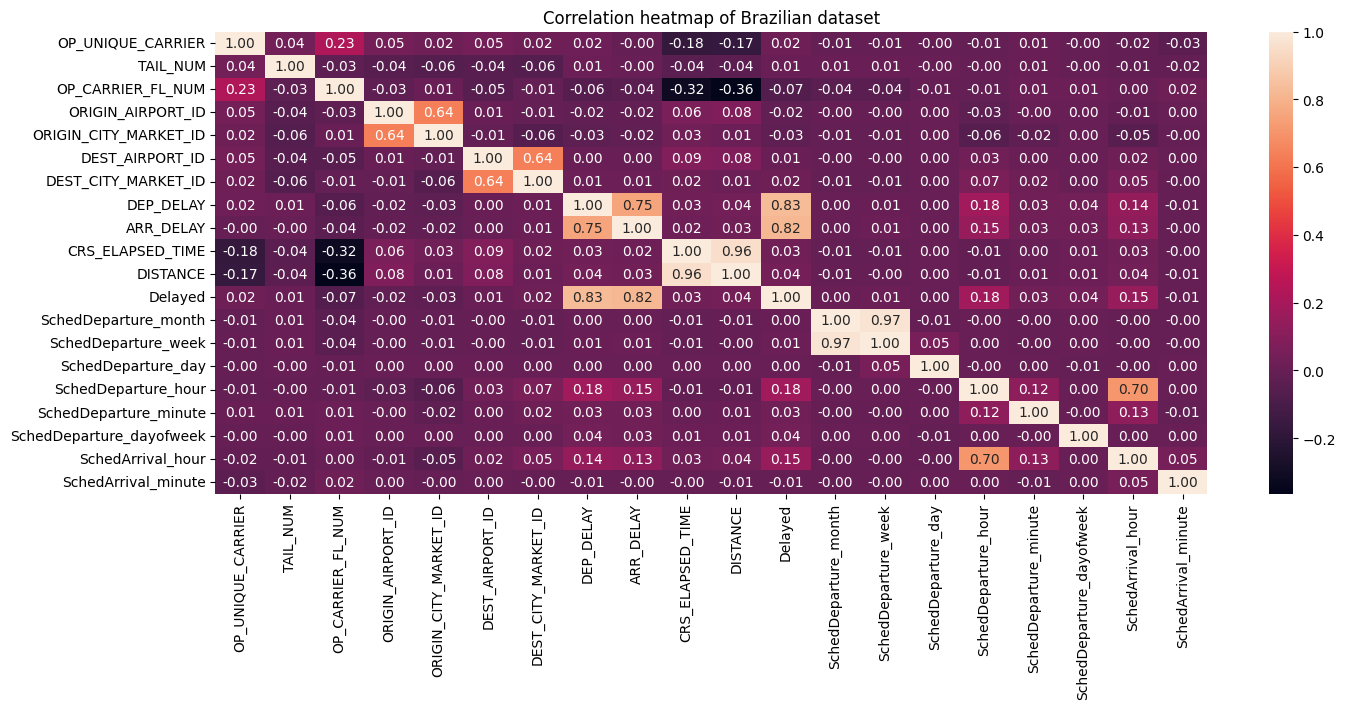

In [108]:
# Create correlation heatmap
for name in data_usa5.columns.values:
    data_usa5[name] = data_usa5[name].astype('category').cat.codes
plt.figure(figsize=(16, 6))
plt.title("Correlation heatmap of Brazilian dataset")
heatmap = sns.heatmap(data_usa5.corr(), annot=True, fmt=".2f")
plt.show()

Besides collinearity between the response variables, there are signs of high collinearity (correlation >= 0.7 [source](https://doi.org/10.1111/j.1600-0587.2012.07348.x)) between some of the explanatory variables in this data set. Therefore, some columns have to be removed. It can be seen that there is high collinearity between the elapsed time and the distance of a flight. This is quite understandable, since these depend on each other. For this reason, I chose to remove the elapsed time column. The scheduled departure hour and scheduled arrival hour are also highly correlated, so the scheduled arrival hour column will be removed. It can also be noted that the city market id's are almost above the collinearity threshold, so they might be removed later. Lastly, it can be seen that there is high collinearity between the scheduled departure week and month in the data set. This makes sense, since the records with the same weeks are almost always in the same month. Therefore, the scheduled departure week column will also be removed.

In [109]:
data_usa5.drop(columns=["CRS_ELAPSED_TIME", "SchedArrival_hour", "SchedDeparture_week"], inplace=True)
data_usa_fs.drop(columns=["CRS_ELAPSED_TIME", "SchedArrival_hour", "SchedDeparture_week"], inplace=True)
data_usa_ml.drop(columns=["CRS_ELAPSED_TIME", "SchedArrival_hour", "SchedDeparture_week"], inplace=True)

After removing these columns out of our data set, we can check if there is still a sense of high collinearity between the explanatory variables.

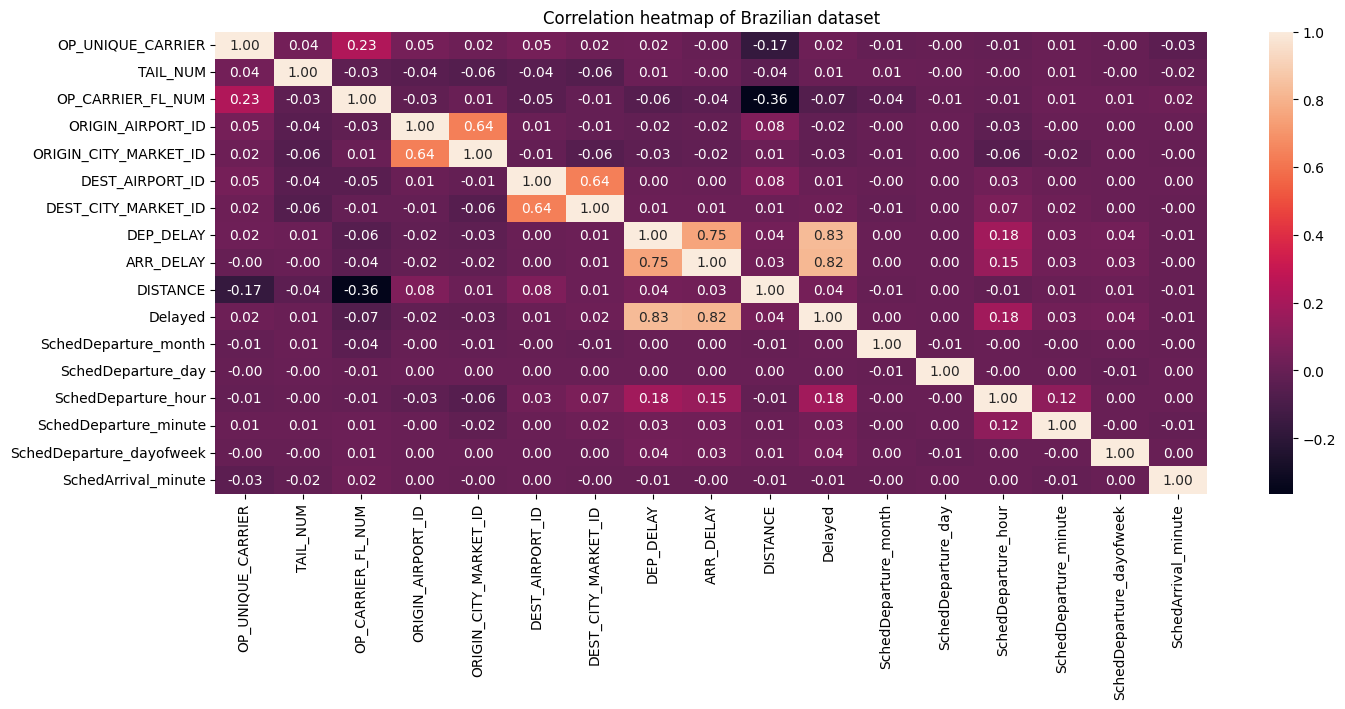

In [110]:
# Create correlation heatmap
plt.figure(figsize=(16, 6))
plt.title("Correlation heatmap of Brazilian dataset")
heatmap = sns.heatmap(data_usa5.corr(), annot=True, fmt=".2f")
plt.show()

It can be seen that the collinearity has been removed now, so the machine learning algorithms will perform more realistically.

Another way to gain information about which features contain the most information prior to the machine learning phase is to perform a chi-square test and look at the mutual information gain.

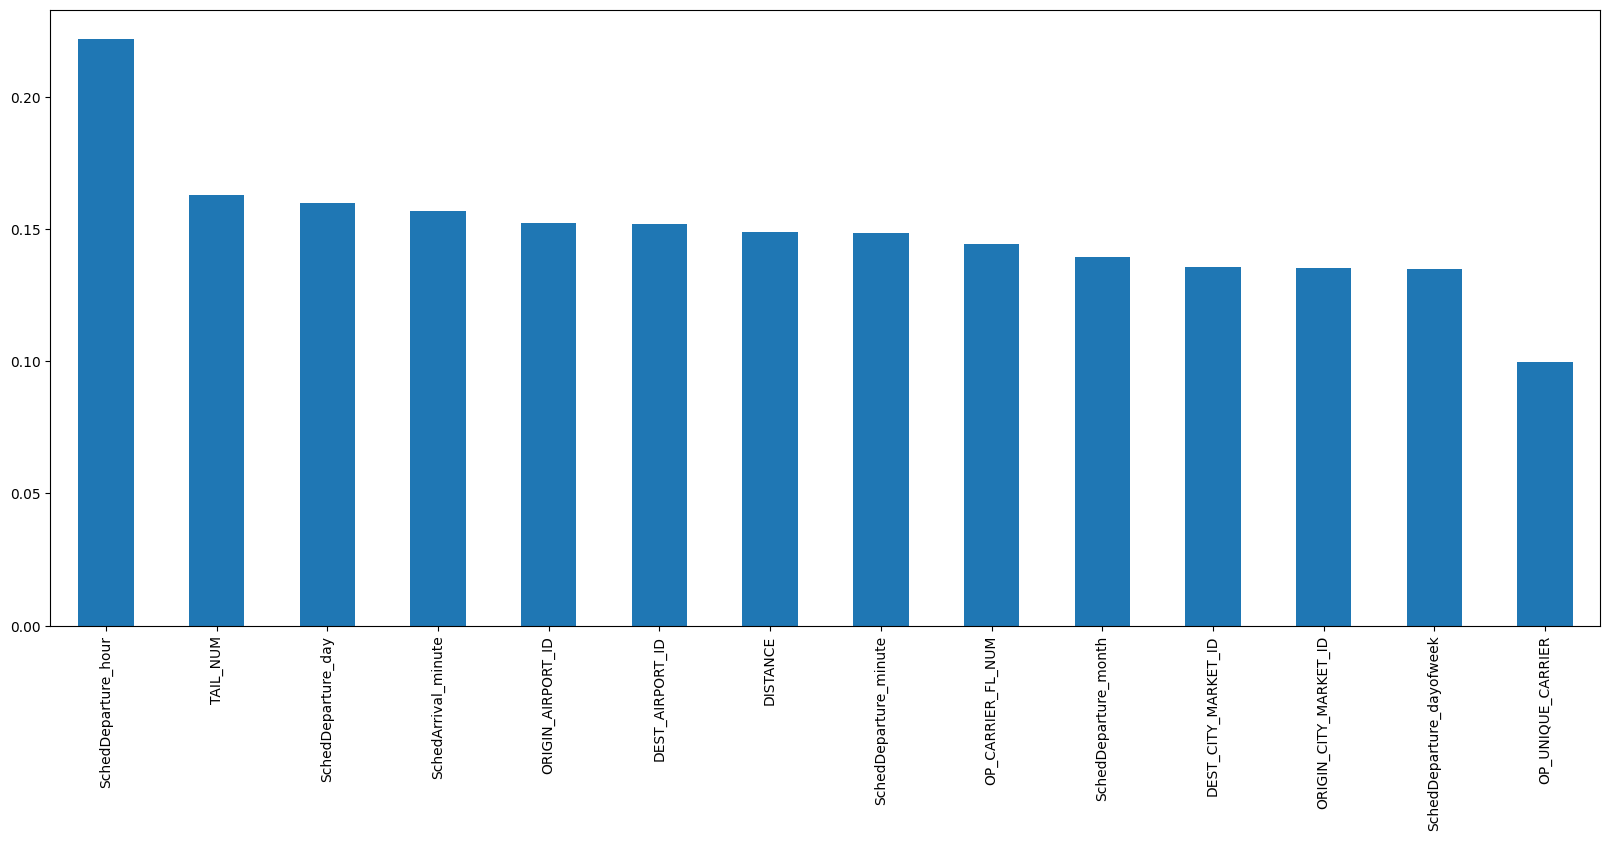

Index(['TAIL_NUM', 'DEST_AIRPORT_ID', 'SchedDeparture_day',
       'SchedDeparture_hour', 'SchedArrival_minute'],
      dtype='object')

In [111]:
# Create X and y of dataset
y = data_usa5["Delayed"]
X = data_usa5.drop(columns=["Delayed", "ARR_DELAY", "DEP_DELAY"])

# Chi2 test
# f_p_values=chi2(X, y)
# p_values=pd.Series(f_p_values[1])
# p_values.index=X.columns
# print(p_values.sort_values(ascending=True))

# Calculate mutual information gain
mutual_info = mutual_info_classif(X,y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit_transform(X,y)
X.columns[sel_five_cols.get_support()]

The mutual information gain is a metric to get the importance of a variable. The higher the value, the more important that feature will be. In our case, we can see that the scheduled departure hour and day, the tail number and the scheduled departure minute have the highest values. No columns will be removed, since we are only looking at one month of data yet.

The last metric used to see which features are more important than others is the information gain, which is calculated using the WoE. 

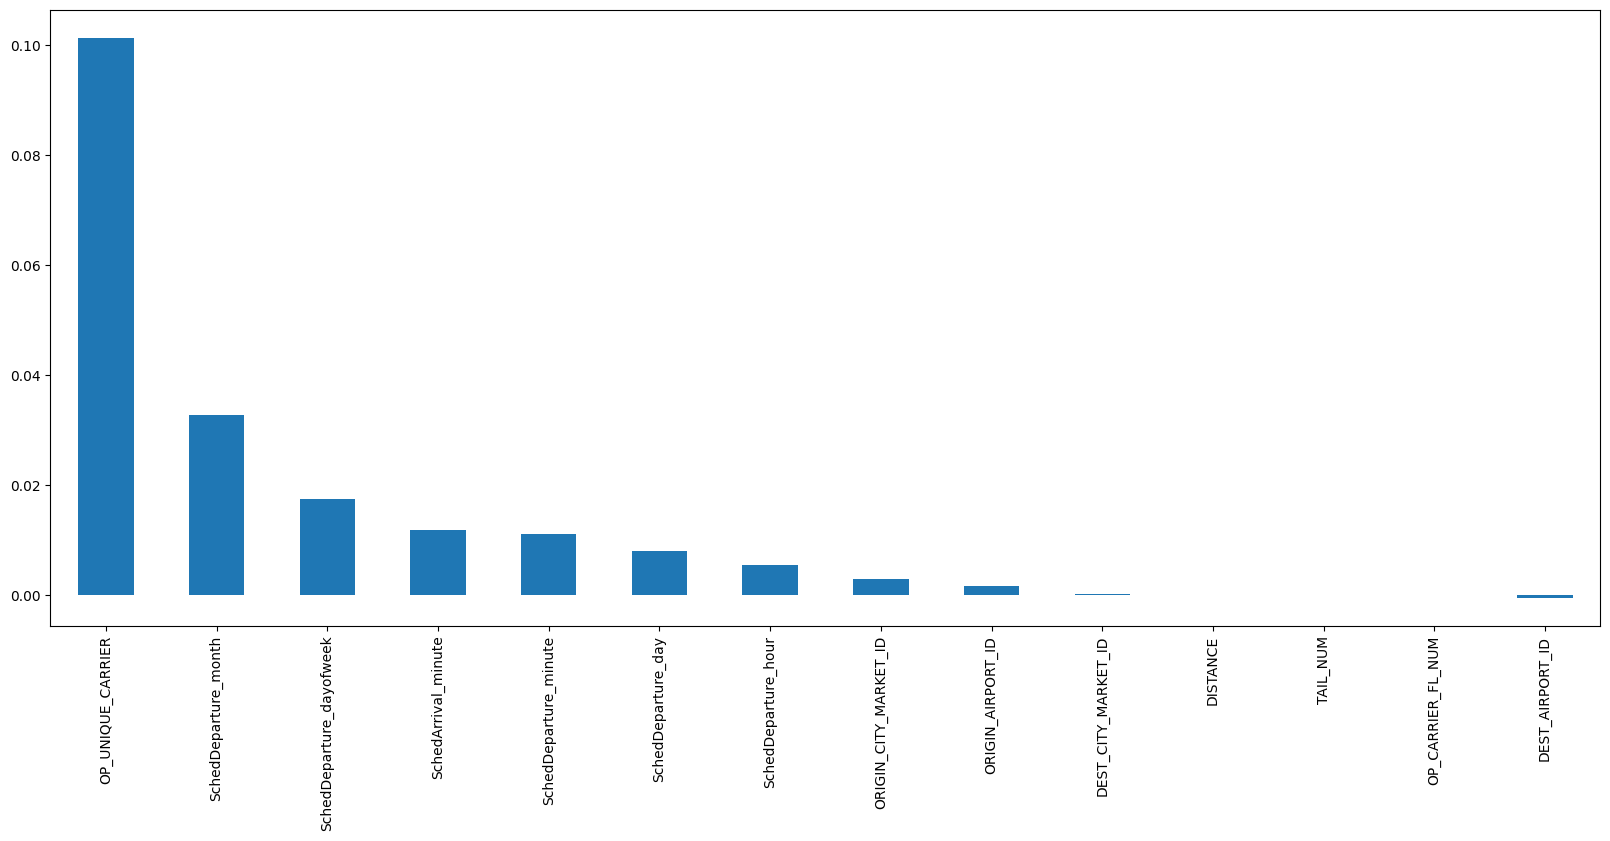

In [112]:
# Function to calculate information value
def get_iv(feature, target):
    df_woe_iv = (pd.crosstab(data_usa_fs[feature],data_usa_fs[target], normalize='columns')
                .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]) if (dfx[0]>0.0001).all() else dfx[1])
                .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv = df_woe_iv.iloc[0,2:][1]
    return iv

# Plot information value for all explanatory variables
X_fs = data_usa_fs.drop(columns=["Delayed", "ARR_DELAY", "DEP_DELAY"])
ivs = []
for feature in X_fs.columns.values:
    ivs.append(get_iv(feature, "Delayed"))
ivs_pd = pd.Series(ivs)
ivs_pd.index = X_fs.columns
ivs_pd.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.show()

The resulting plot of information values shows that most features have an IV below the useful threshold. However, this is caused due to the dataset being really diverse, which is the reason no variables will be removed yet.

The feature selection has shown some preliminary influences of various attributes. However, the predictions can use completely different factors as the crucial features, so these results are not to be fully taken representative.